# My Movie Database (MMDb)

## Structure

- Sources
    - Trakt : Track what you watch and when
    - OMDb : Open Movie Database
    - IMDb : Internet Movie Database 
    
- Merge OMDb data with IMDb data based on Trakt's watched movies history
- Analysis using merged dataset

## Inputs

- Merged dataset : pickle
- Trakt : only by connection with API (key need)
- OMDb  : txt or connection with API (key need)
- IMDb  : txt or connection with API

## Outputs

- Merged dataset : pickle
- OMDb request result : txt
- IMDb request result : txt

---

# Hard settings

In [1]:
## OPTIONAL
# Get data
get_data = False

# Force api requests and get all data
force_request = False
#if force_request:
#    get_data = True

# Check data before analysis
data_check = False

# Export data
export = False
# Export data to pickle file
export_pickle = False
if export_pickle:
    export = True

In [2]:
## DON'T CHANGE
# Load Files
load_pickle = False
load_omdb = False
load_imdb = False

# Imports

In [3]:
# https://stackoverflow.com/questions/66920753/running-a-justpy-web-app-on-jupyter-returns-runtimeerror
import nest_asyncio
nest_asyncio.apply()

# Import functions
# https://stackoverflow.com/questions/20186344/ipynb-import-another-ipynb-file
%run MMDb_functions.ipynb

# Load Files

## Pickle file

In [4]:
# The pickle module implements binary protocols for serializing and de-serializing a Python object structure. 
# “Pickling” is the process whereby a Python object hierarchy is converted into a byte stream, and “unpickling” is the inverse operation, 
# whereby a byte stream (from a binary file or bytes-like object) is converted back into an object hierarchy.
pkl_file = 'movies.pkl'
pkl_path = src_path + pkl_file

try:
    foo = pickle.load(open(pkl_path, "rb"))
except (OSError, IOError) as e:
    foo = 3
    #pickle.dump(foo, open(pkl_path, "wb"))
    
if isinstance(foo, pd.core.frame.DataFrame):
    load_pickle = True
    
    foo.sort_values(by='Timestamp', inplace=True)
    foo = foo.reset_index(drop=True)

    foo.info()
else:
    print('No pickle.')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 956 entries, 0 to 955
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Title            956 non-null    object        
 1   Year             956 non-null    int32         
 2   imdbID           956 non-null    object        
 3   Rated            956 non-null    object        
 4   Runtime          956 non-null    int32         
 5   Genre            956 non-null    object        
 6   Director         956 non-null    object        
 7   Writer           956 non-null    object        
 8   Cinematographer  956 non-null    object        
 9   Actors           956 non-null    object        
 10  Plot             956 non-null    object        
 11  Language         956 non-null    object        
 12  Country          956 non-null    object        
 13  Metascore        956 non-null    int32         
 14  imdbRating       956 non-null    float64  

## Trakt

In [5]:
## Movies watched multiple times (between 2020 and 2022)
# Jojo Rabbit
# Dune (2021)
# The Trip
# Heavy Trip

# Method 'last_watched_movies" only gets last result

In [6]:
if get_data or force_request:
    # Initialize Trakt class
    trakt = TRAKT()    
    print()
    
    from_date = '2018-01-01' # foo.Date.dt.date.max()
    # Create trakt dataframe
    df_trakt = trakt.create_df(start_date = from_date)    
    df_trakt.info()
    
    # Last movies added
    show_all(df_trakt.tail())

### New movies watched?

In [7]:
# PICKLE VS TRAKT
if get_data:
    data = []

    # Check if size is different (new movies watched)
    _, newMovies = check_new_movies(foo, df_trakt)

    if isinstance(foo, pd.core.frame.DataFrame) and newMovies > 0:
        # Pickle file exists
        # Get new movies
        data = df_trakt.sort_values(by='timestamp').iloc[-newMovies:,:].reset_index(drop=True)
        show_all(data)
        
        ## Reset df_trakt
        #df_trakt = df_trakt.iloc[-newMovies:,:].reset_index(drop=True)
        print('New Movies: ', newMovies)
        
    else:
        if force_request:
            print('Forcing request...')
        else:
            print('Get data mode.')
            
        # Select data to search in OMDb
        data = df_trakt.copy() #[['title','id']]        
        
else:
    newMovies = 0
    print('Do nothing.') 

Do nothing.


## OMDb

In [8]:
# Initialize OMDB class
omdb = OMDB()

In [9]:
if newMovies > 0 or not get_data:
    load_omdb = True
    
    try:
        omdb_file = 'omdb.txt'
        omdb_path = src_path + omdb_file
        
        df_omdb = omdb.load(omdb_path)
        ## Clean dataframe
        df_omdb = omdb.convert_columns(df_omdb)
        df_omdb.columns = [x.lower() for x in df_omdb.columns]

        df_omdb.info()
        
    except (OSError, IOError) as e:
        df_omdb = 3
else:
    df_omdb = 3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 956 entries, 0 to 955
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   title       956 non-null    object        
 1   year        956 non-null    int64         
 2   rated       956 non-null    object        
 3   released    956 non-null    object        
 4   runtime     956 non-null    int32         
 5   genre       956 non-null    object        
 6   director    956 non-null    object        
 7   writer      931 non-null    object        
 8   actors      955 non-null    object        
 9   plot        956 non-null    object        
 10  language    953 non-null    object        
 11  country     956 non-null    object        
 12  awards      899 non-null    object        
 13  poster      956 non-null    object        
 14  ratings     956 non-null    object        
 15  metascore   956 non-null    int32         
 16  imdbrating  952 non-null  

### Connect with OMDb

In [10]:
# Get new movies
if load_omdb or force_request:
    
    # Here newMovies is the diffence between foo and trakt  
    if (isinstance(df_omdb, pd.core.frame.DataFrame) and newMovies > 0):
        # Check difference
        _, newMovies = check_new_movies(df_omdb, df_trakt)
        
        # Here newMovies is the diffence between omdb and trakt  
        if newMovies != 0:
            print('Adding new movies to df... \n')
            df_omdb = look_iama_pickle(df_omdb, df_trakt, 'omdb') 
    
            # Get all columns
            all_cols = df_omdb.columns
        else:
            print('Leave OMDb alone!')
       
    else:
        if isinstance(df_omdb, pd.core.frame.DataFrame): # in case omdb file exist but don't want to retrieve new data
            pass
        elif isinstance(df_omdb, int) or force_request: # no pickle saved OR force db request (all movies)
            print('Get all data. \n')
            ## Copy foo if pickle exists and there's no new movies
            df_omdb = look_iama_pickle(foo, df_trakt, 'omdb', force_request)

            # Extract these columns
            all_cols = df_omdb.iloc[:,:-10].columns # from 'title' to 'time'
        else:
            print('Leave OMDb alone!')
    
    df_omdb.reset_index(drop=True, inplace=True)

#### Check for errors

In [11]:
# Bad movie info
if load_omdb:
    if 'error' in df_omdb.columns:
        print('Errors: ', len(df_omdb[df_omdb['error'].notnull()]))
        
        # analyze query errors
        errorlist= df_omdb[~df_omdb['error'].isna()].index
        show_all(df_trakt.iloc[errorlist])
    else:
        print('No errors.')

No errors.


#### Select data

In [12]:
# Filter columns for view
omdb_cols = ['title','year','runtime','genre','director','metascore','imdbrating','timestamp']

In [13]:
if load_omdb:
    # Force organize by date watched
    df_omdb_last = df_omdb.loc[:, omdb_cols]
    
    # Check last entries
    N = 10
    remove_view = ['actors','plot']
    show_all(df_omdb_last.tail(N))

#### Clean dataset

In [14]:
if load_omdb:
    ## Clean dataframe
    df_omdb = omdb.convert_columns(df_omdb)
    
    ### Drop duplicates just in case - such as Jojo Rabbit and Dune
    #df_omdb.drop_duplicates(['title','year','date'], keep='first', inplace=True)

## IMDb

In [15]:
# Initialize IMDB class and import imdb file
imdb = IMDB()

In [16]:
# newMovies may be set to 0 when omdb compares to trakt but we need to load imdb.txt if pickle is missing
if newMovies > 0 or not get_data:
    load_imdb = True
    
    try:
        imdb_file = 'imdb.txt'
        imdb_path = src_path + imdb_file
        df_imdb = imdb.load(imdb_path)
               
        # Clean imdb df
        df_imdb = imdb.convert_columns(df_imdb)
        df_imdb.columns = [x.lower() for x in df_imdb.columns]
        
        df_imdb.info()
        
    except (OSError, IOError) as e:
        df_imdb = 3
else:
    df_imdb = 3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 956 entries, 0 to 955
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   title                 956 non-null    object        
 1   year                  956 non-null    int32         
 2   imdbid                956 non-null    object        
 3   runtimes              956 non-null    int32         
 4   genres                956 non-null    object        
 5   director              956 non-null    object        
 6   writer                956 non-null    object        
 7   cinematographer       956 non-null    object        
 8   cast                  956 non-null    object        
 9   countries             956 non-null    object        
 10  languages             956 non-null    object        
 11  rating                956 non-null    float64       
 12  votes                 956 non-null    int32         
 13  plot outline        

### Connect with IMDb

In [17]:
# Get new movies
if load_imdb or force_request:
    
    if (isinstance(df_imdb, pd.core.frame.DataFrame) and newMovies > 0):
        # Here newMovies is the diffence between imdb and trakt  
        _, newMovies = check_new_movies(df_imdb, df_trakt)

        print('Adding new movies to df... \n')
        df_imdb = look_iama_pickle(df_imdb, df_trakt, 'imdb', force_request)
    
    else:   
        if isinstance(df_imdb, pd.core.frame.DataFrame): # in case imdb file exist but don't want to retrieve new data
            pass
        if isinstance(df_imdb, int) or force_request: # no pickle saved OR force db request (all movies)
            print('Get all data. \n')   
            df_imdb = look_iama_pickle(foo, df_trakt, 'imdb', force_request)
        else:
            print('Leave IMDb alone!')
            
    if get_data:
        df_imdb['imdbid'] = df_trakt['id']
    else:
        pass

Leave IMDb alone!


#### Select data

In [18]:
# Filter columns for view
imdb_cols = ['title','year','runtimes','genres','director','rating','timestamp']

In [19]:
if load_imdb:
    # Force organize by date watched
    df_imdb_last = df_imdb.loc[:, imdb_cols]
    
    # Check last entries
    N = 10
    show_all(df_imdb_last.tail(N))

#### Clean dataset

In [20]:
if load_imdb:
    #df_imdb = imdb.clean_df(df_imdb)
    df_imdb = imdb.convert_columns(df_imdb)

---

# Merge DataFrames (OMDb & IMDb)

In [21]:
# If pickle exist and don't want more data, work with pickle
if load_pickle and not get_data:
    print('Get pickle.')
    df = foo.copy()

# If more new movies (get_data is on) OR no new movies but pickle don't exist - do the merge
else:   
    # Work with this df
    df = merge_dfs(df_omdb, df_imdb)
    
# Check data merging result
df.info()

Get pickle.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 956 entries, 0 to 955
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Title            956 non-null    object        
 1   Year             956 non-null    int32         
 2   imdbID           956 non-null    object        
 3   Rated            956 non-null    object        
 4   Runtime          956 non-null    int32         
 5   Genre            956 non-null    object        
 6   Director         956 non-null    object        
 7   Writer           956 non-null    object        
 8   Cinematographer  956 non-null    object        
 9   Actors           956 non-null    object        
 10  Plot             956 non-null    object        
 11  Language         956 non-null    object        
 12  Country          956 non-null    object        
 13  Metascore        956 non-null    int32         
 14  imdbRating       956 non-null 

In [22]:
# Last data from merged df
df.tail(3)

Title  Year   imdbID    Rated  Runtime  \
953       Cruising  1980  0080569        R      102   
954    Lord of War  2005  0399295        R      122   
955  Hunter Hunter  2020  2226162  Unrated       93   

                                Genre          Director  \
953   Crime, Drama, Mystery, Thriller  William Friedkin   
954                      Crime, Drama     Andrew Niccol   
955  Drama, Horror, Mystery, Thriller      Shawn Linden   

                              Writer   Cinematographer  \
953  Gerald Walker, William Friedkin  James A. Contner   
954                    Andrew Niccol        Amir Mokri   
955                     Shawn Linden        Greg Nicod   

                                                Actors  \
953  Al Pacino, Paul Sorvino, Karen Allen, Richard ...   
954  Nicolas Cage, Bridget Moynahan, Jared Leto, Sh...   
955  Camille Sullivan, Summer H. Howell, Devon Sawa...   

                                                  Plot  \
953  A police detective goes undercover in the unde...   
954  An arms dealer confronts the morality of his w...   
955  Joseph and his family live in the remote wilde...   

                                              Language  \
953                                            English   
954  English, Ukrainian, German, Spanish, Russian, ...   
955                                            English   

                            Country  Metascore  imdbRating  imdbVotes  \
953     West Germany, United States         43         6.5      23146   
954  France, Germany, United States         62         7.6     311233   
955           Canada, United States         61         6.4       9680   

                                            Production           Timestamp  \
953  Lorimar Film Entertainment, CiP - Europaische ... 2022-05-06 23:24:22   
954  Entertainment Manufacturing Company, VIP 3 Med... 2022-05-07 23:22:26   
955  Julijette, MarVista Entertainment, Particular ... 2022-05-08 23:46:23   

          Date      Time  
953 2022-05-06  23:24:22  
954 2022-05-07  23:22:26  
955 2022-05-08  23:46:23

---

In [23]:
if data_check:
    input("Press Enter to continue...")
else:
    pass

---

# Export data

In [24]:
# Setup to export OMDb data (and therefore import - pickle file) and IMDb data
if export:
    ## Export pickle
    if export_pickle:
        df.to_pickle(pkl_path)
        
    ## Export omdb file
    omdb_file_export = 'omdb.txt'
    omdb_path_export = src_path + omdb_file_export
    df_omdb.to_csv(omdb_path_export, encoding='utf-8', index=False)  

    ## Export imdb file
    imdb_file_export = 'imdb.txt'
    imdb_path_export = src_path + imdb_file_export        
    df_imdb.to_csv(imdb_path_export, encoding='utf-8', index=False)       
else:
    pass

---

# Analysis

In [25]:
# Set plot style
plt.style.use('fivethirtyeight')

# Work with top 10
N = 10

In [26]:
# Any shorts?
short_cols = ['Title','Year','Runtime','Genre','Director']

## Show movies with less than 60 minute still in the dataset
#show_all(df[df.Runtime < 60].sort_values(by=['Runtime'])[short_cols])

# Show 'short' genre movies
show_all(df[df['Genre'].str.contains("Short")][short_cols])

# Remove 'short' genre from the df
shorts = df[df['Genre'].str.contains("Short")]

print('There are ' + str(len(shorts)) + ' shorts in the dataset.')
df = df[~df['Genre'].str.contains("Short")]

There are 9 shorts in the dataset.


In [27]:
# Show df after filtering
df.shape

(947, 20)

In [28]:
# Describe df (only object columns)
df[df.columns.difference(['Title', 'Actors', 'Plot', 'imdbID'])].describe(include=['object'])

Cinematographer        Country     Director  Genre Language Production  \
count              947            947          947    947      947        947   
unique             621            241          706    357      264        921   
top                N/A  United States  David Lynch  Drama  English        N/A   
freq                19            383           10     69      445          7   

       Rated      Time Writer  
count    947       947    947  
unique    17       905    848  
top        R  23:00:00    N/A  
freq     442         3     25

In [29]:
## Duplicated movies in the dataset (rewatched movies within date range)
#df[df[['Title','Year','Runtime']].duplicated(keep=False)][['Title','Year','Director','imdbRating','Timestamp']]

## Show entire DataFrame

In [30]:
data_check = False
if data_check:
    cols = ['Title','Year','Runtime','Genre','Director','Actors','Plot','Date']
    display(HTML(df[cols].sort_values('Date', ascending=False).to_html()))
else:
    pass

---

## Overview

In [31]:
# Get actual date
now = pd.Timestamp('now')
current_year = now.year

# Get list of years (originally from timestamp of date viewed - starts in 2020)
years = list(df.Date.dt.year.unique())
years.sort()

In [32]:
# All (movies and documentaries) watched by year
df_diff_watched_year, df_all_watched = totals_by_year(df, True, True)
df_all_watched.style.background_gradient(subset=[('Title','count')], axis=0)

In [33]:
# Movies (only) by year
df_movies_year, df_show_movies = totals_by_year(df, docs=False)

# Difference from previous year of movies watched
df_show_movies['Diff'] = df_movies_year.diff().drop('Genre', axis=1).fillna(0).astype(int)

df_show_movies.style.background_gradient(cmap='RdBu', subset='Diff')

In [34]:
# Documentaries (only) by year
df_docs_year, df_show_docs = totals_by_year(df, docs=True)

# Difference from previous year of documentaries watched
df_show_docs['Diff'] = df_docs_year.diff().drop('Genre', axis=1).fillna(0).astype(int)

df_show_docs.style.background_gradient(cmap='RdBu', subset='Diff')

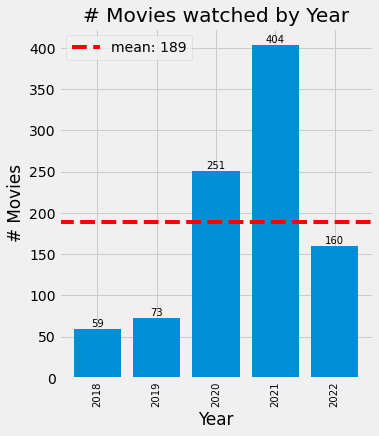

In [35]:
# Plot all watched by year
x = df_all_watched.index
y = df_all_watched[('Title','count')]

_, ax = plt.subplots(figsize=(len(x),6))
add_ticks_vbarplot(x, y, ax)     

plt.title('# Movies watched by Year')
plt.xlabel('Year')
plt.ylabel('# Movies')

label = 'mean: ' + str(int(y.mean())) # set label to print mean value
ax.axhline(y=y.mean(), color='red', ls='--', label=label)

plt.legend()
plt.show()

In [36]:
# Percentage difference from previous year
pct_col = 'pct (%)'

df_year_change = df_diff_watched_year.copy()
df_year_change = df_year_change.diff().fillna(0).astype(int)

df_year_change[pct_col] = pd.DataFrame(df_all_watched.pct_change()[('Title','count')]*100)
df_year_change[pct_col] = df_year_change[pct_col].fillna(0).astype(int)
df_year_change.drop(['Genre','Title'], axis=1, inplace=True)

df_year_change.style.background_gradient(cmap='RdBu', subset=pct_col, axis=0)

In [37]:
# Difference between years

# Get values from all movies watched
values = list(df_all_watched.iloc[:,-1])
# List difference between years
l = [i-j for i in values for j in values if i != j]
# Initialize 
results = []
j = 0

# Fill list 
for i in range(len(years)):
    temp_list = l[j:j+4] # get 4 values each time (doesn't contain difference between itself)
    temp_list.insert(i,0) # insert difference between the value itself =0
    results.append(temp_list) # append to list
    j += 4 # add step 

# Convert to dataframe
df_year_heatmap = pd.DataFrame(results, index=years, columns=years)
df_year_heatmap.style.background_gradient(cmap='RdBu', axis=None)

In [38]:
# All (movies + documentaries) watched per day in year
[
    [
        movies_per_day(df_diff_watched_year, year)
    ] for year in years
];

0.16 movies per day in 2018
0.2 movies per day in 2019
0.69 movies per day in 2020
1.11 movies per day in 2021
1.24 movies per day in 2022


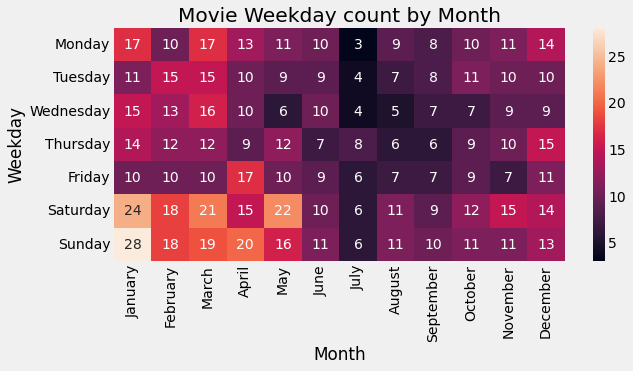

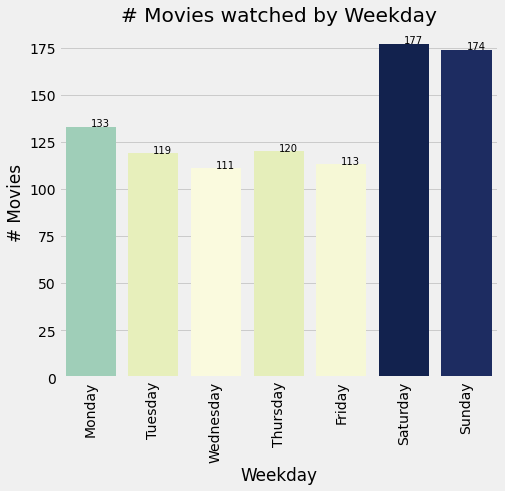

37% of the movies were watched on the weekend!


In [39]:
# Overview
plot_heatmap(df, 'Weekday', None)
plot_weekday_bar(df, None)

## Top IMDb 250 Movies

In [40]:
# Get list of IMDb top 250 movies
moviedb = IMDb()

top250 = moviedb.get_top250_movies()
# Top 250 movies dataframe
df_top250 = pd.DataFrame([[movie.get('title'), movie.get('year')] for movie in top250], columns=['Title','Year'])
# Merge to get top 250 movies seen since the beginning of data get
df_top250_seen = df[['Title','Year','Timestamp']].merge(df_top250, on=['Title', 'Year'])

# Total IMDb top 250 movies watched since 'year'
print('IMDb top 250 movies watched since ' + str(years[0]) + ': ' + str(df_top250_seen.shape[0]))

IMDb top 250 movies watched since 2018: 75


In [41]:
df_top250_seen['DateYear'] = df_top250_seen['Timestamp'].dt.year
gb_top250_seen = df_top250_seen.groupby('DateYear').agg({'Title':['count','; '.join]})

show_all(gb_top250_seen)

## By Year 

In [42]:
# Set by year dataframe
cols = ['Title','Year','Runtime','Genre','Director','imdbRating','Date','Time']

df_byear = df[cols].copy()

In [43]:
# All by month/year
ct_month_year = crosstab_by_year(df_byear).droplevel('Month', axis=1)
ct_month_year.style.background_gradient(axis=1, subset=ct_month_year.columns[:-1]) # evaluate by year

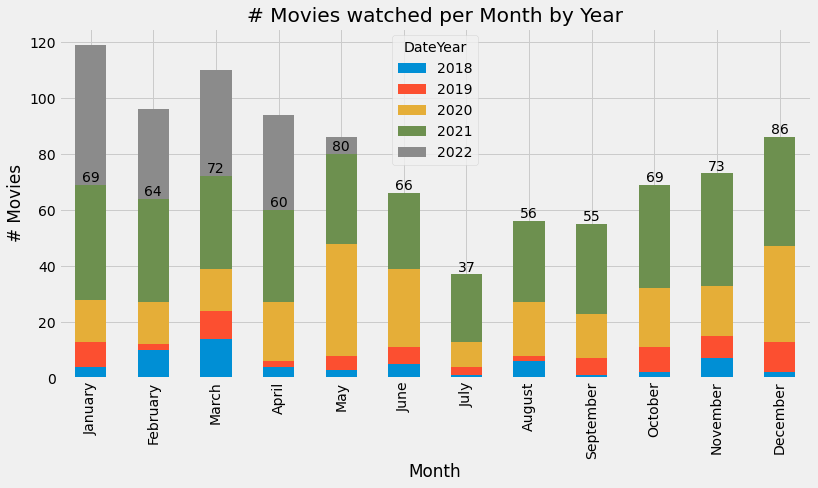

In [44]:
# Plot movies watched each month by year
plot_mby = crosstab_by_year(df_byear).droplevel('Month', axis=1).drop('', axis=1).T
ax = plot_mby.drop('All', axis=1).plot(kind='bar', stacked=True, figsize=(len(plot_mby),6));

ax.bar_label(ax.containers[len(years)-2])

plt.title('# Movies watched per Month by Year')
plt.xlabel('Month')
plt.ylabel('# Movies')

plt.show()

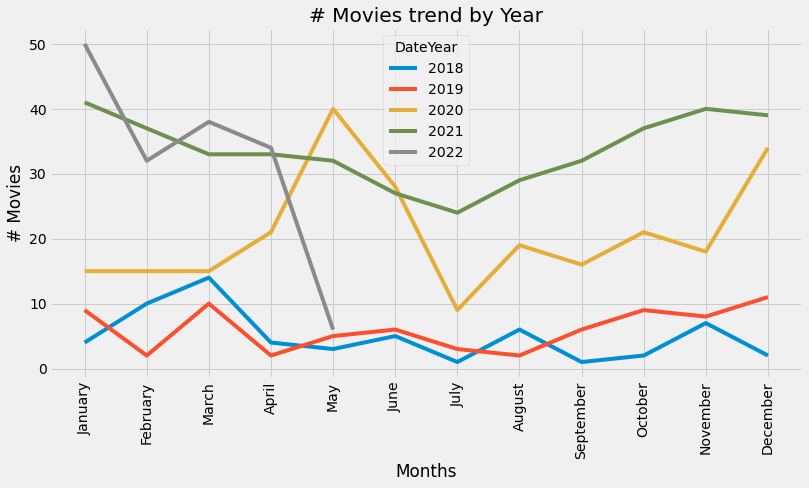

In [45]:
# Plot watched movies trend by year
plot_ty = crosstab_by_year(df_byear).droplevel('Month', axis=1).drop('All').drop('', axis=1).T
plot_ty.iloc[:,-1] = plot_ty.iloc[:,-1].replace(0, np.nan) # replace 0 values to nan values from months yet to come, for figure purposes

# Plot
ax = plot_ty.plot(figsize=(len(plot_ty),6));

ax.xaxis.set_ticks(np.arange(len(plot_ty.index)))
ax.xaxis.set_ticklabels(plot_ty.index)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90) 

plt.title('# Movies trend by Year')
plt.xlabel('Months')
plt.ylabel('# Movies')
    
plt.show()

In [46]:
# Difference from previous year (of movies & documentaries watched)
ct_month_year_diff = crosstab_by_year(df_byear).diff().drop('All').fillna(0).astype(int)
ct_month_year_diff = ct_month_year_diff.droplevel('Month', axis=1)
ct_month_year_diff.style.background_gradient(cmap='RdBu', subset=ct_month_year_diff.columns[:-1], axis=None) # evaluate by year

2018 



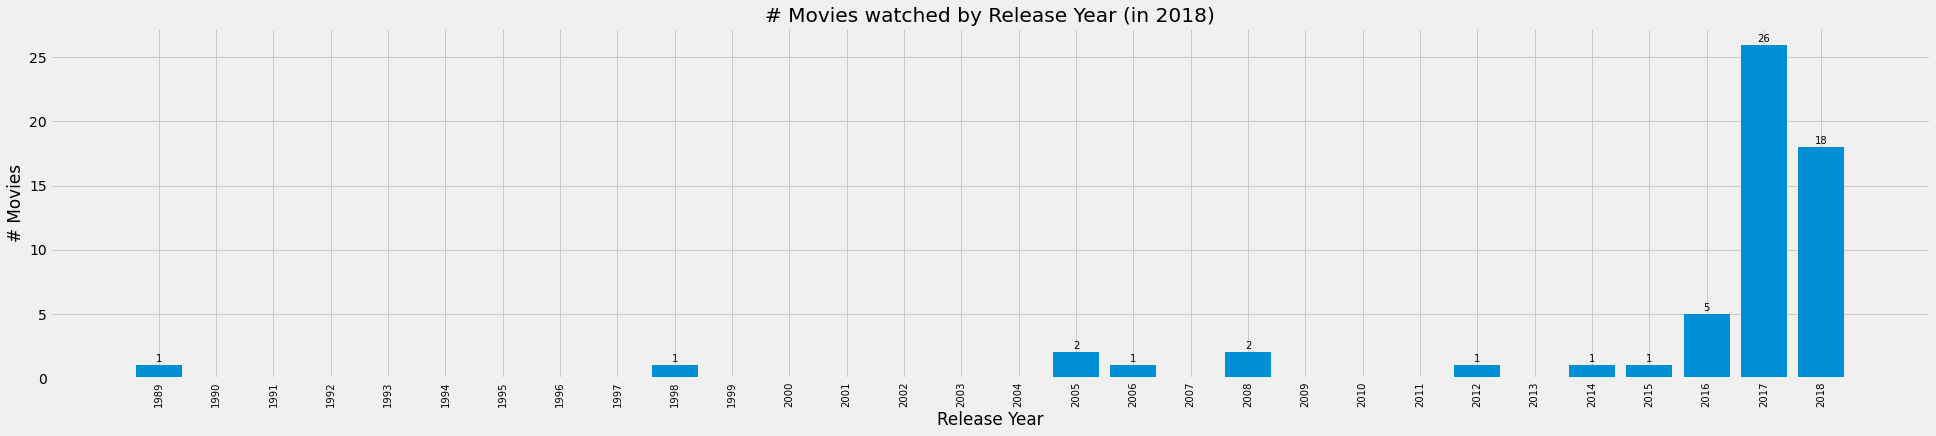

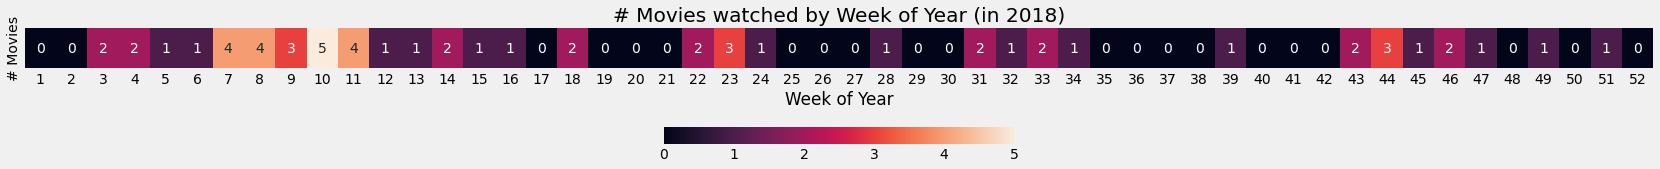

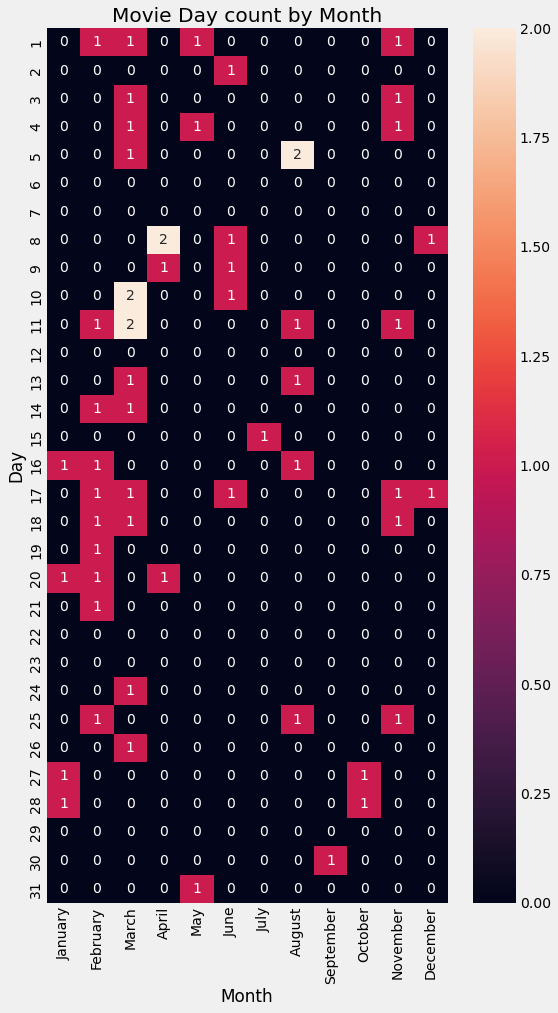

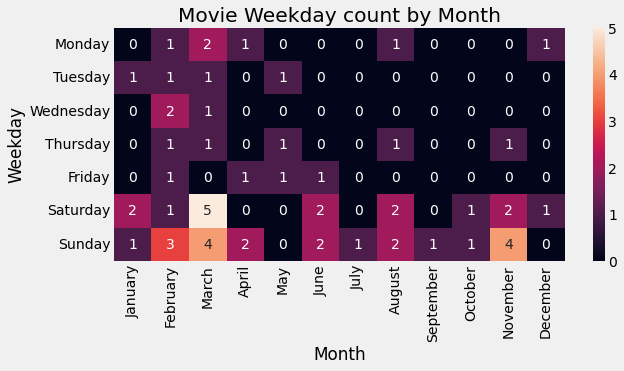

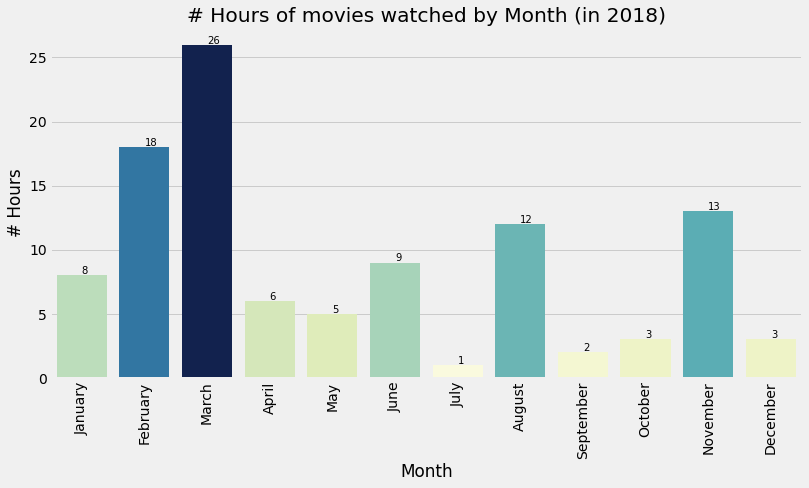

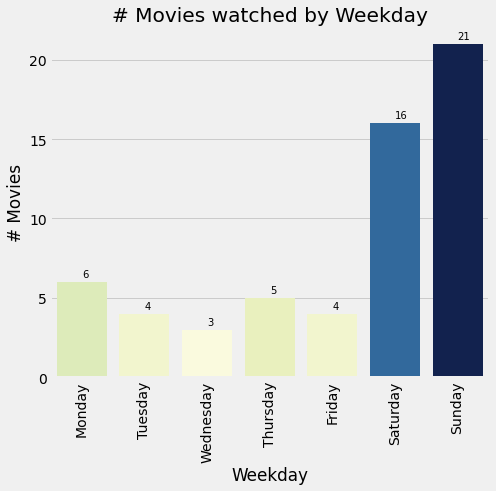

62% of the movies were watched on the weekend!



2019 



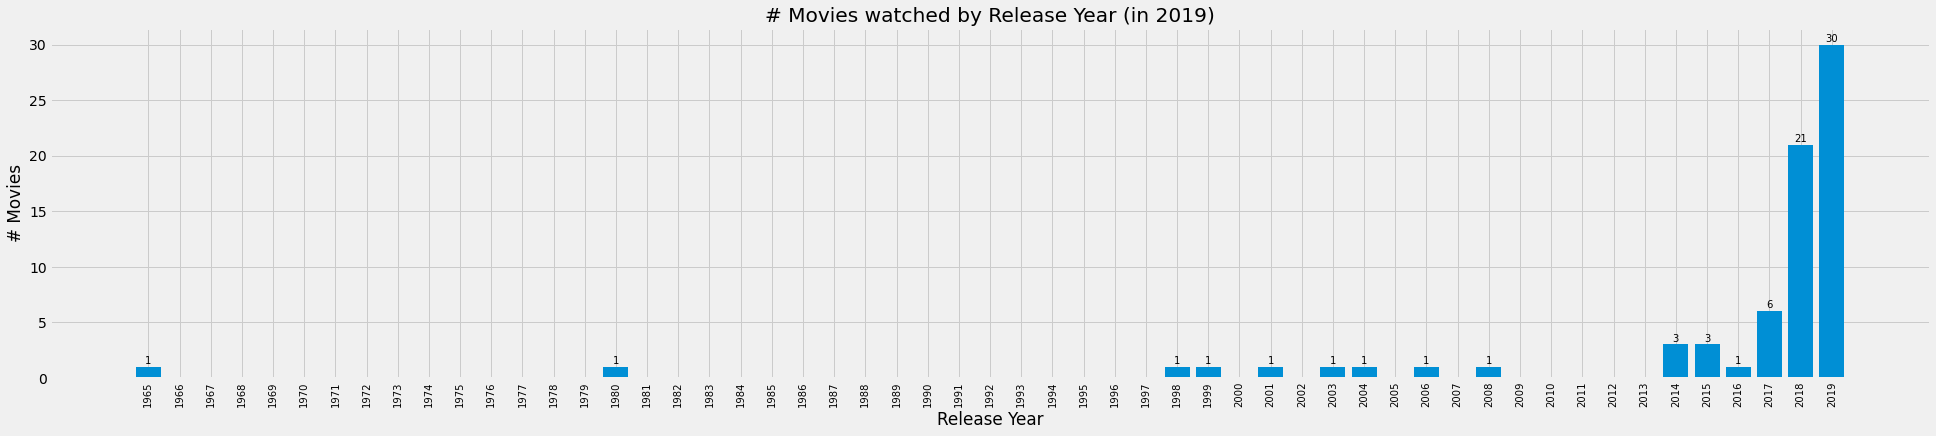

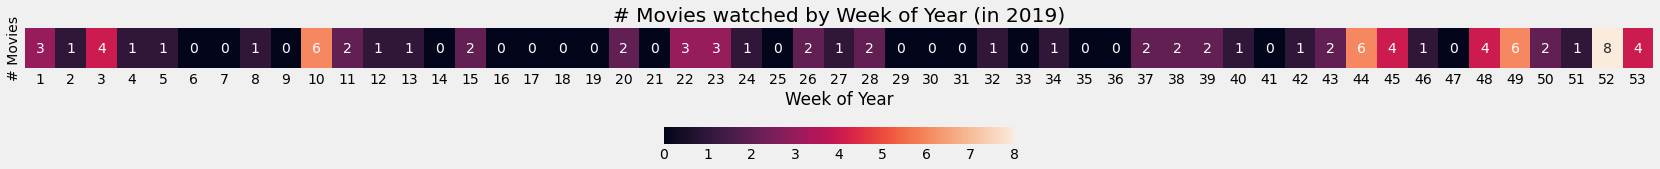

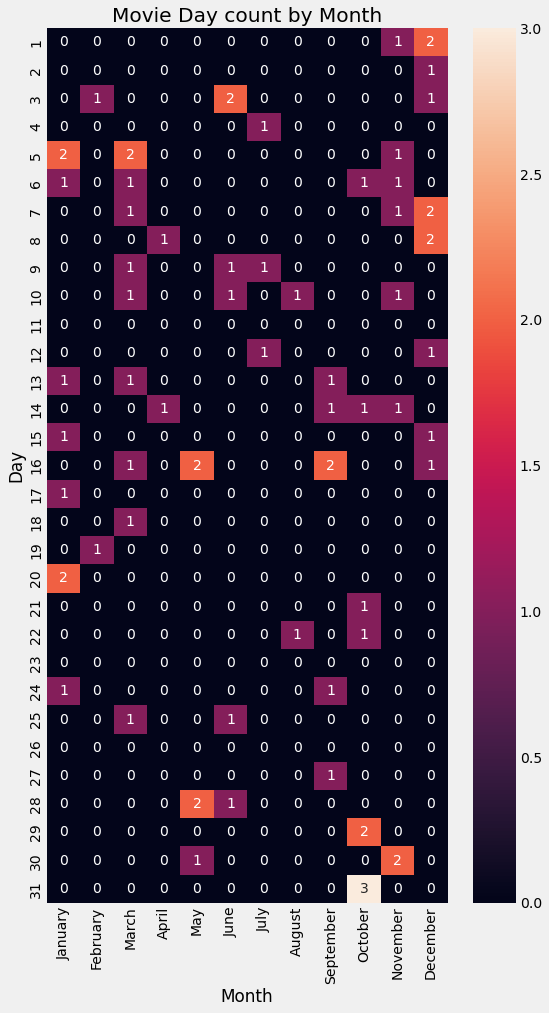

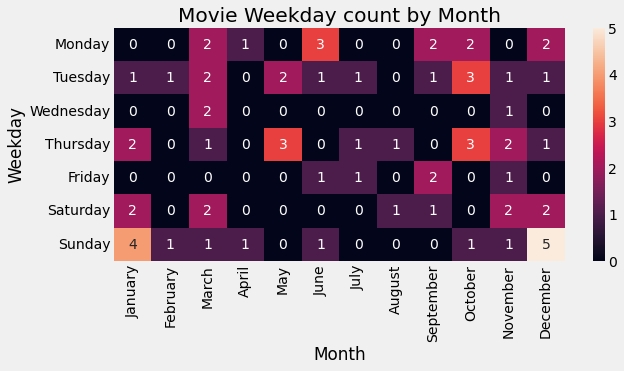

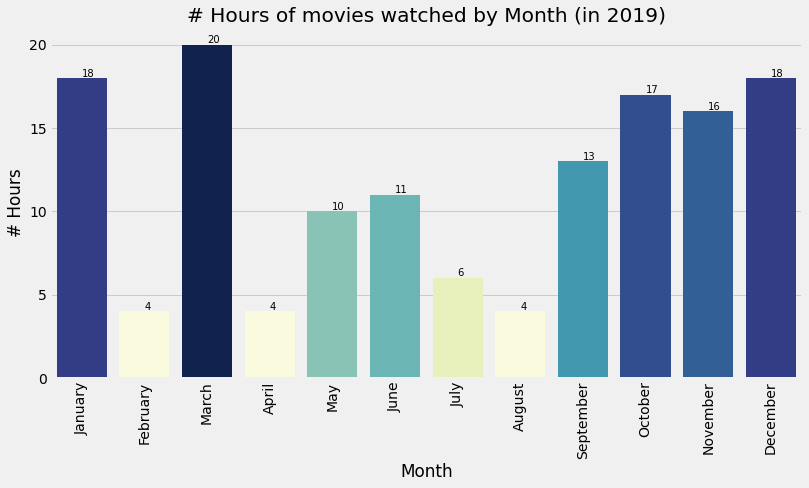

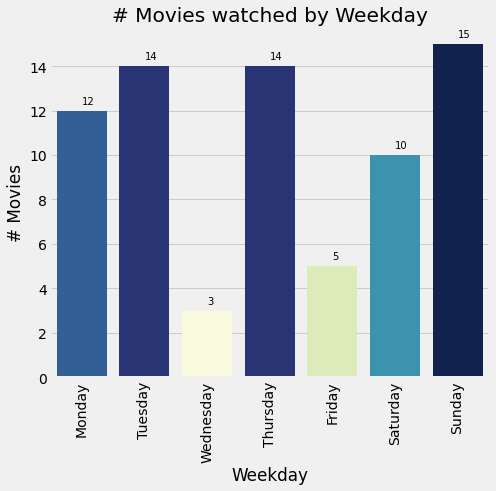

34% of the movies were watched on the weekend!



2020 



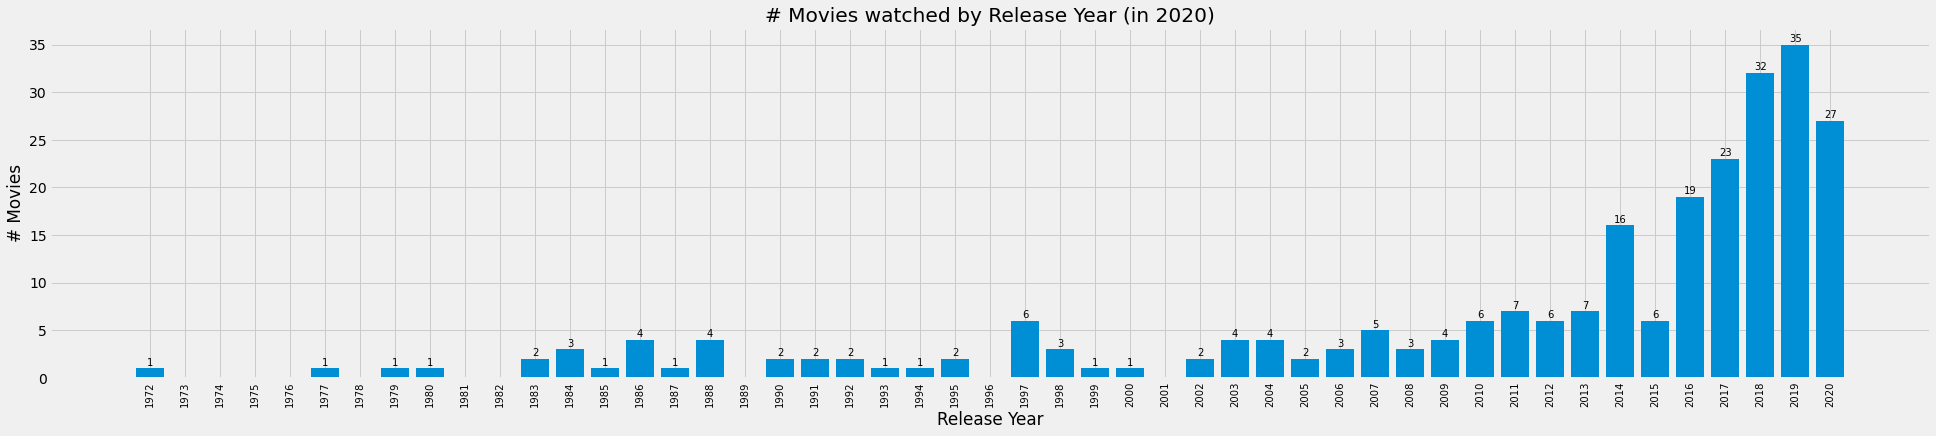

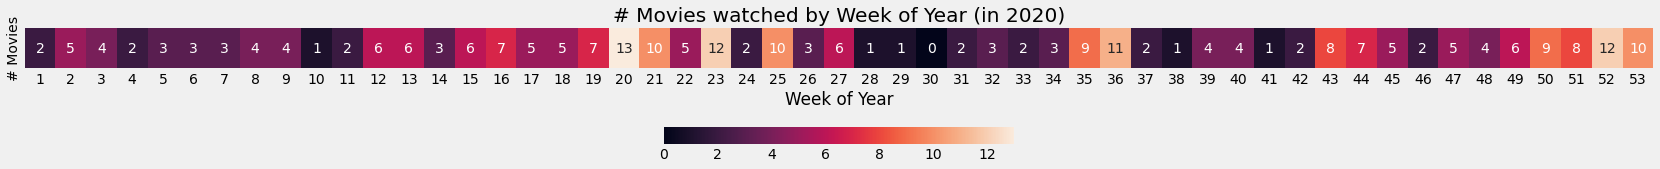

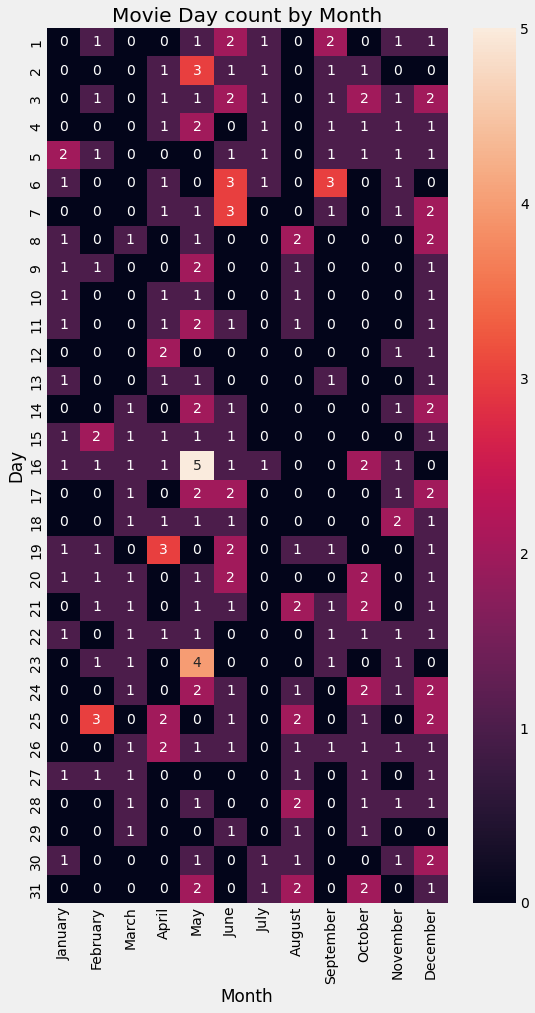

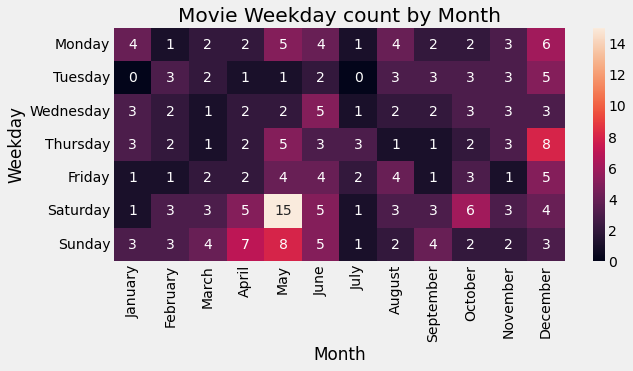

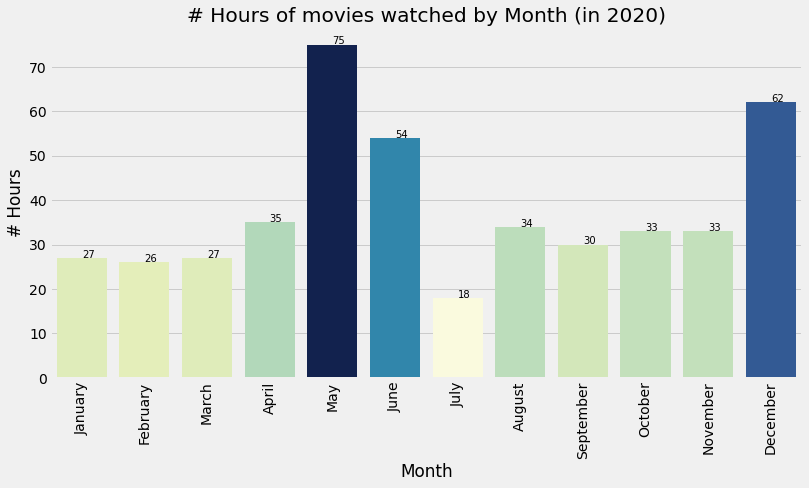

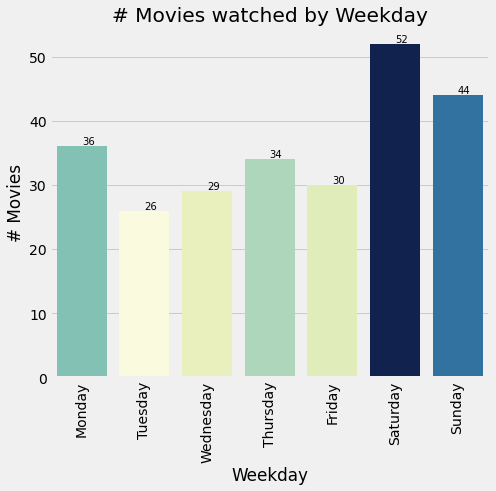

38% of the movies were watched on the weekend!



2021 



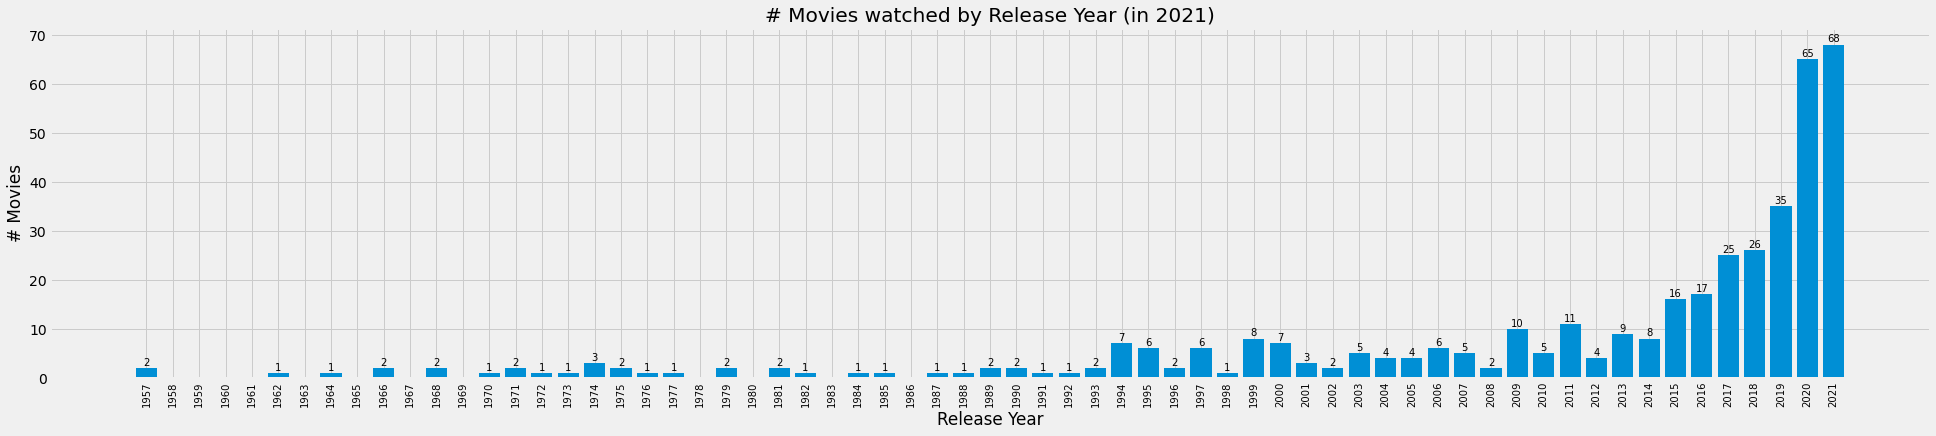

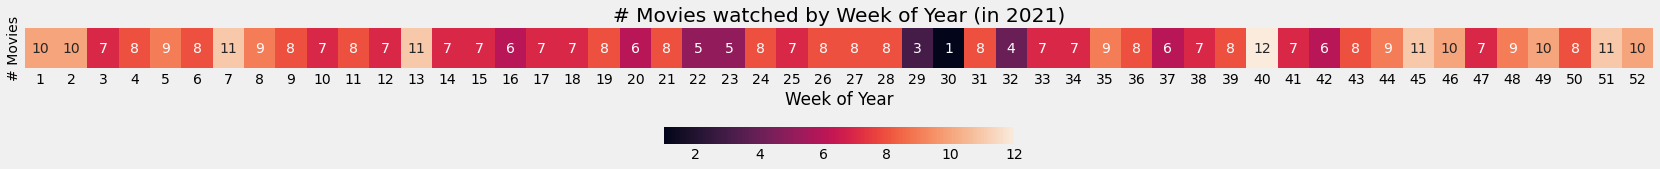

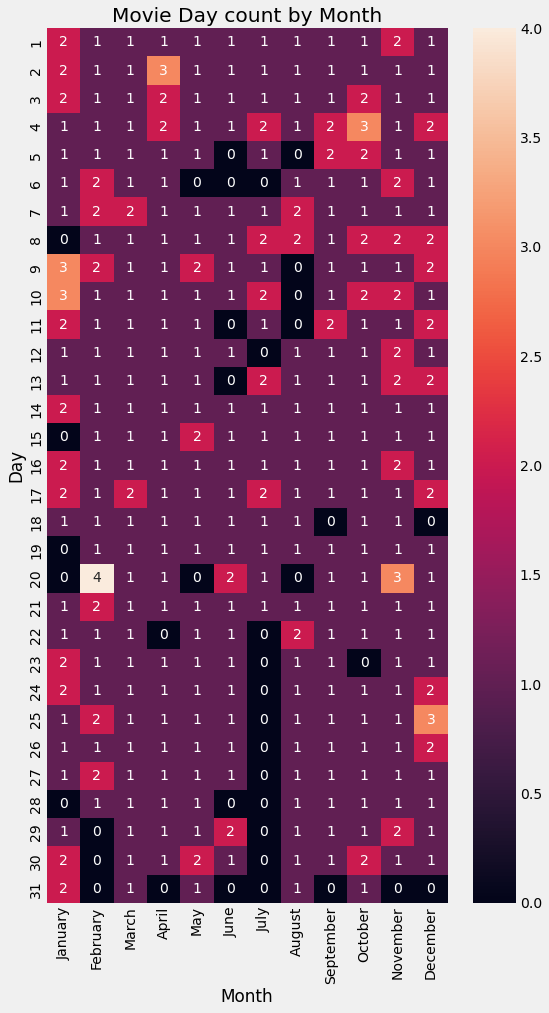

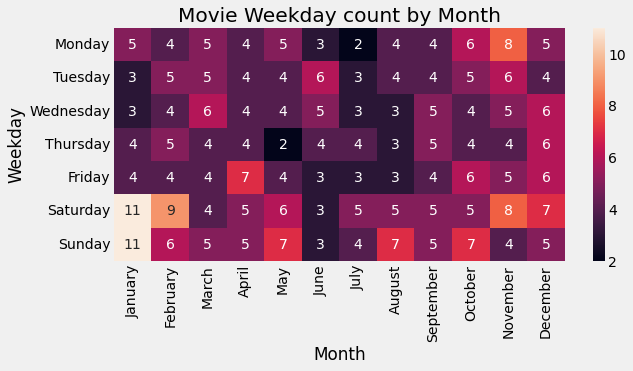

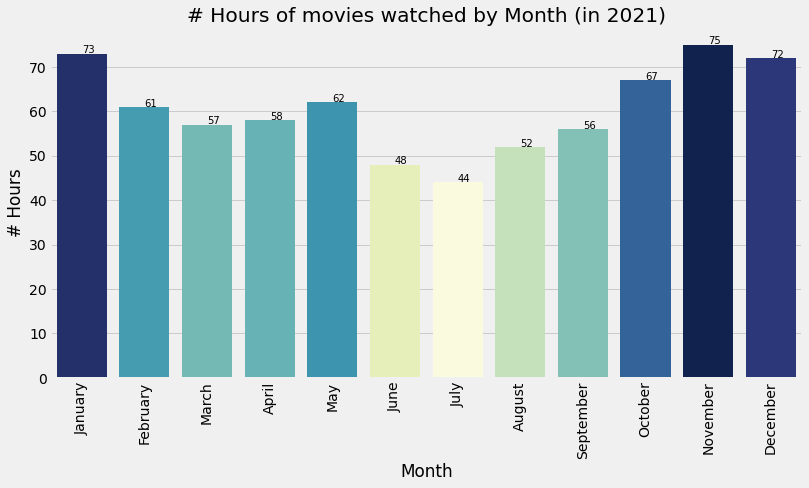

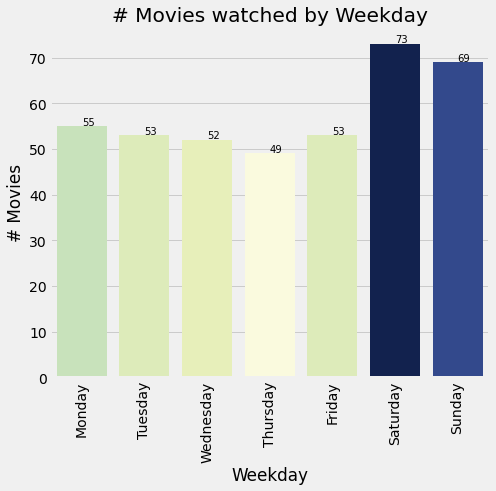

35% of the movies were watched on the weekend!



2022 



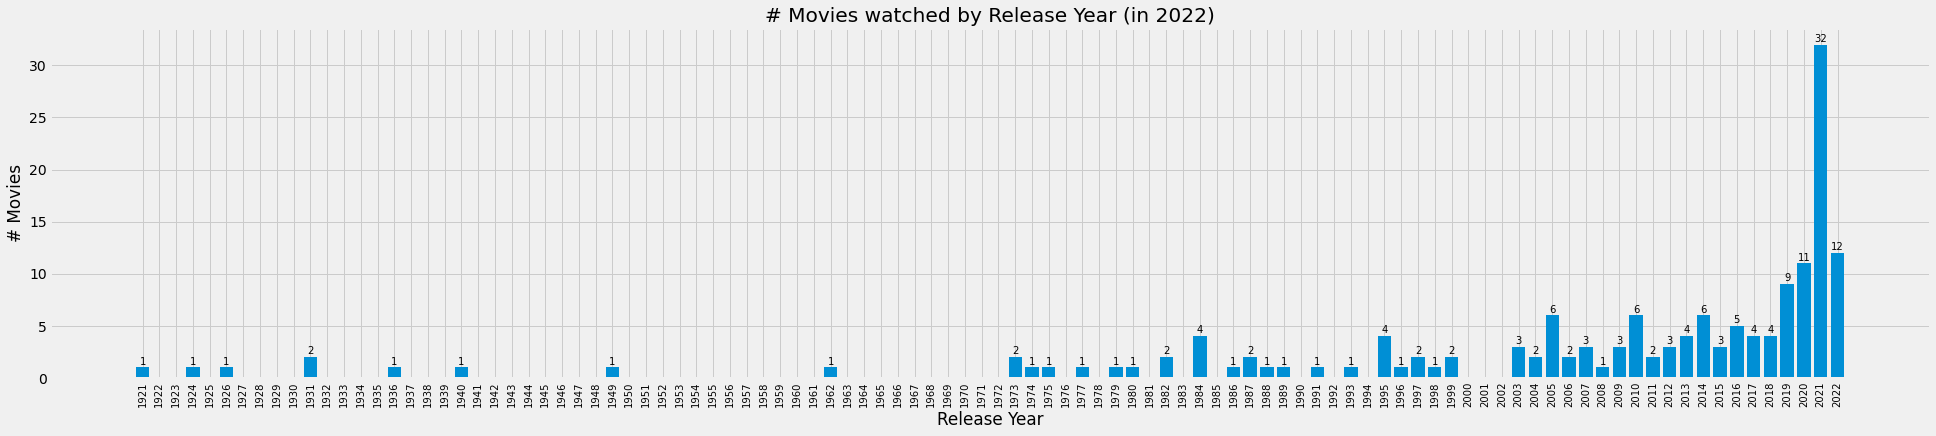

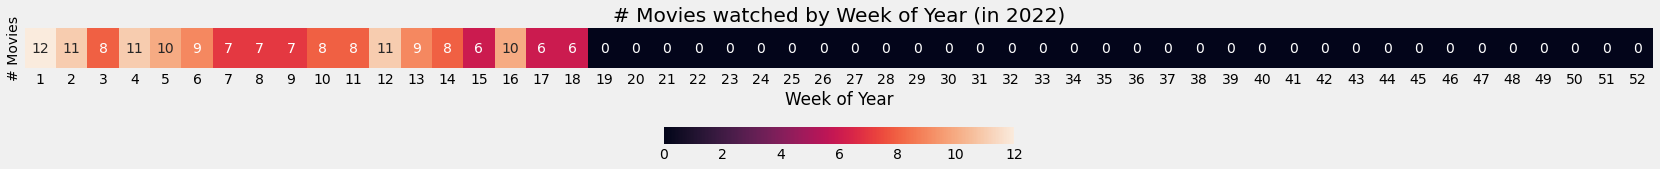

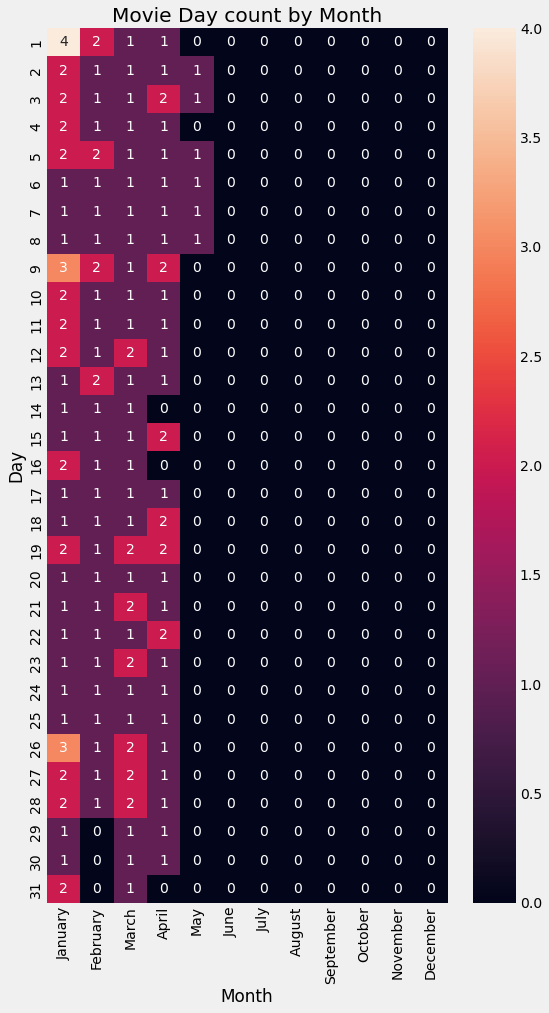

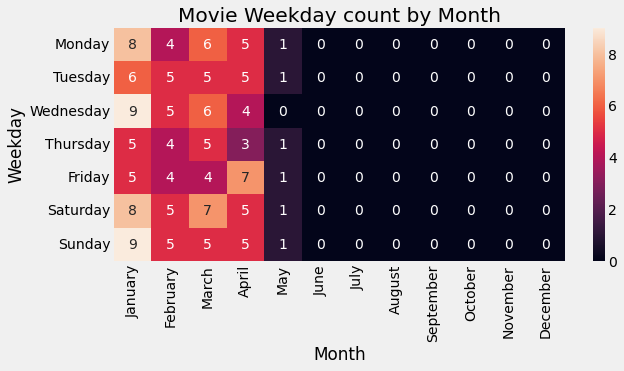

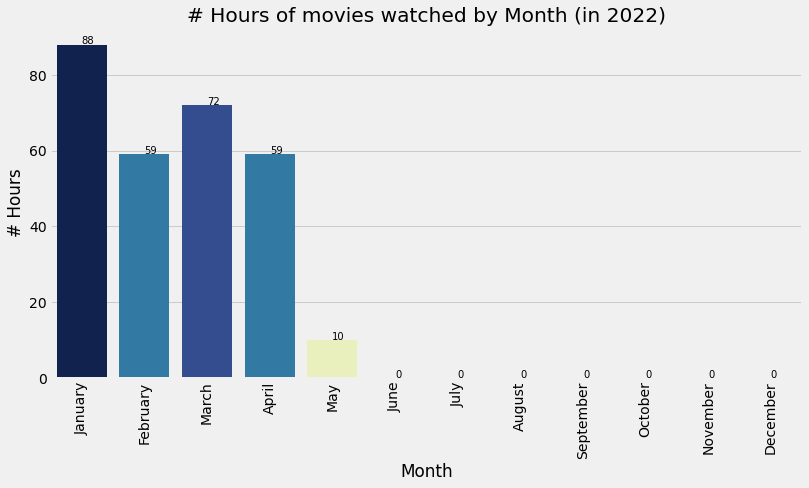

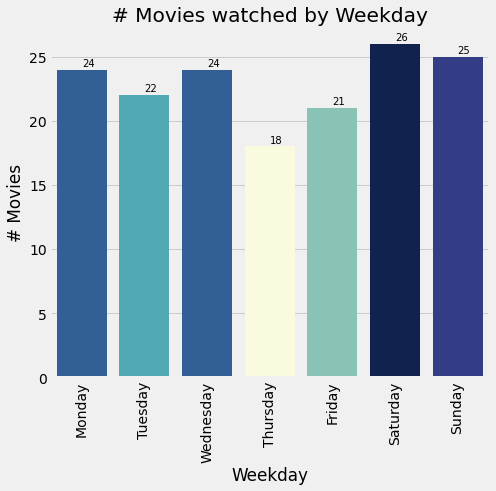

31% of the movies were watched on the weekend!





In [47]:
# Get overview by year (since 2020)
df_top_movies = df_byear[~df_byear['Genre'].str.contains('Documentary')][~df_byear.duplicated(['Title','Year'], keep='first')]

[
    [print(year,'\n'), 
     # remove movies watched more than once for this view
     show_all(df_top_movies[df_top_movies['Date'].dt.year == year].nlargest(N, 'imdbRating', keep='all')),
          
     plot_movie_trend(df_byear, year),
     
     plot_week_bar(df_byear, year),
     plot_heatmap(df_byear, 'Month', year),
     plot_heatmap(df_byear, 'Weekday', year),
     
     plot_hour_month_bar(df_byear, year),
     plot_weekday_bar(df_byear, year), 

     plt.show(),
     print('\n\n')] 
    for year in years
];

In [48]:
# Calendar - month days
first_year = str(df_byear['Date'].dt.year.min())
calendar = pd.DataFrame({'date': pd.date_range(first_year+'-01', now, freq='M')})
calendar['daysinmonths'] = calendar['date'].apply(lambda t: pd.Period(t, freq='S').days_in_month)

print('Days without any movie watched\n')
[
    [
        skip_days(df, calendar, year),
    ] 
    for year in years
];

Days without any movie watched

2018
By month: [27, 18, 19, 27, 28, 25, 30, 26, 29, 29, 23, 29]
Total: 310/365
84 %


2019
By month: [24, 26, 22, 28, 28, 25, 28, 29, 25, 25, 23, 23]
Total: 306/365
83 %


2020
By month: [17, 17, 16, 14, 7, 11, 22, 17, 17, 16, 13, 5]
Total: 172/366
46 %


2021
By month: [5, 0, 0, 1, 2, 5, 12, 5, 1, 1, 0, 2]
Total: 34/365
9 %


2022
By month: [0, 0, 0, 2]
Total: 2/120
1 %




In [49]:
# Days wiht most movies watched
df_byear = explode_date(df_byear)
df_byear_movies = df_byear.groupby('Date').agg({'WeekdayName':'unique', 
                                              'Title':['count','; '.join], 
                                              'Time':list, 
                                              'Runtime':[list,'sum']})

df_byear_movies[('WeekdayName','unique')] = df_byear_movies[('WeekdayName','unique')].map(lambda x : x[0])
show_all(df_byear_movies[df_byear_movies['Title']['count'] > 2]) # days with more than 2 movies watched

In [50]:
# Best movies watched (based on imdbRating) by month
cols = ['Year','Month','MonthName','Title','imdbRating','DateYear']
SHOW = 3 # show how many movies

df_movies_by_month = df_byear[~df_byear.duplicated(['Title','Year'], keep='first')][cols]
df_movies_by_month = df_movies_by_month.groupby(['DateYear','Month','MonthName'], as_index=False)

df_best_movies_by_month = df_movies_by_month.apply(lambda x: x.nlargest(SHOW, 'imdbRating', keep='last'))
df_best_movies_by_month = pd.crosstab(index=df_best_movies_by_month['DateYear'], 
                                      columns=[df_best_movies_by_month['Month'], df_best_movies_by_month['MonthName']],
                                      values=df_best_movies_by_month['Title'],
                                      aggfunc=' * '.join)

df_best_movies_by_month = df_best_movies_by_month.droplevel('Month', axis=1)
show_all(df_best_movies_by_month)

In [51]:
# Average movie rating by Month
df_best_month = df_byear[~df_byear.duplicated(['Title','Year'], keep='first')][cols]
df_best_month = pd.crosstab(index=df_best_month['DateYear'], 
                            columns=[df_best_month['Month'], df_best_month['MonthName']], 
                            values=df_best_month['imdbRating'], 
                            aggfunc='mean') #.round(1)

df_best_month = df_best_month.droplevel('Month', axis=1)

df_best_month.style.background_gradient(axis=1).set_precision(1) # evaluate by year

---

## Recent trend

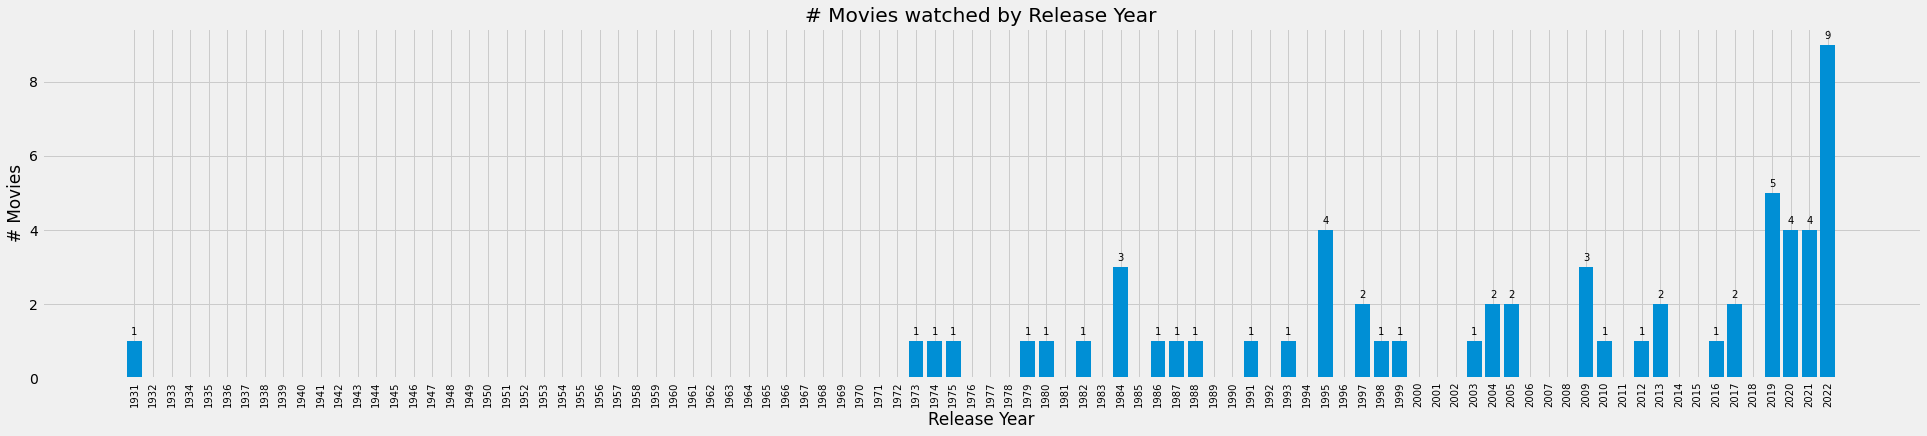

In [52]:
# Movies by Release Year (recent trend)
LAST = 60 # trakt shows last 60 movies
df_trend = df.tail(LAST)
plot_trend = df_trend.groupby(by='Year').agg({'Title': 'count'}).reset_index()

plot_movie_trend(plot_trend)

In [53]:
# Last movies watched
df_trend.groupby(['Year','Title']).agg({'imdbRating':'mean', 'Director':' '.join}).style.background_gradient(subset='imdbRating').set_precision(1)

In [54]:
## Any rewatched movie in the previous 60?
#df_trend[df_trend[['Title','Year','Director']].duplicated(keep=False)]

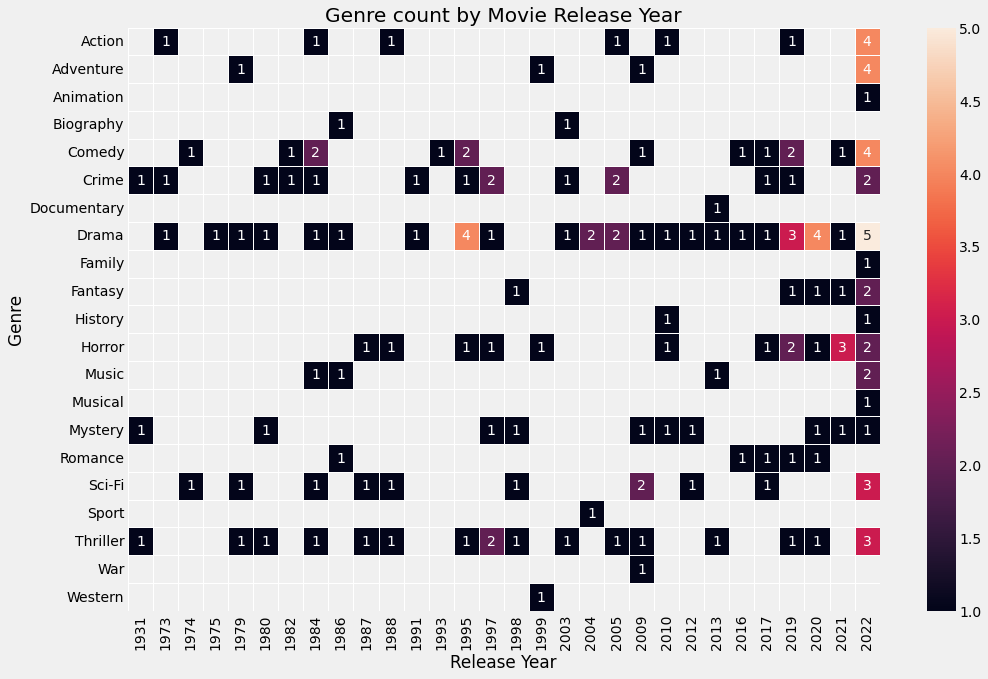

In [55]:
# Movies by Genre per Release Year (recent trend)
cols = ['Title','Year','Genre','imdbRating']

df_genre_year = df_trend[cols].copy()
df_genre_year['Genre'] = df_genre_year['Genre'].str.split(',').apply(lambda x: [e.strip() for e in x])

plot_last_genres = explode(df_genre_year, ['Genre'])
plot_last_genres = plot_last_genres.groupby(['Year','Genre']).agg({'Title':'count'}).sort_values(['Year','Title'], ascending=False)
plot_ct_last_genres = plot_last_genres.unstack().T.reset_index().set_index('Genre').drop(['level_0'], axis=1)

# Plot
xsize = len(plot_ct_last_genres.columns) // 2
ysize = len(plot_ct_last_genres.index) // 2

_, ax = plt.subplots(figsize=(xsize,ysize))
sns.heatmap(plot_ct_last_genres, annot=True, linewidths=.5, ax=ax)
ax.set_xticklabels(plot_ct_last_genres.columns, rotation=90) 

plt.title('Genre count by Movie Release Year')
plt.xlabel('Release Year');

In [56]:
# Movies by Genre (recent trend)
df_plot_genres = df_genre_year.copy()

plot_last_genres = explode(df_plot_genres, ['Genre'])
plot_last_genres = plot_last_genres.groupby(['Genre']).agg({'Title':'count'}).sort_values(['Title'], ascending=False)
plot_last_genres

Title
Genre             
Drama           36
Thriller        19
Comedy          17
Crime           16
Horror          15
Sci-Fi          13
Action          10
Mystery         10
Adventure        7
Fantasy          6
Music            5
Romance          5
History          2
Biography        2
Musical          1
Family           1
Documentary      1
Sport            1
Animation        1
War              1
Western          1

In [57]:
# Movies by Director (recent trend )
gb_trend = df_trend.groupby('Director').agg({'Title':['; '.join,'count'], 'imdbRating':'mean'})
gb_trend = gb_trend.sort_values([('Title','count'), ('imdbRating','mean')], ascending=False).head(N)
gb_trend[('imdbRating','mean')] = gb_trend[('imdbRating','mean')].round(1)

show_all(gb_trend)

### Last month stats

In [58]:
# Get year and month
year = now.year

if now.month == 1:
    year = year-1
    last_month = 12
else:
    last_month = now.month-1

# Filter dataset and create last_month dataframe
df_last_month = df[(df['Date'].dt.year == year) & (df['Date'].dt.month == last_month)].copy()

In [59]:
# Movies watched last month
print('Movies watched last month: ' + str(len(df_last_month)))

Movies watched last month: 34


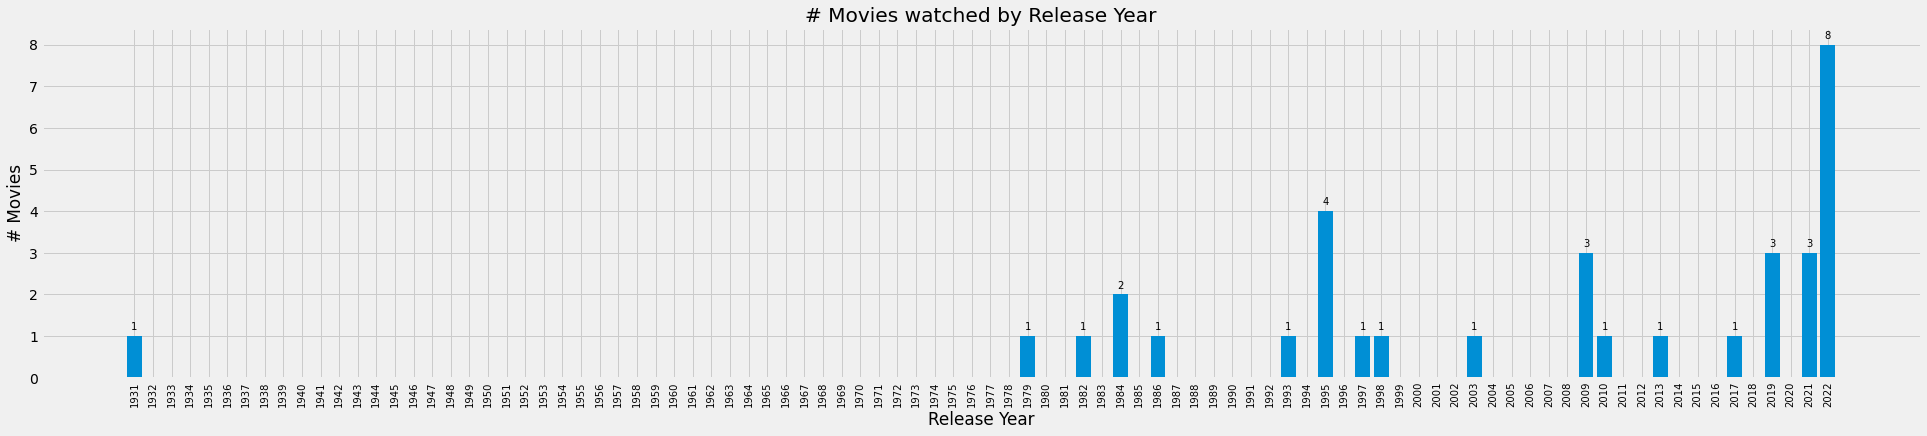

In [60]:
# Plot last month watched movies' release year trend
plot_last_month = df_last_month.groupby(by='Year').agg({'Title': 'count'}).reset_index()
plot_movie_trend(plot_last_month)

In [61]:
# Set last month genre dataframe
cols = ['Title','Genre','imdbRating']

df_last_genres = df_last_month[cols].copy()
df_last_genres['Genre'] = df_last_genres['Genre'].str.split(',').apply(lambda x: [e.strip() for e in x])
df_last_genres = explode(df_last_genres, ['Genre'])

In [62]:
BEST = 1
df_last_genres_best = df_last_genres.groupby(['Genre','Title']).mean().sort_values(['Genre','imdbRating'], ascending=False)
df_last_genres_best = df_last_genres_best.groupby(level=0, as_index=False).apply(lambda x: x.nlargest(BEST, 'imdbRating', keep='all')).reset_index(level=0, drop=True)
show_all(df_last_genres_best)

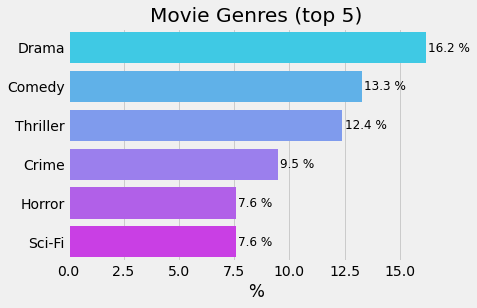

In [63]:
# Plot last month watched movies' top genres trend
plot_last_genres = df_last_genres['Genre'].value_counts(normalize=True)
plot_last_genres = pd.DataFrame(plot_last_genres)
plot_last_genres.rename(columns={'Genre':'Pct'}, inplace=True)

TOP = 5
plot_last_genres = plot_last_genres.nlargest(TOP, 'Pct', keep='all')
plot_last_genres['Pct'] = plot_last_genres['Pct'].mul(100).round(1)

x = plot_last_genres['Pct']
y = plot_last_genres.index

sns.barplot(x, y, orient='h', palette=sns.color_palette('cool'))
plt.title('Movie Genres (top ' + str(TOP) + ')')
plt.xlabel('%')

for i, rate in enumerate(x):
    plt.text(rate+0.1, i+0.1, str(rate) + ' %', fontdict={'fontsize':12})
    #plt.text(ratings[0]+0.5, i+0.25, f"{counts:>5} movies")

plt.show()

In [64]:
# Set last month release year dataframe
cols = ['Title','Year']

df_last_release = df_last_month[cols].copy()
df_last_release['Decade'] = df_last_release['Year'].astype(int)//10*10 # convert to decade

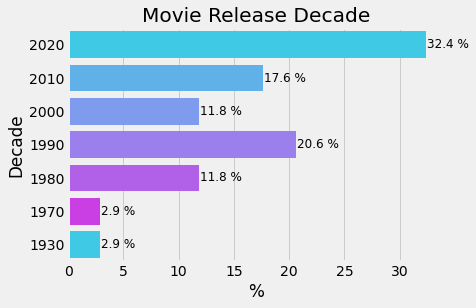

In [65]:
# Plot last month watched movies' top genres trend
plot_last_release = df_last_release['Decade'].value_counts(normalize=True)
plot_last_release = pd.DataFrame(plot_last_release)
plot_last_release = plot_last_release.reset_index().sort_values('index', ascending=False)
plot_last_release.rename(columns={'Decade':'Pct', 'index':'Decade'}, inplace=True)
plot_last_release['Pct'] = plot_last_release['Pct'].mul(100).round(1)
plot_last_release.set_index('Decade', inplace=True)

x = plot_last_release['Pct']
y = plot_last_release.index.astype(str)

sns.barplot(x, y, orient='h', palette=sns.color_palette('cool'))
plt.title('Movie Release Decade')
plt.xlabel('%')

for i, rate in enumerate(x):
    plt.text(rate+0.1, i+0.1, str(rate) + ' %', fontdict={'fontsize':12})

plt.show()

---

## Timestamp

In [66]:
# Setup timestamp here - to be used later
cols = ['Title','Year','Rated','Genre','Timestamp','Date','Time']
df_timestamp = df[cols].copy() 

explode_date(df_timestamp)
df_timestamp['Hour'] = df_timestamp['Timestamp'].dt.hour
df_timestamp['Minute'] = df_timestamp['Timestamp'].dt.minute

# https://stackoverflow.com/questions/62915974/pandas-group-by-time-interval-5min-10min-1day-1year-and-count-amount-of-ent
period = '15Min'
# divide hour into blocks of x minutes
df_timestamp['Period'] = pd.DataFrame(df_timestamp['Timestamp'].dt.floor(period))['Timestamp'].dt.minute

In [67]:
## Last watched movies timestamp
df_last_hour = df_timestamp.tail(LAST).copy()
ct_last_hour = pd.crosstab([df_last_hour['Weekday'], df_last_hour['WeekdayName']], df_last_hour['Hour'])
ct_last_hour = ct_last_hour.droplevel(0)

ct_last_hour.style.background_gradient(axis=None) # all values

In [68]:
# Create 24h range
range24 = np.arange(24)

# Analysis by hour of day
ycol = df_timestamp['Hour']

In [69]:
# Movies watched by hour per Weekday
xcol = [df_timestamp['Weekday'], df_timestamp['WeekdayName']]

ct_week_hour = pd.crosstab(xcol, ycol)
ct_week_hour = ct_week_hour.droplevel(0)

ct_week_hour.style.background_gradient(axis=1) # evaluate by weekday

In [70]:
# Movies watched by hour per Month
xcol = [df_timestamp['Month'], df_timestamp['MonthName']]

ct_month_hour = pd.crosstab(xcol, ycol)
ct_month_hour = ct_month_hour.droplevel(0)

ct_month_hour.style.background_gradient(axis=1) # evaluate by month

In [71]:
# Movies watched complete scenario
xcol = [df_timestamp['Month'], df_timestamp['MonthName'], df_timestamp['Weekday'], df_timestamp['WeekdayName']]

ct_month_week = pd.crosstab(xcol, ycol)
ct_month_week = ct_month_week.droplevel([0,2])

show_all(ct_month_week.style.background_gradient(axis=1))

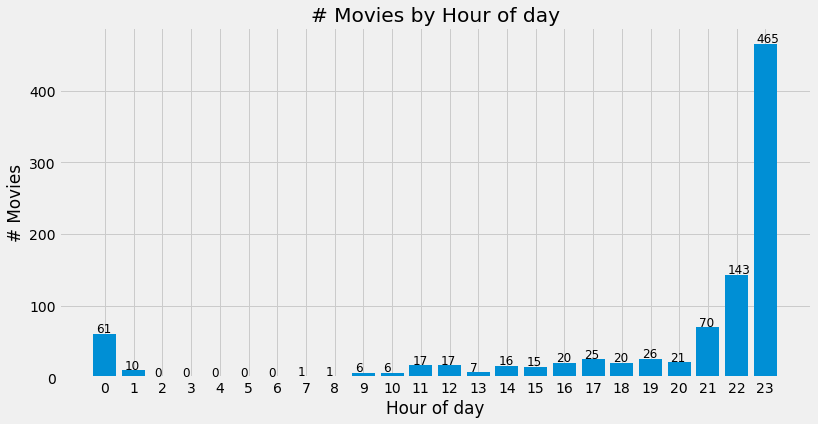

In [72]:
# Movies watched by hour of day (0-24)
plot_hour_day = df_timestamp.groupby('Hour').agg({'Title':'count'})

plot_24 = pd.DataFrame(range24, columns=['Hour']) # from 0 to 23, without missing a hour
plot_24['Title'] = plot_hour_day['Title']
plot_24['Title'] = plot_24['Title'].fillna(0).astype(int)

x = plot_24.Hour
y = plot_24.Title

# Plot
xsize = len(x) // 2

plt.figure(figsize=(xsize,6))
plt.bar(x, y)

plt.xlabel('Hour of day')
plt.ylabel('# Movies')
plt.title('# Movies by Hour of day')

plt.xticks(range24)

for i, rate in enumerate(y):
    plt.text(i-0.3, rate+2, rate, fontdict={'fontsize':12})

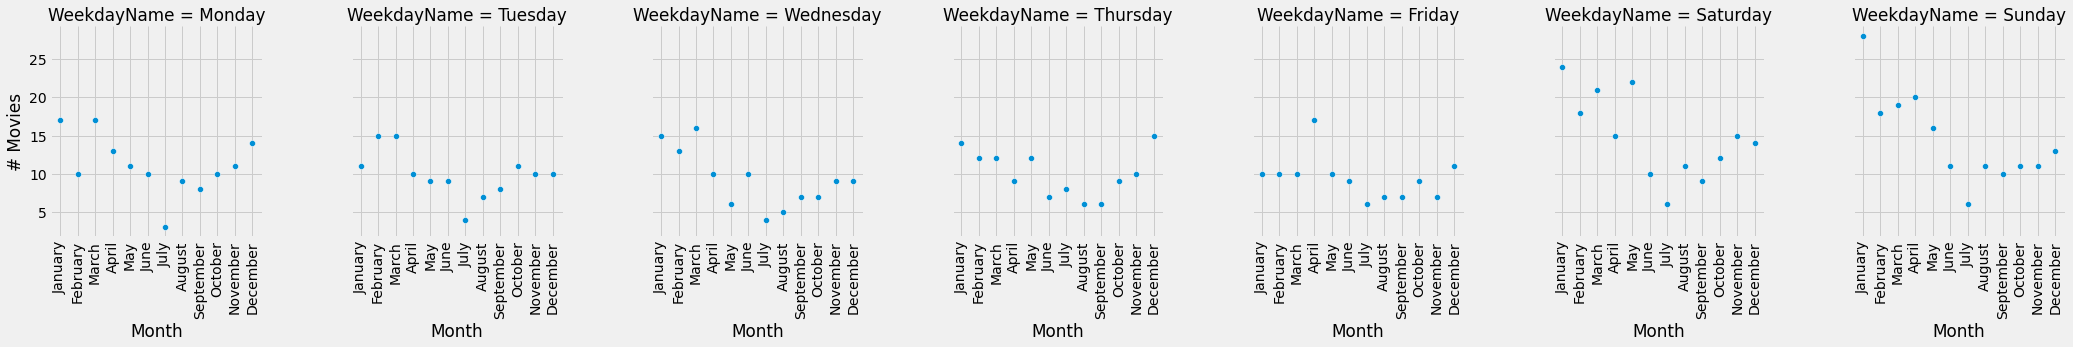

In [73]:
# Movies watched by Weekday / Month
cols = ['Month','MonthName','Weekday','WeekdayName']
gb_timestamp = df_timestamp.groupby(cols).agg({'Title':'count'}).reset_index()

# Plot
g = sns.FacetGrid(gb_timestamp, col="WeekdayName")
g.map(sns.scatterplot, "MonthName", "Title")
g.set_axis_labels("Month", "# Movies")
g.fig.set_figheight(5)
g.fig.set_figwidth(30);

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

2018 



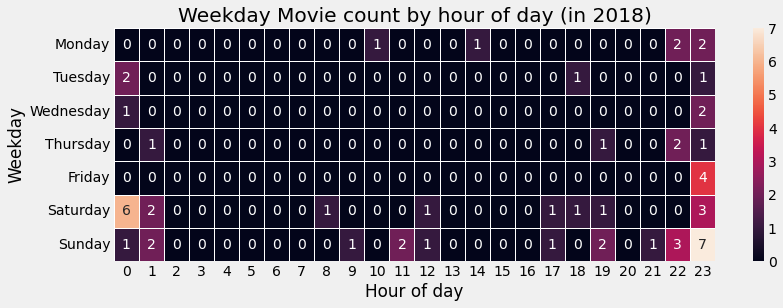



2019 



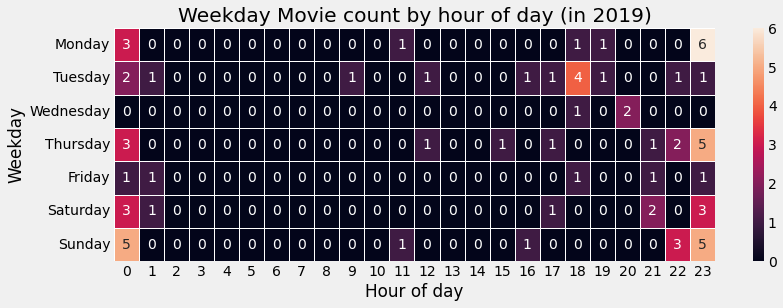



2020 



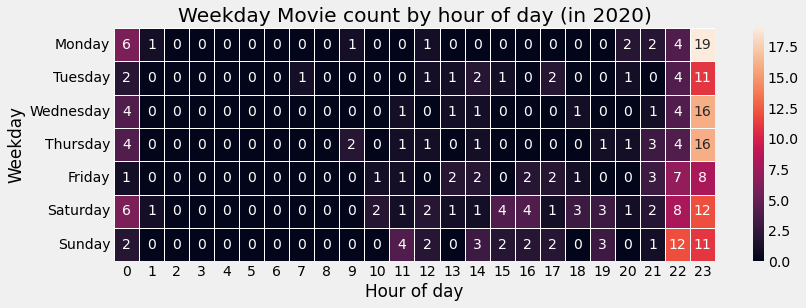



2021 



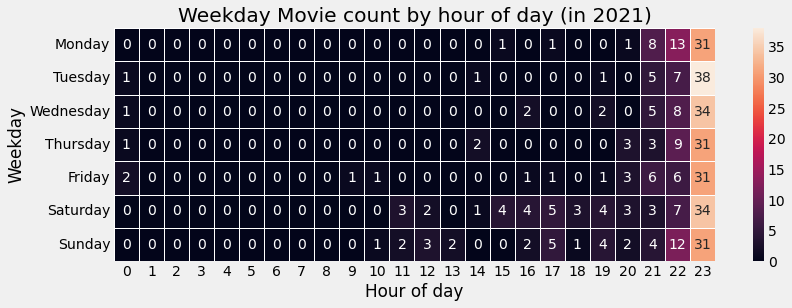



2022 



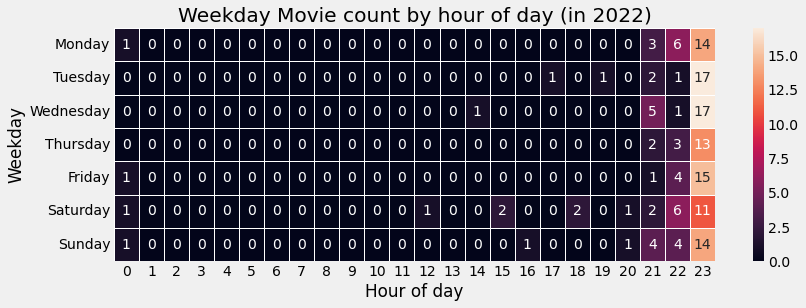

In [74]:
# Get overview by Year
# Create 24 hour dataframe
weekdays = ct_last_hour.index.values # get weekday names ordered from previously created dataframe 
df_24 = pd.DataFrame(0, index=weekdays, columns=range24)
df_24.index.name = 'WeekdayName'
df_24.columns.name = 'Hour'

xsize = len(df_24.columns) // 2

for year in years:
    plot_hour_weekday_year = df_timestamp[df_timestamp['Timestamp'].dt.year == year]
    
    print(year,'\n') 
    plot_hour_weekday_year = pd.crosstab([plot_hour_weekday_year['Weekday'], plot_hour_weekday_year['WeekdayName']], plot_hour_weekday_year['Hour'])
    plot_hour_weekday_year = plot_hour_weekday_year.droplevel(0)
    
    plot_24hour_weekday_year = pd.concat([plot_hour_weekday_year, df_24]).iloc[:7,:].fillna(0).astype(int)
    
    # Plot
    _, ax = plt.subplots(figsize=(xsize, 4))
    sns.heatmap(plot_24hour_weekday_year, annot=True, fmt="d", linewidths=.5, ax=ax)
    plt.title('Weekday Movie count by hour of day (in ' + str(year) + ')')
    
    plt.xlabel('Hour of day')
    plt.ylabel('Weekday')
    plt.show()

    print('\n')

In [75]:
# Weekdays
df_time_genre = df_timestamp.copy()
# strip multiple genre
df_time_genre = split_explode(df_time_genre, 'Genre')

week_unique_days = df_time_genre.groupby(['Weekday','WeekdayName']).agg({'Date':'nunique', 'Title':'nunique'})
week_unique_days = week_unique_days.droplevel(0)
week_unique_days.rename(columns={'Date':'Days', 'Title':'Movies'}, inplace=True)

# Sum days and movies
total_days = week_unique_days['Days'].sum()
total_movies = week_unique_days['Movies'].sum()

print('Total days with at least 1 movie watched:', total_days)
print('Total movies watched:', total_movies)

week_unique_days.style.background_gradient(subset='Days')

Total days with at least 1 movie watched: 763
Total movies watched: 947


In [76]:
# Analysis by genre
xcol = df_time_genre['Genre']

# Genre by Weekday
ycol = [df_time_genre['Weekday'], df_time_genre['WeekdayName']]
ct_genre_week = pd.crosstab(xcol, ycol).droplevel(0, axis=1)
ct_genre_week.style.background_gradient(axis=1) # evaluate by genre

In [77]:
# Genre by Month
ycol = [df_time_genre['Month'], df_time_genre['MonthName']]
ct_genre_month = pd.crosstab(xcol, ycol).droplevel(0, axis=1)
ct_genre_month.style.background_gradient(axis=1) # evaluate by genre

In [78]:
# Genre by Weekday per Month
ycol = [df_time_genre['Month'], df_time_genre['MonthName'], df_time_genre['Weekday'], df_time_genre['WeekdayName']]

ct_genre_week_month = pd.crosstab(xcol, ycol).T
ct_genre_week_month = ct_genre_week_month.droplevel([0,2])
show_all(ct_genre_week_month.style.background_gradient(axis=0))

## Release Year

In [79]:
# Set release year dataframe
cols = ['Title','Year','Runtime','Genre','Director','Metascore','imdbRating','imdbVotes','Date']

df_release_year = df[cols].copy()

In [80]:
# Last watched movies
N = 10
df_release_year[['Title','Year']].tail(N)

Title  Year
946            The Informer  2019
947              To Die For  1995
948  All My Friends Hate Me  2021
949                Triangle  2009
950      Night of the Kings  2020
951         Mysterious Skin  2004
952         Boyz n the Hood  1991
953                Cruising  1980
954             Lord of War  2005
955           Hunter Hunter  2020

In [81]:
# Movies by Release Year
df_group_year = df_release_year.groupby(by='Year').agg({'Title': 'count',
                                                        'Runtime': np.mean,
                                                        'imdbRating': 'mean'}
                                                      ).sort_values(by=['Title'], ascending=False).round(1)

df_group_year['Runtime'] = df_group_year['Runtime'].round(0).astype(int)

show_all(df_group_year.style.background_gradient(subset='imdbRating').set_precision(1))

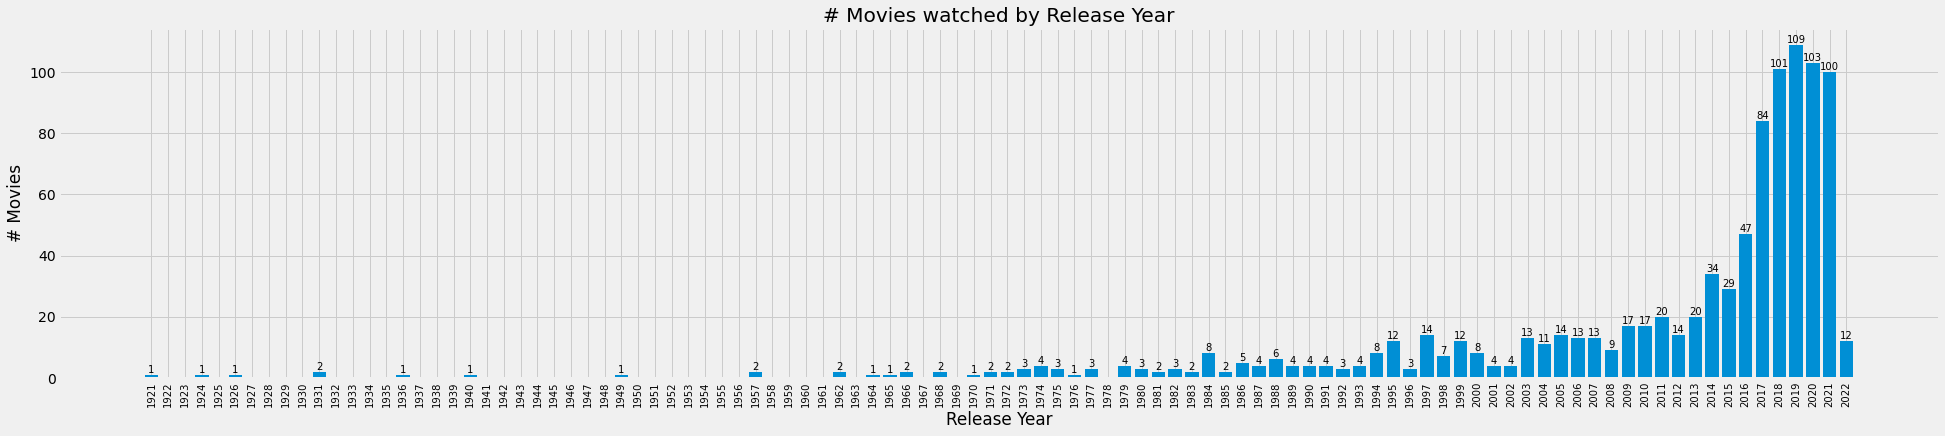

In [82]:
# Movies by Release Year
plot_movies_year = df_group_year.reset_index().sort_values('Year')

plot_movie_trend(plot_movies_year)

In [83]:
# Search by specific year
YEAR = 1993
df_release_year.groupby(by='Year').get_group(YEAR)

Title  Year  Runtime                            Genre  \
161         Groundhog Day  1993      101  Comedy, Drama, Fantasy, Romance   
450  Addams Family Values  1993       94                  Comedy, Fantasy   
683                 Naked  1993      131                    Comedy, Drama   
934    Dazed and Confused  1993      103                           Comedy   

              Director  Metascore  imdbRating  imdbVotes       Date  
161       Harold Ramis         72         8.1     609716 2020-02-27  
450   Barry Sonnenfeld         61         6.8      90540 2021-02-20  
683         Mike Leigh         85         7.8      38409 2021-10-06  
934  Richard Linklater         78         7.6     179167 2022-04-18

In [84]:
# Movies watched from current year (release year == current year)
n_movies = len(df_release_year[df_release_year['Year'] == current_year])

if n_movies != 0:
    print('Number of movies from ' + str(current_year) + ': ' + str(n_movies))
   
    df_latest_year = df_release_year.groupby(by='Year').get_group(current_year)[df_release_year.Year == current_year].drop_duplicates('Title')
    df_latest_year = df_latest_year.sort_values(['imdbRating','imdbVotes'], ascending=[False, False])
    
    show_all(df_latest_year)
else:
    print('No movies from the current year.')

Number of movies from 2022: 12


In [85]:
# Best movies by Release Year
BEST = 3
condition = 'Documentary' # remove this genre
cols = ['Title','Year','Runtime','imdbRating']

# Top movies
df_top_movies_year = df_release_year[~df_release_year['Genre'].str.contains(condition)][cols].groupby(['Year','Title']).mean().sort_values(['Year','imdbRating'], ascending=False)
df_top_movies_year = df_top_movies_year.groupby(level=0, as_index=False).apply(lambda x: x.nlargest(BEST, 'imdbRating', keep='all')).reset_index(level=0, drop=True)

df_top_movies_year['Runtime'] = df_top_movies_year['Runtime'].astype(int)

show_all(df_top_movies_year.style.background_gradient(subset='imdbRating').set_precision(1))

In [86]:
# Top documentaries by Release Year
df_top_docs_year = df_release_year[df_release_year['Genre'].str.contains(condition)][cols].groupby(['Year','Title']).mean().sort_values(['Year','imdbRating'], ascending=False)
df_top_docs_year = df_top_docs_year.groupby(level=0, as_index=False).apply(lambda x: x.nlargest(BEST, 'imdbRating', keep='all')).reset_index(level=0, drop=True)

df_top_docs_year['Runtime'] = df_top_docs_year['Runtime'].astype(int)

show_all(df_top_docs_year.style.background_gradient(subset='imdbRating').set_precision(1))

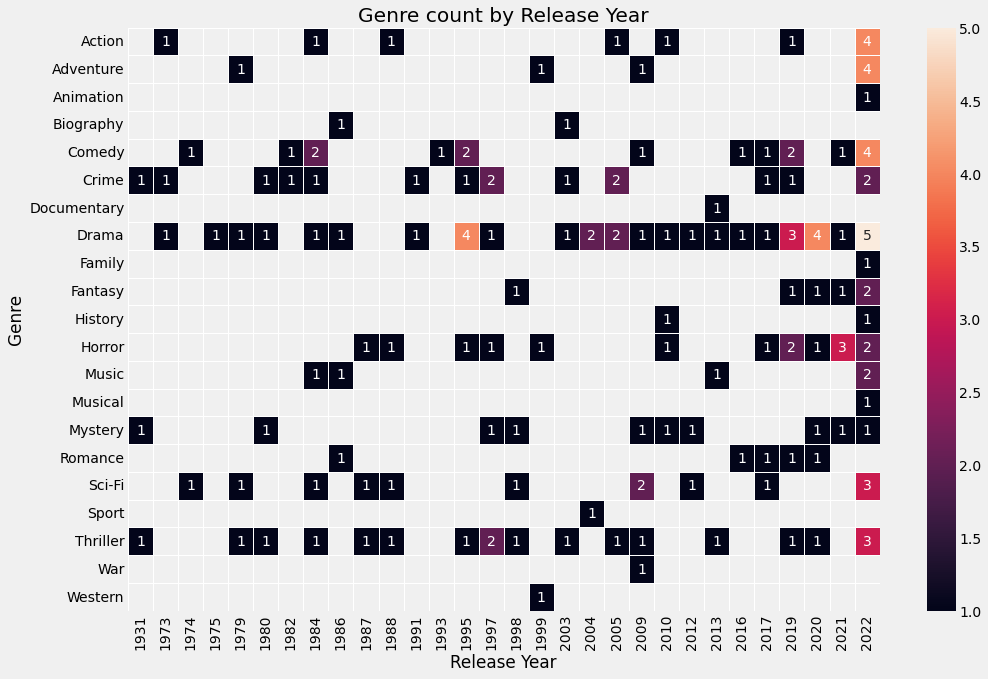

In [87]:
# Genre count by Release Year
plot_genre_year = explode(df_genre_year, ['Genre'])
plot_genre_year = plot_genre_year.groupby(['Year','Genre']).agg({'Title':'count'}).sort_values(['Year','Title'], ascending=False)
plot_ct_genre_year = plot_genre_year.unstack().T.reset_index().set_index('Genre').drop(['level_0'], axis=1)

# Plot
xsize = len(plot_ct_genre_year.columns) // 2
ysize = len(plot_ct_genre_year.index) // 2

_, ax = plt.subplots(figsize=(xsize,ysize))
ax = sns.heatmap(plot_ct_genre_year, annot=True, linewidths=.5, ax=ax)
plt.title('Genre count by Release Year')
plt.xlabel('Release Year')

ax.set_xticklabels(ax.get_xticklabels(),rotation = 90);

In [88]:
# Prepare plotting
year_list = plot_movies_year['Year']
x = 'Year'

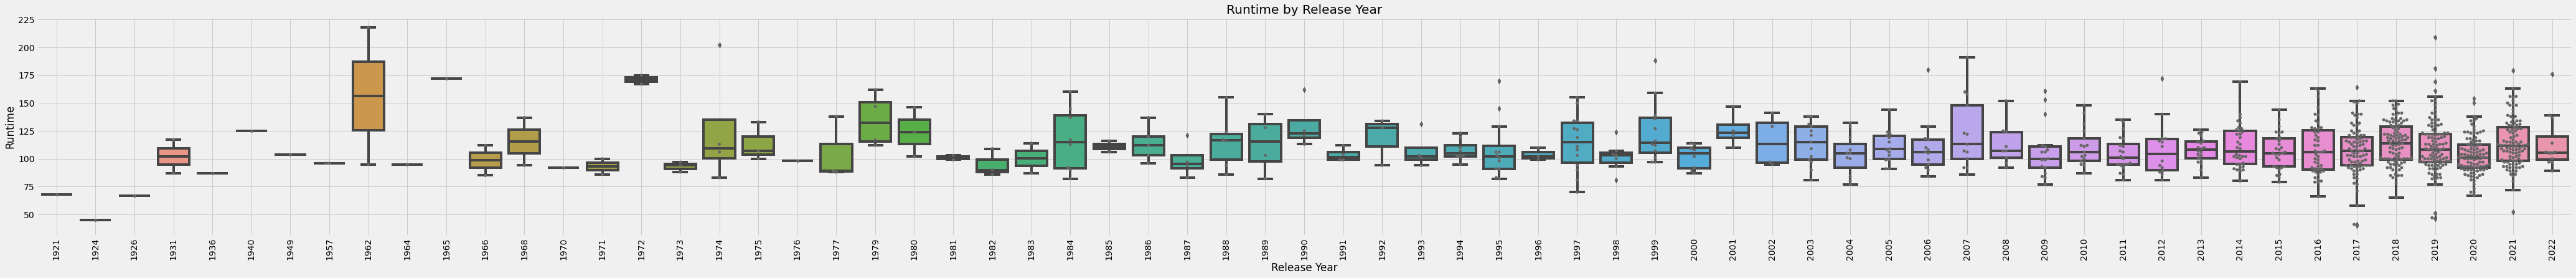

In [89]:
# Runtime by Release Year
y = 'Runtime'
plot_box_swarm(x, y, df, year_list)

In [90]:
# Time spent watching movies
runtime = df_release_year['Runtime'].sum()

print(runtime.astype(int), 'minutes')
print((runtime / 60).astype(int), 'hours')
print((runtime / (60*24)).astype(int), 'days')

104263 minutes
1737 hours
72 days


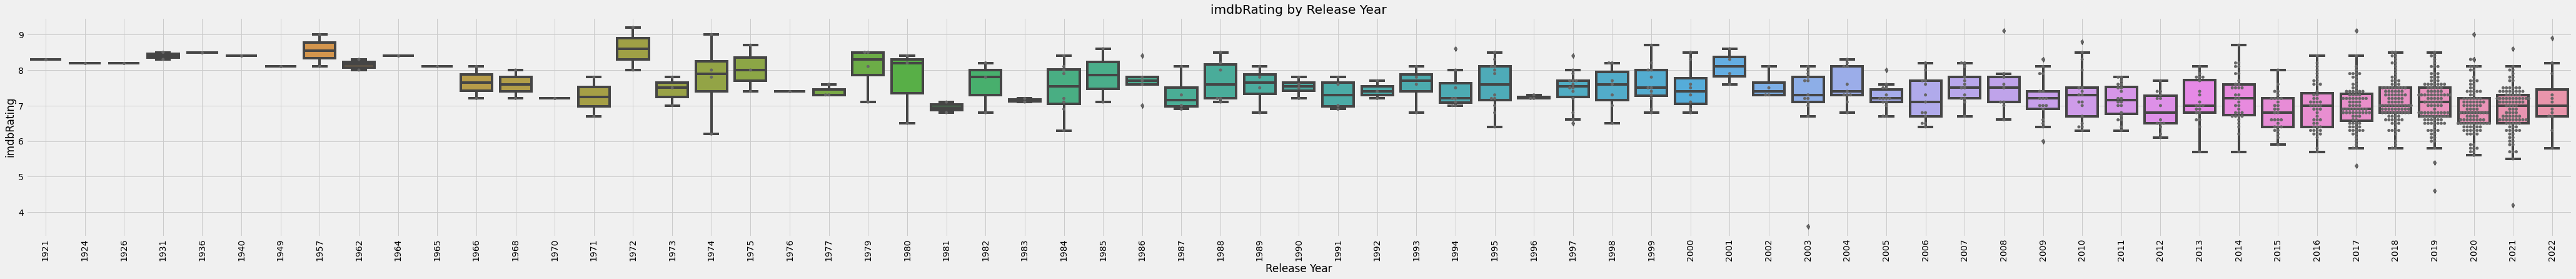

In [91]:
# imdbRating by Release Year
y = 'imdbRating'
plot_box_swarm(x, y, df, year_list)

### Decade

In [92]:
# Set decade dataframe
cols = ['Title', 'Year', 'Runtime', 'imdbRating', 'Genre', 'Language']

df_decade = df[cols].copy()

In [93]:
# Movies by Decade
df_decade['Decade'] = df_decade['Year'].astype(int)//10*10 # convert to decade

movies_decade = df_decade.groupby('Decade').agg({'Title': 'count', 
                                                 'Runtime': 'mean',
                                                 'imdbRating': 'mean'}).round(1)

movies_decade['Runtime'] = movies_decade['Runtime'].round(0).astype(int)
movies_decade.style.background_gradient(subset='imdbRating').set_precision(1)

In [94]:
# Highest rating movies by Decade
BEST = 3
condition = 'Documentary' # filter this out

df_top_rating_decade = df_decade[~df_decade['Genre'].str.contains(condition)] # filter out documentary 
df_top_rating_decade = df_top_rating_decade.drop_duplicates(subset=['Title','Year'], keep='first')
df_top_rating_decade = df_top_rating_decade.set_index(['Decade','Title']).sort_values(['Decade','imdbRating'], ascending=False)

df_top_rating_decade = df_top_rating_decade.groupby(level=0, as_index=False).apply(lambda x: x.nlargest(BEST, 'imdbRating', keep='all')).reset_index(level=0, drop=True)
df_top_rating_decade

Year  Runtime  \
Decade Title                                                               
1920   The Kid                                             1921       68   
       Sherlock Jr.                                        1924       45   
       The General                                         1926       67   
1930   City Lights                                         1931       87   
       Modern Times                                        1936       87   
       M                                                   1931      117   
1940   The Great Dictator                                  1940      125   
       The Third Man                                       1949      104   
1950   12 Angry Men                                        1957       96   
       The Seventh Seal                                    1957       96   
1960   Dr. Strangelove or: How I Learned to Stop Worry...  1964       95   
       Lawrence of Arabia                                  1962      218   
       The Sound of Music                                  1965      172   
       Persona                                             1966       85   
1970   The Godfather                                       1972      175   
       The Godfather: Part II                              1974      202   
       One Flew Over the Cuckoo's Nest                     1975      133   
1980   Back to the Future                                  1985      116   
       Cinema Paradiso                                     1988      155   
       The Shining                                         1980      146   
       Aliens                                              1986      137   
       Amadeus                                             1984      160   
1990   The Matrix                                          1999      136   
       Léon: The Professional                              1994      110   
       The Usual Suspects                                  1995      106   
2000   The Dark Knight                                     2008      152   
       Spirited Away                                       2001      125   
       Memento                                             2000      113   
2010   Inception                                           2010      148   
       Interstellar                                        2014      169   
       Avengers: Infinity War                              2018      149   
       Parasite                                            2019      132   
2020   Everything Everywhere All at Once                   2022      139   
       Spider-Man: No Way Home                             2021      148   
       The Father                                          2020       97   

                                                           imdbRating  \
Decade Title                                                            
1920   The Kid                                                    8.3   
       Sherlock Jr.                                               8.2   
       The General                                                8.2   
1930   City Lights                                                8.5   
       Modern Times                                               8.5   
       M                                                          8.3   
1940   The Great Dictator                                         8.4   
       The Third Man                                              8.1   
1950   12 Angry Men                                               9.0   
       The Seventh Seal                                           8.1   
1960   Dr. Strangelove or: How I Learned to Stop Worry...         8.4   
       Lawrence of Arabia                                         8.3   
       The Sound of Music                                         8.1   
       Persona                                                    8.1   
1970   The Godfather                                              9.2   
     

In [95]:
# Return cross-section
DEC = 1970
df_top_rating_decade.xs(DEC)

Year  Runtime  imdbRating         Genre  \
Title                                                                      
The Godfather                    1972      175         9.2  Crime, Drama   
The Godfather: Part II           1974      202         9.0  Crime, Drama   
One Flew Over the Cuckoo's Nest  1975      133         8.7         Drama   

                                                                   Language  
Title                                                                        
The Godfather                                       English, Italian, Latin  
The Godfather: Part II           English, Italian, Spanish, Latin, Sicilian  
One Flew Over the Cuckoo's Nest                                     English

In [96]:
# Prepare plotting
x = 'Decade'
decade_list = df_decade.sort_values('Decade').Decade.unique()

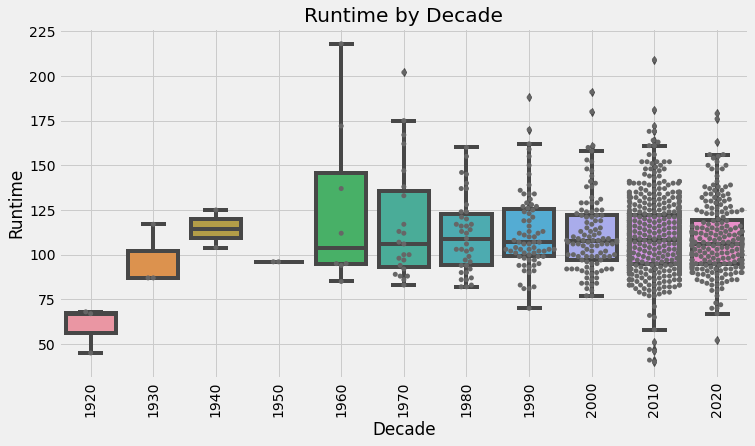

In [97]:
# Runtime by Decade
y = 'Runtime'
plot_box_swarm(x, y, df_decade, decade_list)

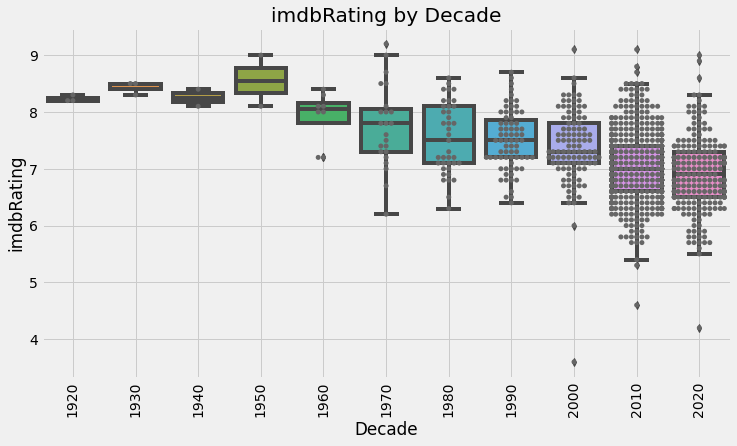

In [98]:
# imdbRating by Decade
y = 'imdbRating'
plot_box_swarm(x, y, df_decade, decade_list)

## Rated

In [99]:
# Set rated dataframe
cols = ['Title','Rated','Runtime','Genre','imdbRating']

df_rated = df[cols].copy()

In [100]:
# Movie analysis by Rated
df_rated_avg = get_mean_value(df_rated, 'Rated', 'Runtime')
df_rated_avg['imdbRating'] = get_mean_value(df_rated, 'Rated', 'imdbRating')['imdbRating']

In [101]:
# Prepare plotting
rated_list = df_rated_avg.index.sort_values()
x = 'Rated'

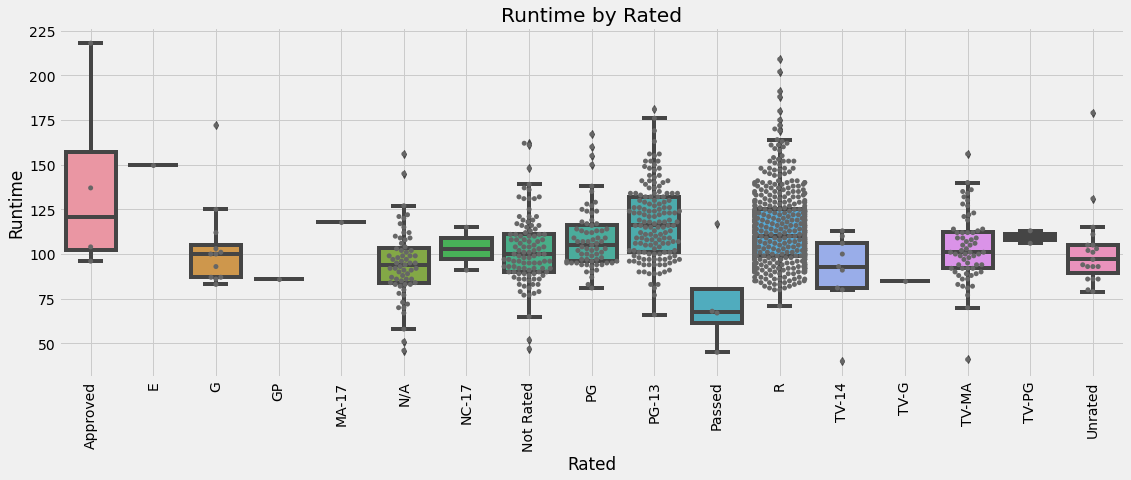

In [102]:
# The box extends from the Q1 to Q3 quartile values of the data, with a line at the median (Q2)
y = 'Runtime'
plot_box_swarm(x, y, df_rated, rated_list)

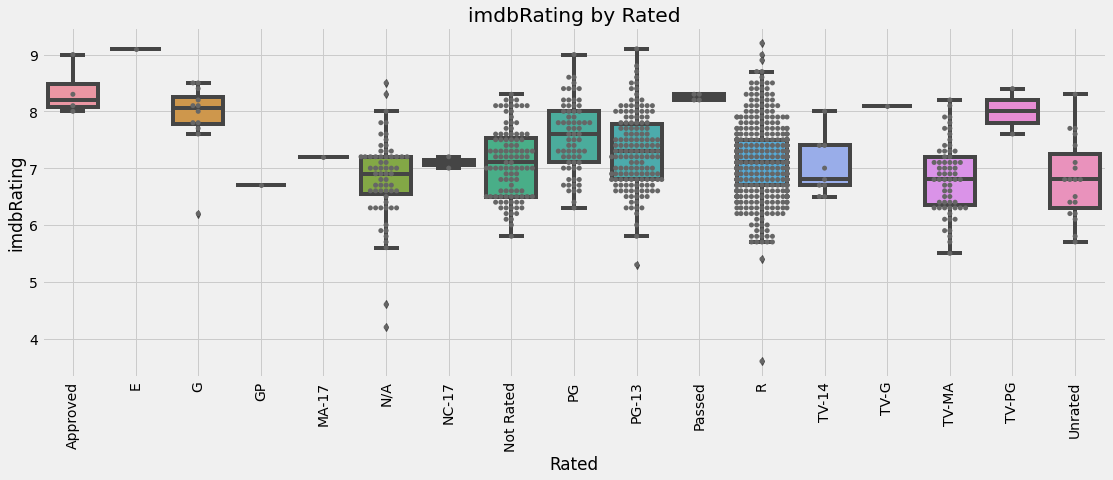

In [103]:
# The box extends from the Q1 to Q3 quartile values of the data, with a line at the median (Q2)
y = 'imdbRating'
plot_box_swarm(x, y, df_rated, rated_list)

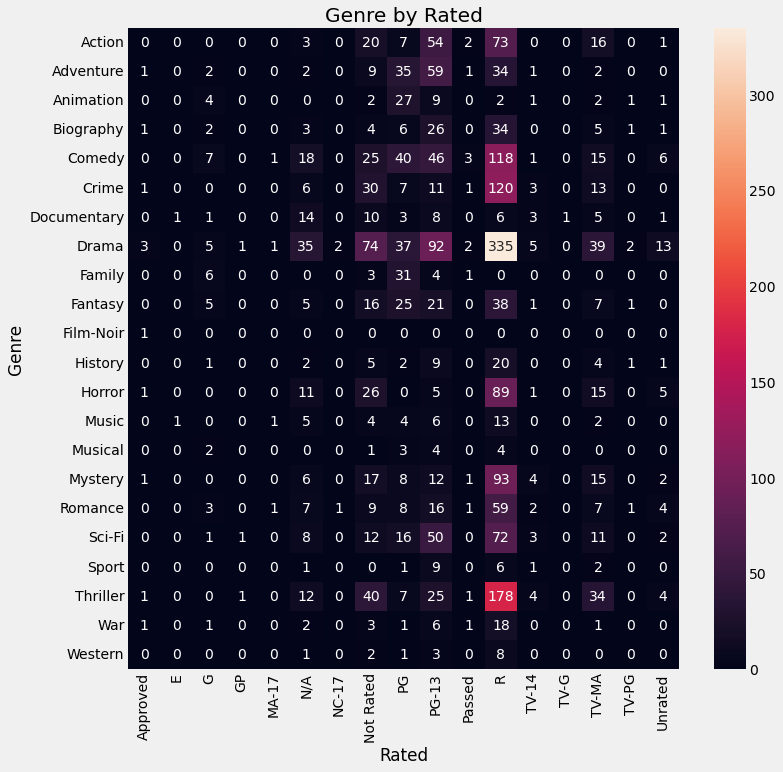

In [104]:
# Genre by Rated
df_explode_genre = df_rated.copy()

df_explode_genre = split_explode(df_explode_genre, 'Genre')
plot_ct_rated_genre = pd.crosstab(df_explode_genre['Genre'], df_explode_genre.Rated) #, margins=True)

# Plot
xsize = len(plot_ct_rated_genre.columns) // 1.5
ysize = len(plot_ct_rated_genre.index) // 2

_, ax = plt.subplots(figsize=(xsize,ysize))
sns.heatmap(plot_ct_rated_genre, annot=True, fmt="d", ax=ax)
plt.title('Genre by Rated');

## Runtime

In [105]:
# Set runtime dataframe
cols = ['Title','Year','Genre','Runtime','Metascore','imdbRating']

df_runtime = df[cols].copy()

In [106]:
print('Mean runtime: ' + str(int(round(df_runtime['Runtime'].mean(), 0))))
print('Median runtime: ' + str(int(round(df_runtime['Runtime'].median(), 0)))) 

Mean runtime: 110
Median runtime: 107


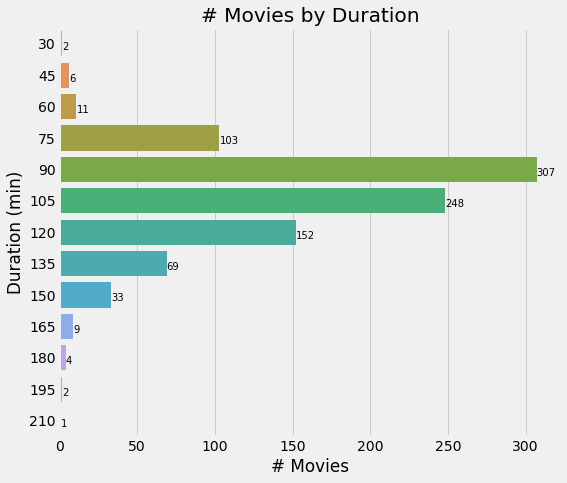

In [107]:
period = 15 # groups of 15 minutes
df_runtime['Duration'] = df_runtime['Runtime'].floordiv(period) * period 
df_runtime_group = df_runtime.groupby('Duration').agg({'Title':'count'})

# Plot
plot_duration_movies = df_runtime_group.reset_index()

plt.figure(figsize=(8,7))
sns.barplot(x='Title', y='Duration', data=plot_duration_movies, orient='h');

plt.title('# Movies by Duration')
plt.xlabel('# Movies')
plt.ylabel('Duration (min)')

for i, rate in enumerate(plot_duration_movies["Title"]):
    plt.text(rate+0.1, i+0.2, rate, fontdict={'fontsize':10})

In [108]:
# Longest movies
print('Movies over 120 minutes (2 hours):   ', len(df_runtime[df_runtime.Runtime > 120]))
print('Movies over 150 minutes (2.5 hours): ', len(df_runtime[df_runtime.Runtime > 150]))
print('Movies over 180 minutes (3 hours):   ', len(df_runtime[df_runtime.Runtime > 180]))

N = 10
show_all(df_runtime.iloc[:,:-1].nlargest(N, 'Runtime', keep='all').drop_duplicates().set_index('Title'))

Movies over 120 minutes (2 hours):    264
Movies over 150 minutes (2.5 hours):  45
Movies over 180 minutes (3 hours):    6


## Genre

In [109]:
# Set genre dataframe
cols = ['Title','Year','Genre','Runtime','imdbRating','Date']

df_genre = df[cols].copy()

In [110]:
# Number of unique genres
print('Unique genres: ' + str(counter_display(df_genre, 'Genre', 'Title').index.nunique()))

# Unique genres
list(counter_display(df_genre, 'Genre', 'Title').index.unique().sort_values())

Unique genres: 22


['Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Thriller',
 'War',
 'Western']

In [111]:
# Check genre of recently watched movies 
N = 10
df_genre.tail(N)

Title  Year                             Genre  Runtime  \
946            The Informer  2019            Crime, Drama, Thriller      113   
947              To Die For  1995    Comedy, Crime, Drama, Thriller      106   
948  All My Friends Hate Me  2021                    Comedy, Horror       93   
949                Triangle  2009         Mystery, Sci-Fi, Thriller       99   
950      Night of the Kings  2020                    Drama, Fantasy       93   
951         Mysterious Skin  2004                             Drama      105   
952         Boyz n the Hood  1991                      Crime, Drama      112   
953                Cruising  1980   Crime, Drama, Mystery, Thriller      102   
954             Lord of War  2005                      Crime, Drama      122   
955           Hunter Hunter  2020  Drama, Horror, Mystery, Thriller       93   

     imdbRating       Date  
946         6.6 2022-04-27  
947         6.8 2022-04-28  
948         5.9 2022-04-29  
949         6.9 2022-04-30  
950         6.6 2022-05-02  
951         7.6 2022-05-03  
952         7.8 2022-05-05  
953         6.5 2022-05-06  
954         7.6 2022-05-07  
955         6.4 2022-05-08

In [112]:
# Top movie genres
df_explode_genre = df_genre.copy()

# do this for visualization below
df_explode_genre = split_explode(df_explode_genre, 'Genre')

In [113]:
# Statistic analysis of Runtime by Genre
df_genre_runtime_stats = df_explode_genre.drop('imdbRating', axis=1).groupby('Genre')['Runtime'].describe()

stat_cols = df_genre_runtime_stats.columns.values #['count','mean','std','min','max']

df_genre_runtime_stats[stat_cols] = df_genre_runtime_stats[stat_cols].fillna(0).astype(int)
df_genre_runtime_stats.sort_values('count', inplace=True, ascending=False)

df_genre_runtime_stats

count  mean  std  min  25%  50%  75%  max
Genre                                                 
Drama          646   112   21   51   97  109  125  218
Thriller       307   110   19   51   97  108  122  191
Comedy         280   102   16   41   92  101  113  161
Crime          192   113   22   40   98  110  124  209
Action         176   118   22   45  103  118  134  191
Sci-Fi         176   113   21   70   97  111  129  181
Mystery        159   111   20   70   97  107  122  180
Horror         153   105   18   77   93  101  113  191
Adventure      146   117   22   67  101  115  132  218
Fantasy        119   112   20   70   99  109  124  180
Romance        119   110   19   45   97  108  124  172
Biography       83   122   22   81  111  119  131  218
Documentary     53    90   18   40   83   90  100  150
Animation       49   100   13   66   92  100  107  134
History         45   116   20   77  100  116  131  161
Family          45   101   16   66   95  100  107  172
Music           36   108   17   82   97  106  118  160
War             34   118   26   67  105  117  125  218
Sport           20   115   29   40  104  122  134  152
Western         15   118   19   92  101  122  131  160
Musical         14   118   24   92  100  111  131  172
Film-Noir        1   104    0  104  104  104  104  104

In [114]:
# Statistic analysis of imdbRating by Genre
df_genre_rating_stats = df_explode_genre.drop('Runtime', axis=1).groupby('Genre')['imdbRating'].describe()

stat_cols = df_genre_rating_stats.columns.values

df_genre_rating_stats[stat_cols] = df_genre_rating_stats[stat_cols].fillna(0).round(1)
df_genre_rating_stats['count'] = df_genre_rating_stats['count'].astype(int)
df_genre_rating_stats.sort_values('count', inplace=True, ascending=False)

df_genre_rating_stats

count  mean  std  min  25%  50%  75%  max
Genre                                                 
Drama          646   7.2  0.6  3.6  6.8  7.2  7.6  9.2
Thriller       307   7.0  0.6  4.2  6.5  7.0  7.3  9.1
Comedy         280   7.1  0.7  4.6  6.6  7.0  7.5  8.9
Crime          192   7.2  0.6  5.7  6.8  7.1  7.5  9.2
Action         176   7.1  0.7  4.2  6.6  7.0  7.4  9.1
Sci-Fi         176   7.0  0.7  4.2  6.5  7.0  7.4  8.9
Mystery        159   7.0  0.7  5.7  6.5  7.0  7.5  8.6
Horror         153   6.7  0.6  5.4  6.3  6.6  7.0  8.5
Adventure      146   7.3  0.7  5.7  6.7  7.2  7.7  8.9
Fantasy        119   7.1  0.7  4.2  6.7  7.1  7.6  8.9
Romance        119   7.2  0.6  5.8  6.8  7.2  7.5  8.5
Biography       83   7.4  0.5  6.2  7.1  7.4  7.8  9.0
Documentary     53   7.6  0.6  5.7  7.3  7.6  8.1  9.1
Animation       49   7.7  0.5  6.3  7.3  7.7  8.0  8.6
History         45   7.4  0.5  6.3  7.1  7.3  7.6  8.2
Family          45   7.6  0.6  6.3  7.2  7.6  8.1  8.6
Music           36   7.4  0.7  5.8  6.9  7.2  8.0  9.1
War             34   7.6  0.6  6.3  7.2  7.6  8.2  8.5
Sport           20   7.5  0.5  6.4  7.2  7.4  7.9  8.5
Western         15   7.1  0.3  6.6  6.9  6.9  7.3  7.6
Musical         14   7.2  0.6  6.3  6.8  7.4  7.6  8.1
Film-Noir        1   8.1  0.0  8.1  8.1  8.1  8.1  8.1

In [115]:
# Genre (runtime and rating mean values)
df_genre_top_stats = pd.DataFrame(index = df_genre_runtime_stats.index)

df_genre_top_stats['count'] = df_genre_runtime_stats['count']
df_genre_top_stats['runtime'] = df_genre_runtime_stats['mean']
df_genre_top_stats['ratings'] = df_genre_rating_stats['mean']

df_genre_top_stats.style.background_gradient(subset=['runtime','ratings']).set_precision(1)

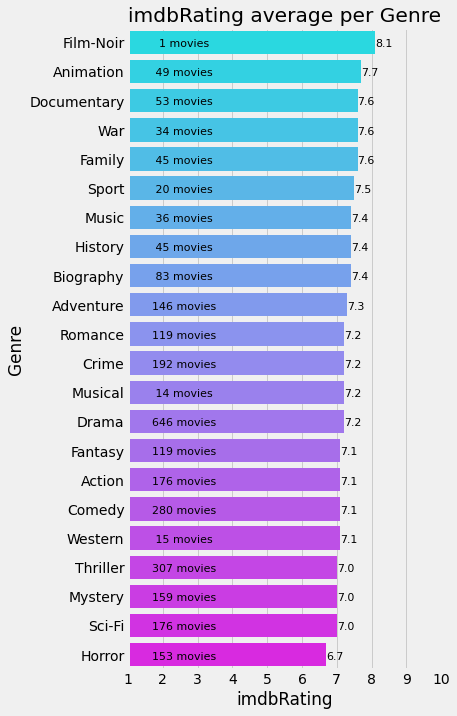

In [116]:
# Genre with highest imdbRating
df_genre_rating_stats.sort_values(by='mean', ascending=False, inplace=True)

# Plot
# https://medium.com/analytics-vidhya/exploratory-data-analysis-imdb-dataset-cff0c3991ad5
ratings = [1, 10] # imdbRating from 1 to 10
xsize = ratings[1] // 2
ysize = len(df_genre_rating_stats.index) // 2

plt.figure(figsize=(xsize,ysize))
sns.barplot(y=df_genre_rating_stats.index, x=df_genre_rating_stats["mean"], palette='cool', orient="h")

plt.title('imdbRating average per Genre')
plt.xlabel('imdbRating')
plt.xlim(ratings) 
plt.xticks(np.arange(ratings[0], ratings[1]+1, step=1))

for i, counts in enumerate(df_genre_rating_stats["count"]):
    plt.text(ratings[0]+0.5, i+0.15, f"{counts:>5} movies", fontdict={'fontsize':11})
    plt.text(df_genre_rating_stats["mean"][i], i+0.15, df_genre_rating_stats["mean"][i], fontdict={'fontsize':11})
    
plt.show()

In [117]:
# Number of unique combination of genres
df_genre[['Genre','Title']].groupby(by='Genre').count().reset_index()['Genre'].nunique()

357

In [118]:
# Top movie genres combination
df_genre_date = df_genre.copy()
df_genre_date['Year'] = df_genre['Date'].dt.year

df_genre_date.drop(columns='Date', inplace=True)
pd.crosstab(df_genre_date['Genre'], df_genre_date['Year'], margins=True).nlargest(N+1, 'All', keep='all') # +1 because 'All' takes 1 spot 

Year                             2018  2019  2020  2021  2022  All
Genre                                                             
All                                59    73   251   404   160  947
Drama                               1     3    22    26    17   69
Comedy, Drama                       7     4    12    18     3   44
Crime, Drama, Thriller              2     3    11    10     7   33
Documentary                         2     1     9     9     2   23
Drama, Romance                      0     2     5    11     5   23
Comedy, Drama, Romance              0     1     0    12     9   22
Crime, Drama                        1     1     4     9     5   20
Crime, Drama, Mystery, Thriller     0     3     6     7     2   18
Action, Adventure, Sci-Fi           4     3     1     5     0   13
Biography, Drama                    0     1     6     6     0   13
Drama, Mystery, Thriller            0     1     3     7     2   13

In [119]:
# Genre combination with most movies, showing worst and best movies
df_genre_agg = df_genre.groupby(by='Genre').agg({'imdbRating':['min','max','mean'], 
                                                 'Title':['count']})
df_genre_agg.reset_index(inplace=True)

df_genre_agg[('Title','worst')] = df_genre.loc[df_genre.groupby('Genre')['imdbRating'].idxmin().fillna(0).astype(int)].reset_index(drop=True)['Title']
df_genre_agg[('Title','best')] = df_genre.loc[df_genre.groupby('Genre')['imdbRating'].idxmax().fillna(0).astype(int)].reset_index(drop=True)['Title']

df_genre_agg = df_genre_agg.set_index([('Genre','')]).sort_values(by=[('Title','count')], ascending=False).round(1)
df_genre_agg.index.rename('Genre', inplace=True)

df_genre_agg.nlargest(N, [('Title', 'count')], keep='all')

imdbRating           Title  \
                                       min  max mean count   
Genre                                                        
Drama                                  3.6  8.7  7.1    69   
Comedy, Drama                          6.2  8.2  7.1    44   
Crime, Drama, Thriller                 6.3  8.4  7.2    33   
Drama, Romance                         6.1  8.5  7.4    23   
Documentary                            5.9  8.5  7.5    23   
Comedy, Drama, Romance                 6.2  8.5  7.2    22   
Crime, Drama                           6.3  9.2  7.6    20   
Crime, Drama, Mystery, Thriller        6.3  8.5  7.2    18   
Drama, Mystery, Thriller               5.9  8.2  7.2    13   
Biography, Drama                       6.6  8.2  7.5    13   
Action, Adventure, Sci-Fi              6.3  8.5  7.3    13   

                                                            \
                                                     worst   
Genre                                                        
Drama                                             The Room   
Comedy, Drama                                    Chevalier   
Crime, Drama, Thriller                                Kimi   
Drama, Romance                                        Love   
Documentary                           Expedition Happiness   
Comedy, Drama, Romance                 Morris from America   
Crime, Drama                     The Many Saints of Newark   
Crime, Drama, Mystery, Thriller               Shimmer Lake   
Drama, Mystery, Thriller                        Horse Girl   
Biography, Drama                                       Joy   
Action, Adventure, Sci-Fi                             Dune   

                                                                  
                                                            best  
Genre                                                             
Drama                            One Flew Over the Cuckoo's Nest  
Comedy, Drama                                    The Truman Show  
Crime, Drama, Thriller                                     Joker  
Drama, Romance                                   Cinema Paradiso  
Documentary                                      Untamed Romania  
Comedy, Drama, Romance                               City Lights  
Crime, Drama                                       The Godfather  
Crime, Drama, Mystery, Thriller               The Usual Suspects  
Drama, Mystery, Thriller                         The Sixth Sense  
Biography, Drama                                The Elephant Man  
Action, Adventure, Sci-Fi                 Avengers: Infinity War

In [120]:
# Genre combination with higher imdbRating
df_genre_agg[df_genre_agg[('Title','count')] > 2].nlargest(N, [('imdbRating','mean')], keep='all')

imdbRating           Title  \
                                                  min  max mean count   
Genre                                                                   
Documentary, Music                                7.8  9.1  8.3     4   
Action, Adventure, Sci-Fi, Thriller               7.3  8.8  8.2     3   
Adventure, Drama, Sci-Fi                          6.9  8.7  7.9     3   
Action, Adventure, Comedy, Fantasy, Sci-Fi        7.0  8.9  7.8     4   
Documentary, History                              7.5  8.1  7.8     3   
Comedy, Drama, War                                6.9  8.4  7.7     3   
Crime, Drama                                      6.3  9.2  7.6    20   
Action, Crime, Drama, Thriller                    6.5  9.1  7.6    10   
Comedy, Drama, Thriller                           6.8  8.5  7.6     4   
Mystery, Thriller                                 6.7  8.5  7.6     3   

                                                                       \
                                                                worst   
Genre                                                                   
Documentary, Music                                         Sound City   
Action, Adventure, Sci-Fi, Thriller               Alita: Battle Angel   
Adventure, Drama, Sci-Fi                                        Finch   
Action, Adventure, Comedy, Fantasy, Sci-Fi          Love and Monsters   
Documentary, History                                 One Child Nation   
Comedy, Drama, War                                   Last Flag Flying   
Crime, Drama                                The Many Saints of Newark   
Action, Crime, Drama, Thriller                            Enforcement   
Comedy, Drama, Thriller                                Under the Tree   
Mystery, Thriller                                                 Run   

                                                                               
                                                                         best  
Genre                                                                          
Documentary, Music                                 Hans Zimmer Live in Prague  
Action, Adventure, Sci-Fi, Thriller                                 Inception  
Adventure, Drama, Sci-Fi                                         Interstellar  
Action, Adventure, Comedy, Fantasy, Sci-Fi  Everything Everywhere All at Once  
Documentary, History                                                Apollo 11  
Comedy, Drama, War                                         The Great Dictator  
Crime, Drama                                                    The Godfather  
Action, Crime, Drama, Thriller                                The Dark Knight  
Comedy, Drama, Thriller                                              Parasite  
Mystery, Thriller                                                     Memento

In [121]:
# Genre combination with lower imdbRating
df_genre_agg[df_genre_agg[('Title','count')] > 2].nsmallest(N, [('imdbRating','mean')], keep='all')

imdbRating           Title  \
                                                min  max mean count   
Genre                                                                 
Comedy, Horror, Sci-Fi                          5.6  6.5  6.1     3   
Comedy, Horror                                  5.7  7.3  6.3     6   
Horror, Mystery, Sci-Fi, Thriller               5.8  6.8  6.3     5   
Action, Comedy, Horror, Thriller                5.5  6.9  6.3     3   
Drama, Horror, Thriller                         6.2  7.2  6.5     8   
Drama, Sci-Fi, Thriller                         6.0  6.8  6.5     6   
Comedy, Horror, Thriller                        6.1  6.7  6.5     5   
Drama, Horror, Mystery, Sci-Fi, Thriller        6.2  7.1  6.5     4   
Horror                                          5.9  6.9  6.5     3   
Horror, Mystery, Thriller                       5.9  7.5  6.6     5   
Drama, Horror, Mystery                          6.2  6.9  6.6     3   
Crime, Drama, Horror, Thriller                  6.4  6.9  6.6     3   

                                                                        \
                                                                 worst   
Genre                                                                    
Comedy, Horror, Sci-Fi                                     Fried Barry   
Comedy, Horror                                    The Greasy Strangler   
Horror, Mystery, Sci-Fi, Thriller                             The Void   
Action, Comedy, Horror, Thriller                    Willy's Wonderland   
Drama, Horror, Thriller                              Boys in the Trees   
Drama, Sci-Fi, Thriller                                     Fast Color   
Comedy, Horror, Thriller                                 The Beta Test   
Drama, Horror, Mystery, Sci-Fi, Thriller             It Comes at Night   
Horror                                                      Hellbender   
Horror, Mystery, Thriller                     The Blackcoat's Daughter   
Drama, Horror, Mystery                    Fear Street: Part One - 1994   
Crime, Drama, Horror, Thriller                                 Creep 2   

                                                                                      
                                                                                best  
Genre                                                                                 
Comedy, Horror, Sci-Fi                                                       Slither  
Comedy, Horror                                                                 House  
Horror, Mystery, Sci-Fi, Thriller                                           eXistenZ  
Action, Comedy, Horror, Thriller                                            The Trip  
Drama, Horror, Thriller                                                 Dead Ringers  
Drama, Sci-Fi, Thriller                                                       Primer  
Comedy, Horror, Thriller                  Behind the Mask: The Rise of Leslie Vernon  
Drama, Horror, Mystery, Sci-Fi, Thriller                           The Invisible Man  
Horror                                                                     Near Dark  
Horror, Mystery, Thriller                                             The Wicker Man  
Drama, Horror, Mystery                                                     The Witch  
Crime, Drama, Horror, Thriller                                Nothing Bad Can Happen

In [122]:
# Most watched genres, with rating and worst/best movie from each genre
df_top_genres_year = df_genre[~df_genre['Genre'].str.contains('Documentary')][~df_genre.duplicated(['Title','Year'], keep='first')]

SHOW = 5

[
    [
        print(year),
        # all movies
        most_watched_genre_combo(df_top_genres_year, SHOW, year),
        most_watched_genre(df_top_genres_year, SHOW, year),
        print('\n'),
    ]
    for year in years
];

2018




2019




2020




2021




2022


In [123]:
# Best movies by genre in each decade
SHOW = 3

df_decade_genre = df_decade.copy()

df_decade_genre = split_explode(df_decade_genre, 'Genre')
df_best_decade_genre = df_decade_genre.groupby(['Decade','Genre'], as_index=False).apply(lambda x: x.nlargest(SHOW, 'imdbRating', keep='last'))
df_best_decade_genre = pd.crosstab(index=df_best_decade_genre['Genre'], 
                                   columns=df_best_decade_genre['Decade'], 
                                   values=df_best_decade_genre['Title'], 
                                   aggfunc=' * '.join)

show_all(df_best_decade_genre)

In [124]:
# Common Genre double pairing
df_genres_pairs = pairing(df_genre, 'Genre')

# Show top pairs
N = 20
show_all(df_genres_pairs.nlargest(N, 'Count', keep='all'))

In [125]:
# Common Genre triple pairing
df_genres_pairs = pairing(df_genre, 'Genre', pair=3)

# Show top pairs
N = 20
show_all(df_genres_pairs.nlargest(N, 'Count', keep='all'))

## Director

In [126]:
# Number of unique Directors (single or multiple)
len(counter_display(df, 'Director', 'Title', None).index)

774

In [127]:
# Set director dataframe
cols = ['Title','Year','Runtime','Director','Cinematographer','Genre','Actors','imdbRating','imdbVotes','Production','Date']

df_director = df[cols].copy()
# No duplicated movies
df_director = df_director[~df_director.duplicated(['Title','Year'], keep='first')]
df_director = df_director[~df_director.duplicated(['Title','Director'], keep='first')]
# Drop documentaries
df_director = df_director[~df_director['Genre'].str.contains('Documentary')].reset_index(drop=True) 

In [128]:
# Directors with most movies wached
df_dirrat = get_mean_value(df_director, 'Director', 'imdbRating')
df_dirrat['Runtime'] = get_mean_value(df_director, 'Director', 'Runtime')['Runtime']

# Most watched Directors - no Docs
print('Directors with only 1 movie watched: ' + str(len(df_dirrat[df_dirrat['Total'] == 1])))

i=1
n_movies = 3
while i <= n_movies:
    print('Directors with more than ' + str(i) + ' movie watched: ' + str(len(df_dirrat[df_dirrat['Total'] > i])))
    i+=1

Directors with only 1 movie watched: 560
Directors with more than 1 movie watched: 152
Directors with more than 2 movie watched: 49
Directors with more than 3 movie watched: 28


In [129]:
# Most watched Directors by Year
[
    [
        print(year),
        show_all(get_mean_value(df_director[df_director['Date'].dt.year == year], 'Director', 'imdbRating').query('Total > 1').sort_values(['Total','imdbRating'], ascending=False)),
        print('\n'),
    ]
    for year in years
];

2018




2019




2020




2021




2022


In [130]:
# Directors with most movies watched
show_all(df_dirrat[df_dirrat['Total'] > 2].sort_values(by=['Total','imdbRating'], ascending=False))

In [131]:
# Directors with the longest movies (with more than 1 movie watched)
N = 10
show_all(df_dirrat[df_dirrat['Total'] > 1].nlargest(N, 'Runtime', keep='all'))

In [132]:
# Highest rating directors (with more than 1 movie watched)
show_all(df_dirrat[df_dirrat['Total'] > 1].nlargest(N, 'imdbRating', keep='all'))

In [133]:
# Top rated directors with only 1 movie watched
df_dirrat[~df_dirrat['Movies'].apply(pd.Series).duplicated()][df_dirrat.Total == 1].nlargest(N, 'imdbRating', keep='all') # columns with list values # remove duplicated list values

Total                                 Movies  imdbRating  \
Director                                                                     
Sidney Lumet          1                           12 Angry Men         9.0   
Dan Kwan              1      Everything Everywhere All at Once         8.9   
Nadine Labaki         1                              Capernaum         8.4   
Todd Phillips         1                                  Joker         8.4   
Lee Unkrich           1                                   Coco         8.4   
Makoto Shinkai        1                             Your Name.         8.4   
Rodney Rothman        1      Spider-Man: Into the Spider-Verse         8.4   
Michel Gondry         1  Eternal Sunshine of the Spotless Mind         8.3   
Sam Mendes            1                                   1917         8.3   
Rahi Anil Barve       1                                Tumbbad         8.3   
Darren Aronofsky      1                    Requiem for a Dream         8.3   
David Lean            1                     Lawrence of Arabia         8.3   
Fritz Lang            1                                      M         8.3   
Florian Zeller        1                             The Father         8.3   

                  Runtime  
Director                   
Sidney Lumet           96  
Dan Kwan              139  
Nadine Labaki         126  
Todd Phillips         122  
Lee Unkrich           105  
Makoto Shinkai        106  
Rodney Rothman        117  
Michel Gondry         108  
Sam Mendes            119  
Rahi Anil Barve       104  
Darren Aronofsky      102  
David Lean            218  
Fritz Lang            117  
Florian Zeller         97

In [134]:
# Lowest rating directors
show_all(df_dirrat[df_dirrat['Total'] > 1].nsmallest(N, 'imdbRating', keep='all'))

In [135]:
# Genre by Director
df_genre_director = df_director.copy()

cols = ['Genre','Director']
for col in cols:
    df_genre_director = split_explode(df_genre_director, col)

director_movies = df_dirrat[df_dirrat['Total'] > 2].index
ct_genre_director = pd.crosstab(df_genre_director['Director'], df_genre_director['Genre']).loc[director_movies]

In [136]:
# Top Director by Genre
df_genre_top_director = pd.crosstab(df_genre_director['Director'], df_genre_director['Genre'])
list_genres = df_genre_top_director.columns

for i in range(len(list_genres)):
    # genre
    gnr = []
    gnr = list_genres[i]
    
    df_genre_temp = pd.DataFrame(df_genre_top_director.nlargest(3, gnr)[gnr])
    df_genre_temp['Movies'] = np.nan
    df_genre_temp['Movies'] = df_genre_temp['Movies'].astype('object') # need to make sure the column you are inserting into has dtype=object
    
    # director
    drctr = []
    drctr = list(df_genre_temp.index)
    for j in range(len(drctr)):
        # movies
        mvs = []
        mvs = '; '.join(df[df['Director'].str.contains(drctr[j])][df['Genre'].str.contains(gnr)]['Title'])
        
        df_genre_temp.at[drctr[j], 'Movies'] = mvs # .at instead of .loc

    show_all(df_genre_temp)
    
    print('\n')

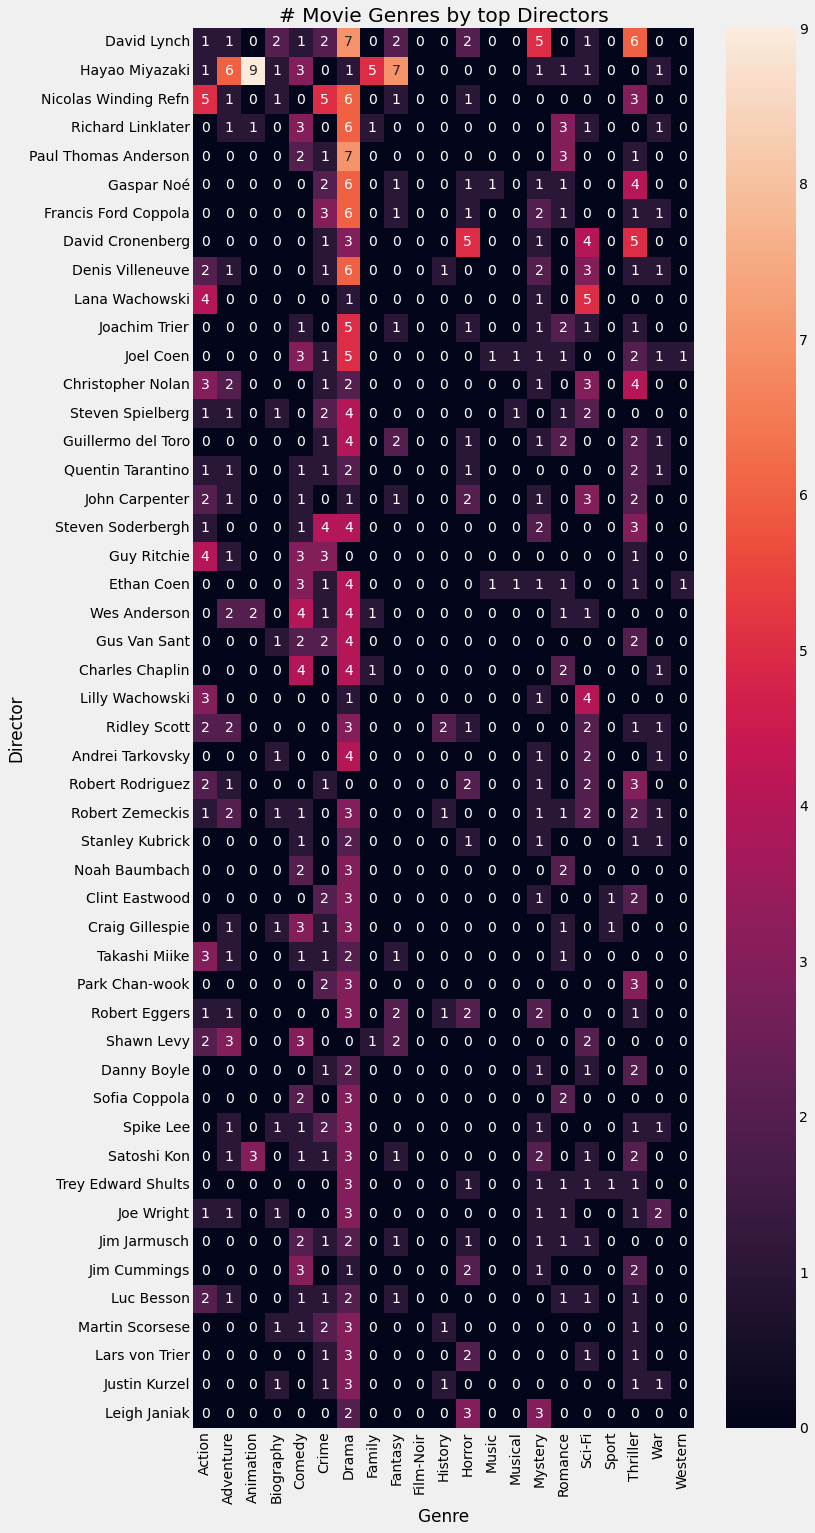

In [137]:
# Plot movie genres by top Directors
xsize = len(ct_genre_director.columns) // 2
ysize = len(ct_genre_director.index) // 2

_, ax = plt.subplots(figsize=(xsize,ysize))

ax = sns.heatmap(ct_genre_director, annot=True, fmt="d")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90) 
plt.title('# Movie Genres by top Directors');

In [138]:
# search data by director
director = 'Joachim Trier'
df[df['Director'].str.contains(director)].iloc[:,:-6]

Title  Year    imdbID      Rated  Runtime  \
426                         Thelma  2017   6304046  Not Rated      116   
667                        Reprise  2006   0827517          R      105   
826  The Worst Person in the World  2021  10370710          R      128   
865              Oslo, August 31st  2011   1736633  Not Rated       95   
866              Louder Than Bombs  2015   2217859          R      109   

                                                 Genre       Director  \
426  Drama, Fantasy, Horror, Mystery, Romance, Sci-...  Joachim Trier   
667                                              Drama  Joachim Trier   
826                             Comedy, Drama, Romance  Joachim Trier   
865                                              Drama  Joachim Trier   
866                                              Drama  Joachim Trier   

                                                Writer Cinematographer  \
426                          Eskil Vogt, Joachim Trier      Jakob Ihre   
667                          Eskil Vogt, Joachim Trier      Jakob Ihre   
826                          Eskil Vogt, Joachim Trier    Kasper Tuxen   
865  Eskil Vogt, Joachim Trier, Pierre Drieu La Roc...      Jakob Ihre   
866                          Eskil Vogt, Joachim Trier      Jakob Ihre   

                                                Actors  \
426  Eili Harboe, Kaya Wilkins, Henrik Rafaelsen, E...   
667  Anders Danielsen Lie, Espen Klouman Høiner, Vi...   
826  Renate Reinsve, Anders Danielsen Lie, Herbert ...   
865  Anders Danielsen Lie, Malin Crépin, Aksel Than...   
866  Gabriel Byrne, Isabelle Huppert, Jesse Eisenbe...   

                                                  Plot            Language  \
426  A confused religious girl tries to deny her fe...  Norwegian, Swedish   
667  Two competitive friends, fueled by literary as...           Norwegian   
826  The chronicles of four years in the life of Ju...           Norwegian   
865  One day in the life of Anders, a young recover...  Norwegian, English   
866  The fractious family of a father and his two s...     English, French   

                                    Country  Metascore  imdbRating  imdbVotes  \
426         Norway, France, Denmark, Sweden         74         7.0      30838   
667                                  Norway         79         7.3      10996   
826         Norway, France, Sweden, Denmark         90         7.9      28366   
865                 Norway, Denmark, Sweden         84         7.6      22570   
866  Norway, France, Denmark, United States         70         6.6      12954   

                                            Production           Timestamp  \
426  Motlys, Memento Films International, Film i Vä... 2021-02-01 21:08:00   
667  4 1/2 Film, Filmlance International AB, Spille... 2021-09-24 23:05:59   
826  Oslo Pictures, MK2 Productions, Film i Väst, S... 2022-01-18 23:15:20   
865  Motlys, Don't Look Now, Norsk Filminstitutt, N... 2022-02-16 23:37:30   
866  Motlys, Memento Films Production, Nimbus Film ... 2022-02-17 23:16:04   

          Date      Time  
426 2021-02-01  21:08:00  
667 2021-09-24  23:05:59  
826 2022-01-18  23:15:20  
865 2022-02-16  23:37:30  
866 2022-02-17  23:16:04

In [139]:
# Director average votes by movie
df_director_votes = df_director.copy()

df_director_votes = split_explode(df_director_votes, 'Director')
df_director_avg_votes = get_mean_value(df_director_votes, 'Director', 'imdbVotes')
df_director_avg_votes['imdbRating'] = get_mean_value(df_director_votes, 'Director', 'imdbRating')['imdbRating']
df_director_avg_votes['imdbVotes'] = df_director_avg_votes['Total'] * df_director_avg_votes['imdbVotes']

# Directors with most votes (more than 1 movie watched)
show_all(df_director_avg_votes[df_director_avg_votes.Total > 1].nlargest(N, 'imdbVotes', keep='all'))

In [140]:
# Directos with fewer votes (more than 1 movie watched)
show_all(df_director_avg_votes[df_director_avg_votes.Total > 1].nsmallest(N, 'imdbVotes', keep='all'))

In [141]:
## Less known directors to follow
# Parameters:
# - more than 1 movie watched
# - less votes than 50% quantile
# - imdbRating average over 6
show_all(df_director_avg_votes[df_director_avg_votes['Total'] > 1][df_director_avg_votes['imdbVotes'] < df_director_avg_votes['imdbVotes'].quantile(0.5)][df_director_avg_votes['imdbRating'] > 6.0])

In [142]:
# Partnership between Director / Cinematographer
df_director_cinema = df_director.copy()

gb_director_cinema_pair = double_group_info(df_director_cinema, 'Director', 'Cinematographer', 1)
show_all(gb_director_cinema_pair)

In [143]:
# Partnership between Director / Actors
df_director_actor = df_director[['Director','Actors','Title','imdbRating']].copy()
df_director_actor = split_explode(df_director_actor, 'Director')
df_director_actor = split_explode(df_director_actor, 'Actors')

TOP = 20
gb_director_actor_pair = double_group_info(df_director_actor, 'Director', 'Actors')
show_all(gb_director_actor_pair.nlargest(TOP, ('Title','count'), keep='all'))

In [144]:
# Partnership between Director / Production Company
df_director_production = df_director.copy()

gb_director_production_pair = double_group_info(df_director_production, 'Director', 'Production', 1)
show_all(gb_director_production_pair)

## Writer

In [145]:
# Number of unique Writer (single or multiple)
len(counter_display(df,'Writer','Title', None).index)

1659

In [146]:
# Set writer dataframe
df_writer = df.copy()

df_writer['Writer'] = df_writer['Writer'].str.split(',').apply(lambda x: [e.strip() for e in x])
df_writer['Writer'] = df_writer['Writer'].apply(lambda x: list(set(x))) # remove duplicates
df_writer = explode(df_writer, ['Writer'])
df_writer = df_writer[~df_writer['Writer'].str.startswith('N/A')] # remove 'N/A'
# Drop documentaries
df_writer = df_writer[~df_writer['Genre'].isin(['Documentary'])]

In [147]:
# Highest rating writers
df_writer_rating = df_writer.copy()
df_writer_rating = get_mean_value(df_writer_rating, 'Writer', 'imdbRating')

# Writer with most movies watched
show_all(df_writer_rating.nlargest(N, 'Total', keep='all'))

In [148]:
# Writer with highest average rating, by movies watched (greater than 2)
show_all(df_writer_rating[df_writer_rating['Total'] > 2].nlargest(N, 'imdbRating', keep='all'))

In [149]:
df_director_writer = df[~df['Genre'].str.contains('Documentary')].copy()

# Number of movies where the director was also the writer 
len(df_director_writer[df_director_writer['Director'] == df_director_writer['Writer']])

240

In [150]:
# Top Director and Writer
df_director_writer = df_writer.copy()

df_director_writer = split_explode(df_director_writer, 'Director')
gb_director_writer = df_director_writer[df_director_writer['Director'] == df_director_writer['Writer']].groupby('Director').agg({'Title':['count', '; '.join]})
show_all(gb_director_writer.nlargest(N,('Title','count'), keep='all'))

In [151]:
# Top Writer / Director pairings (allowing Writer == Director)
N = 10

df_writer_pair = df_director_writer.copy()

gb_writer_director_pair = double_group_info(df_writer_pair, 'Writer', 'Director', 1)
show_all(gb_writer_director_pair.nlargest(N, ('Title','count'), keep='all'))

In [152]:
# Best pairing Writer / Director based on imdbRating where the Writer is not the Director
# Top N
N = 20
df_writer_pair = df_director_writer.copy()

# Drop Marvel directors (too many writers and not that interesting to me)
df_writer_pair = df_writer_pair[~df_writer_pair['Director'].isin(['Anthony Russo','Joe Russo','Jon Watts'])]

# Special double group
# Group by 
gb_writer_pair = df_writer_pair.groupby(['Writer','Director']).agg({'Title':['count','; '.join],'imdbRating':'mean'})
gb_writer_pair['imdbRating'] = gb_writer_pair['imdbRating'] .round(2)
gb_writer_pair = gb_writer_pair[gb_writer_pair[('Title','count')] > 1].reset_index()
# Writer is not the Director
gb_writer_pair = gb_writer_pair[gb_writer_pair['Writer'] != gb_writer_pair['Director']].set_index(['Writer','Director'])
# Sort by imdbRating
gb_writer_pair = gb_writer_pair.nlargest(N, ('imdbRating','mean'), keep='all')

show_all(gb_writer_pair)

## Cinematographers

In [153]:
# Number of unique Cinematographer (single or multiple)
len(counter_display(df, 'Cinematographer', 'Title', None).index)

683

In [154]:
# Set cinematographer dataframe
cols = ['Title','Year','Runtime','Genre','Director','Cinematographer','imdbRating','Production','Date']

df_cinema = df[cols].copy()
df_cinema = df_cinema[~df_cinema['Cinematographer'].str.startswith('N/A')] # remove 'N/A'

In [155]:
# Highest rating cinematographers
df_cinema_rating = df_cinema.copy()
df_cinema_rating = get_mean_value(df_cinema_rating, 'Cinematographer', 'imdbRating')

# Cinematographers with most movies watched
show_all(df_cinema_rating.nlargest(N, 'Total', keep='all').style.background_gradient(subset='imdbRating').set_precision(2))

In [156]:
# Cinematographer with highest average rating (more than 2 movies watched)
show_all(df_cinema_rating[df_cinema_rating['Total'] > 2].nlargest(N, 'imdbRating', keep='all'))

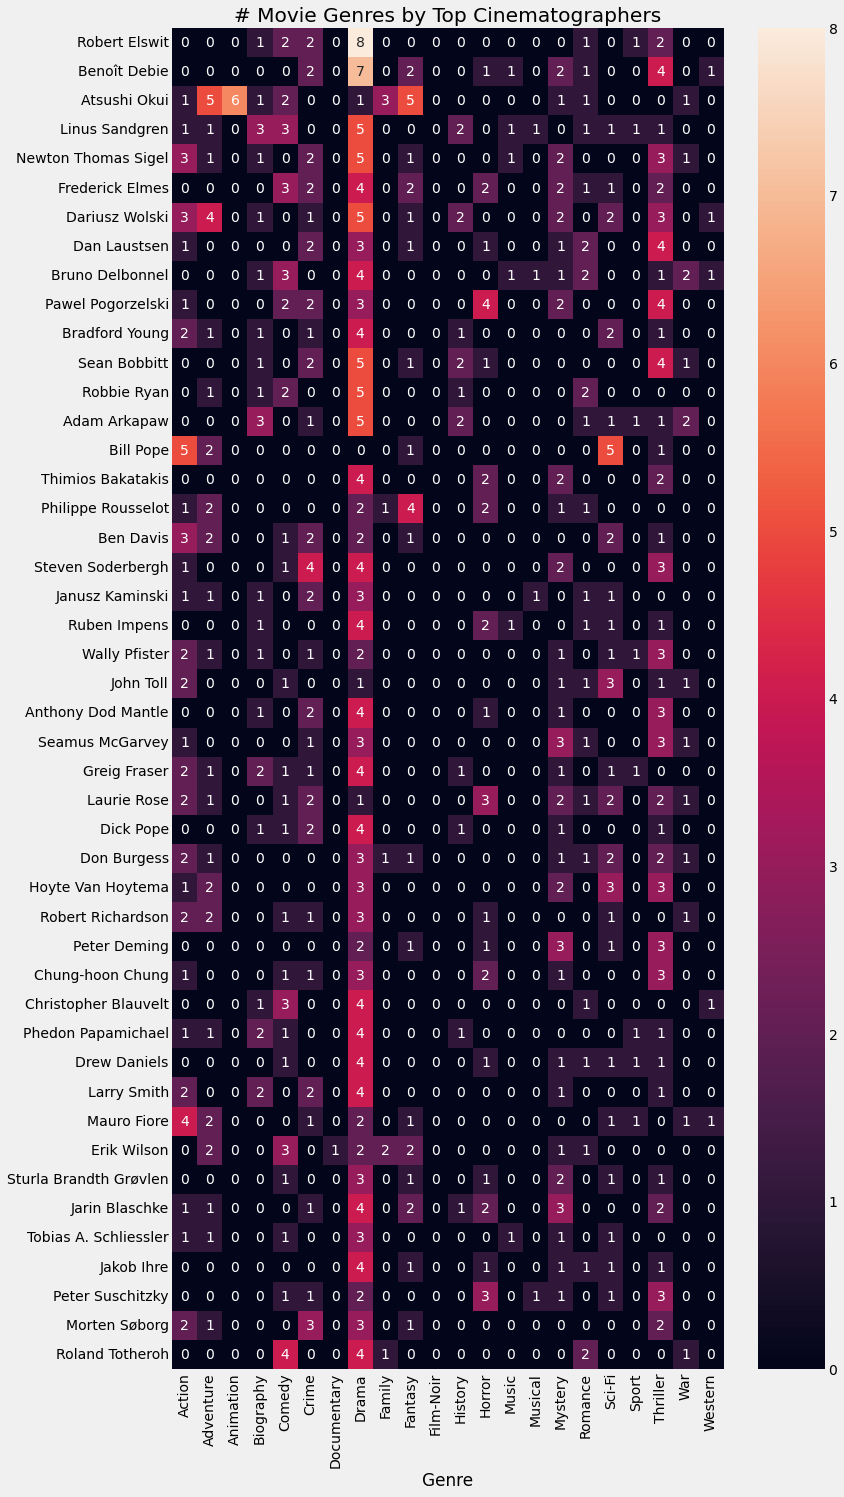

In [157]:
# Genre by Cinematographers
cols = ['Title','Cinematographer','Genre']
df_cinema_genre = df[cols].copy()

df_cinema_genre = split_explode(df_cinema_genre, 'Genre')
df_cinema_genre = split_explode(df_cinema_genre, 'Cinematographer')

cinema_movies = counter_display(df_cinema, 'Cinematographer', 'Title', N).index
plot_ct_cinema_genre = pd.crosstab(df_cinema_genre['Cinematographer'], df_cinema_genre['Genre']).loc[cinema_movies].iloc[1:,:]

# Plot
xsize = len(plot_ct_cinema_genre.columns) // 2
ysize = len(plot_ct_cinema_genre.index) // 2

fig, ax = plt.subplots(figsize=(xsize,ysize))
ax = sns.heatmap(plot_ct_cinema_genre, annot=True, fmt="d")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.title('# Movie Genres by Top Cinematographers');

In [158]:
# Top partnerships between Cinematographer / Director
N = 10

df_cinema_pair = df_cinema.copy()

gb_cinema_director_pair = double_group_info(df_cinema_pair, 'Cinematographer', 'Director', 1)
show_all(gb_cinema_director_pair.nlargest(N, ('Title','count'), keep='all').style.background_gradient(subset='imdbRating').set_precision(2))

In [159]:
# Partnership between Cinematographer / Director (at least 2 movies)
df_cinema_director = df_cinema[['Cinematographer','Director','Title']].copy()
df_cinema_director = split_explode(df_cinema_director, 'Cinematographer')
df_cinema_director = split_explode(df_cinema_director, 'Director')

gb_cinema_director = df_cinema_director.groupby(['Cinematographer','Director']).agg({'Title':['count','; '.join]})
show_all(gb_cinema_director[gb_cinema_director[('Title','count')] > 1])

## Actors

In [160]:
# Set actors dataframe
cols = ['Title','Year','Genre','Director','Actors','imdbRating']

df_actors = df[cols].copy()

# Filter documentaries
condition = 'Documentary'
query = "Genre not in '" + condition + "'"
df_actors = df_actors[cols].query(query).copy()

# Drop duplicates
df_actors.drop_duplicates(subset=['Title','Year','Director'], keep='first', inplace=True) # include director for cases likes Swan Song (2021)

# Drop list of 'too small role' - 'uncredited' actors with multiple appearances 
list_actors_drop = ['Mark Falvo','Arnold Montey','Rosemary Howard','Jimmy Star',
                    'Joseph Oliveira','Bridget Hoffman','Kadrolsha Ona Carole','Richard Price',
                    'Doris McCarthy','Bern Collaço','Dee Bradley Baker','Jorge Leon Martinez',
                    'John Gettier','Jeffrey Neil','David Evestaff','Martin Palmer',
                    'Stan Lee','J. Nathan Simmons','Michael E. Stogner','John W. Iwanonkiw',
                    'Richard Nixon','John F. Kennedy','Lyndon B. Johnson', # US presidents appear a few times in documentaries
                    'Walter Cronkite']

df_actors['Actors'] = df_actors['Actors'].str.replace(', |'.join(list_actors_drop), '')
df_actors['Actors'] = df_actors['Actors'].str.replace(' ,','')

In [161]:
df_counter_actors = counter_display(df_actors, 'Actors', 'Title', None)

# Number of actors
len(df_counter_actors.index)

42841

In [162]:
# Top N actors
N = 20
df_top_actors = df_counter_actors.copy()

top_actors = df_top_actors.nlargest(N, 'Title', keep='all')

In [163]:
# Get list of top n actors
list_top_actors = top_actors.index.values
list_top_actors.sort()

# filtering by list of top actors
df_actor_rating = get_mean_value(df_actors, 'Actors', 'imdbRating')

In [164]:
# Actors with most movies watched
show_all(df_actor_rating.nlargest(N, 'Total', keep='all').style.background_gradient(subset='imdbRating').set_precision(2))

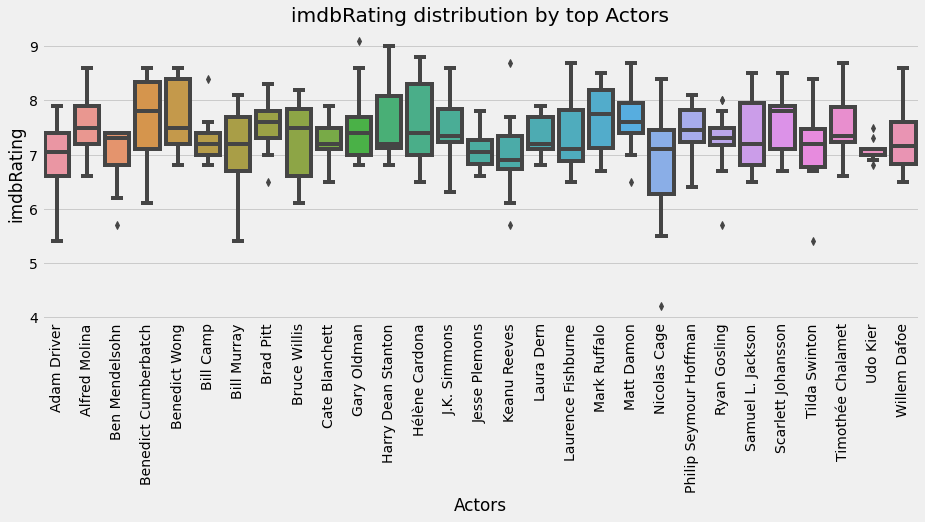

In [165]:
# Movie rating distribution by top Actors
df_dist_top_actor = df_actors.copy()

df_dist_top_actor = split_explode(df_dist_top_actor, 'Actors')    
df_dist_top_actor = df_dist_top_actor[df_dist_top_actor['Actors'].str.contains('|'.join(list_top_actors))]
df_dist_top_actor = df_dist_top_actor[['Actors','imdbRating']].sort_values(by='Actors')

x = df_dist_top_actor['Actors']
y = df_dist_top_actor['imdbRating']

# Plot
ratings = [1,10]
xsize = len(x.unique()) // 2
ysize = ratings[1] // 2

_, ax = plt.subplots(figsize=(xsize,ysize))
sns.boxplot(x, y)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90) 

plt.title('imdbRating distribution by top Actors')
plt.show()

In [166]:
# Highest rating actors
show_all(df_actor_rating[df_actor_rating['Total'] > 2].nlargest(N, 'imdbRating', keep='all')) # multiple results from The Godfather trilogy

In [167]:
# Lowest rating actors
show_all(df_actor_rating[df_actor_rating['Total'] > 1].nsmallest(N, 'imdbRating', keep='all'))

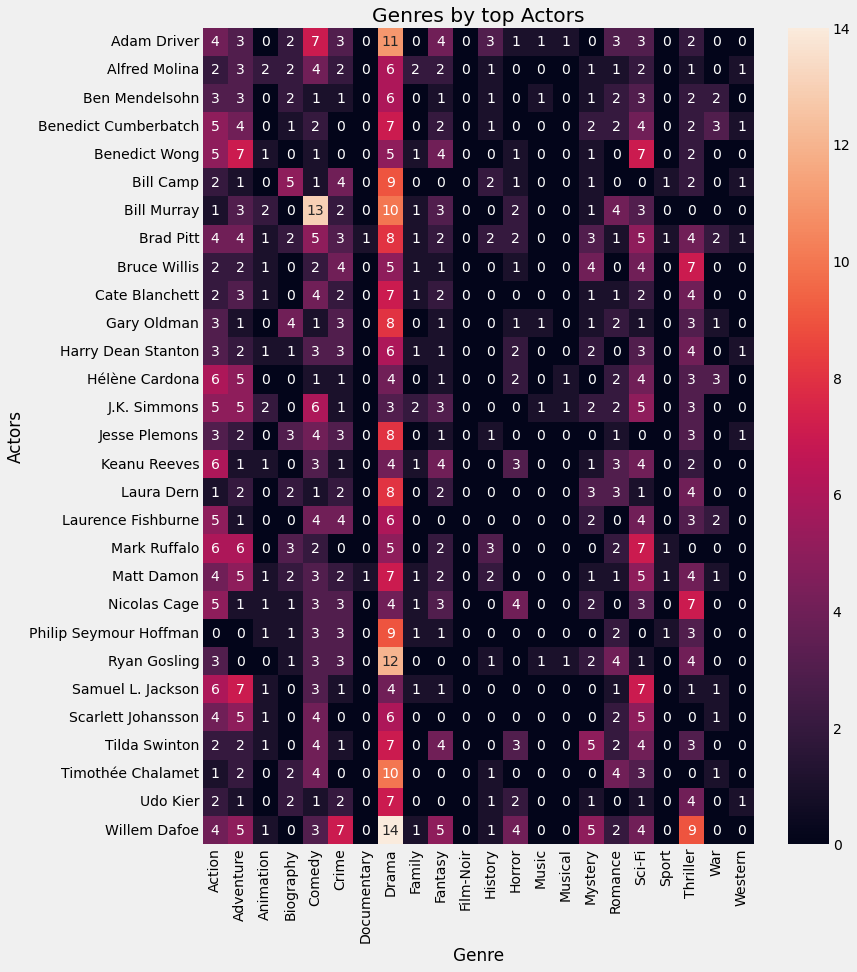

In [168]:
# Genre by Actor
df_genre_actor = df_actors.copy()

cols = ['Genre','Actors']
for col in cols:
    df_genre_actor = split_explode(df_genre_actor, col)

# Top actors
plot_ct_actor_genre = pd.crosstab(df_genre_actor['Actors'], df_genre_actor['Genre']).loc[list_top_actors]

# Plot
xsize = len(plot_ct_actor_genre.columns) // 2
ysize = len(plot_ct_actor_genre.index) // 2

_, ax = plt.subplots(figsize=(xsize,ysize))

plt.title('Genres by top Actors')
ax = sns.heatmap(plot_ct_actor_genre, annot=True, fmt="d")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90);

In [169]:
# Top actor in each genre
df_genre_top_actor = df_genre_actor.groupby(['Actors','Genre']).agg({'Title':['count','; '.join]}).sort_values(('Title','count'), ascending=False).reset_index()
df_genre_top_actor = df_genre_top_actor.groupby('Genre').apply(lambda x: x.nlargest(1, ('Title','count'), keep='first'))
df_genre_top_actor = df_genre_top_actor.droplevel(1).drop('Genre', axis=1)

show_all(df_genre_top_actor)

In [170]:
## search by specific actor
#df[df.Actors.str.contains('Tom Holland')] # Tom Holland != Tom Hollander

In [171]:
# Common Actors pairing
df_actors_pairs = pairing(df_actors, 'Actors')

## TOO MANY ADDITIONAL CREW ACTORS
# Show top pairs
N = 10
show_all(df_actors_pairs.nlargest(N, 'Count', keep='first'))

## Country

In [172]:
# Set country dataframe
cols = ['Title','Year','Director','Language','Country','imdbRating','Date']

df_country = df[cols].copy()

In [173]:
# Number of different countries
df_country_counter = counter_display(df_country, 'Country', 'Title', None)

len(df_country_counter.index)

66

In [174]:
# Country of last watched movies
N = 10
df_country.tail(N)

Title  Year           Director  \
946            The Informer  2019  Andrea Di Stefano   
947              To Die For  1995       Gus Van Sant   
948  All My Friends Hate Me  2021     Andrew Gaynord   
949                Triangle  2009  Christopher Smith   
950      Night of the Kings  2020    Philippe Lacôte   
951         Mysterious Skin  2004        Gregg Araki   
952         Boyz n the Hood  1991     John Singleton   
953                Cruising  1980   William Friedkin   
954             Lord of War  2005      Andrew Niccol   
955           Hunter Hunter  2020       Shawn Linden   

                                              Language  \
946                           English, Polish, Spanish   
947                                            English   
948                                            English   
949                                            English   
950                               French, Dyula, Nushi   
951                                            English   
952                                            English   
953                                            English   
954  English, Ukrainian, German, Spanish, Russian, ...   
955                                            English   

                                    Country  imdbRating       Date  
946   United Kingdom, Canada, United States         6.6 2022-04-27  
947   United States, United Kingdom, Canada         6.8 2022-04-28  
948                          United Kingdom         5.9 2022-04-29  
949               United Kingdom, Australia         6.9 2022-04-30  
950  France, Côte d’Ivoire, Canada, Senegal         6.6 2022-05-02  
951              United States, Netherlands         7.6 2022-05-03  
952                           United States         7.8 2022-05-05  
953             West Germany, United States         6.5 2022-05-06  
954          France, Germany, United States         7.6 2022-05-07  
955                   Canada, United States         6.4 2022-05-08

In [175]:
# Top countries
TOP = 30

# Simple solution without filtering by year 
#df_country_counter.nlargest(N, 'Title', keep='all')

# create dataframe
for year in years:
    if year == years[0]:
        df_country_counter_year = counter_display(df_country[df_country['Date'].dt.year == year], 'Country', 'Title', None).copy()
        df_country_counter_year = df_country_counter_year.reset_index()
        df_country_counter_year.columns = ['index', year]
    else:
        add_country = counter_display(df_country[df_country['Date'].dt.year == year], 'Country', 'Title', None).reset_index()
        add_country.columns = ['index',year]
        # merge new year counter
        df_country_counter_year = df_country_counter_year.merge(add_country, how='outer', on='index')

df_country_counter_year.rename(columns={'index':'Country'}, inplace=True)
df_country_counter_year.set_index('Country', inplace=True)
df_country_counter_year = df_country_counter_year.fillna(0).astype(int)

# add 'All' column with sum by country
df_country_counter_year.loc[:,'All'] = df_country_counter_year.sum(axis=1)
# show TOP countries
df_country_counter_year = df_country_counter_year.nlargest(TOP, 'All', keep='all')

df_country_counter_year.style.background_gradient(subset=df_country_counter_year.columns[:-1], axis=1) # evaluate by country

# Top 2 countries is always US and UK (since 2018)
# 2021 holds most top results per country since it was the year with clearly most movies watched

In [176]:
# Countries with higher average rating
df_country_rat = get_mean_value(df_country, 'Country', 'imdbRating')

# List of top countries
top_countries = df_country_counter.index[:3] # drop top 3 countries - most common

df_country_filter = df_country_rat.reset_index() 
df_country_filter = df_country_filter[~df_country_filter['Country'].isin(top_countries)].set_index('Country')

# More than 3 movies watched
df_top_country_rat = df_country_filter[df_country_filter.Total > 3].nlargest(N, 'imdbRating', keep='all')

show_all(df_top_country_rat)

In [177]:
# Relation between Country / Director
df_country_director = df_country.copy()

gb_country_director_pair = double_group_info(df_country_director, 'Country', 'Director')
show_all(gb_country_director_pair)

## Language

In [178]:
# Set language dataframe
cols = ['Title','Year','Director','imdbRating','Language','Date']

df_language = df[cols].copy()

In [179]:
# Number of different languages
df_language_counter = counter_display(df, 'Language', 'Title', None)

len(df_language_counter.index)

103

In [180]:
# Language of last watched movies
N = 10
df_language.tail(N)

Title  Year           Director  imdbRating  \
946            The Informer  2019  Andrea Di Stefano         6.6   
947              To Die For  1995       Gus Van Sant         6.8   
948  All My Friends Hate Me  2021     Andrew Gaynord         5.9   
949                Triangle  2009  Christopher Smith         6.9   
950      Night of the Kings  2020    Philippe Lacôte         6.6   
951         Mysterious Skin  2004        Gregg Araki         7.6   
952         Boyz n the Hood  1991     John Singleton         7.8   
953                Cruising  1980   William Friedkin         6.5   
954             Lord of War  2005      Andrew Niccol         7.6   
955           Hunter Hunter  2020       Shawn Linden         6.4   

                                              Language       Date  
946                           English, Polish, Spanish 2022-04-27  
947                                            English 2022-04-28  
948                                            English 2022-04-29  
949                                            English 2022-04-30  
950                               French, Dyula, Nushi 2022-05-02  
951                                            English 2022-05-03  
952                                            English 2022-05-05  
953                                            English 2022-05-06  
954  English, Ukrainian, German, Spanish, Russian, ... 2022-05-07  
955                                            English 2022-05-08

In [181]:
# Top languages
TOP = 30

# Simple solution without filtering by year 
#df_language_counter.nlargest(N, 'Title', keep='all')

# create dataframe
for year in years:
    if year == years[0]:
        df_language_counter_year = counter_display(df_language[df_language['Date'].dt.year == year], 'Language', 'Title', None).copy()
        df_language_counter_year = df_language_counter_year.reset_index()
        df_language_counter_year.columns = ['index', year]
    else:
        add_language = counter_display(df_language[df_language['Date'].dt.year == year], 'Language', 'Title', None).reset_index()
        add_language.columns = ['index',year]
        # merge new year counter
        df_language_counter_year = df_language_counter_year.merge(add_language, how='outer', on='index')

df_language_counter_year.rename(columns={'index':'Language'}, inplace=True)
df_language_counter_year.set_index('Language', inplace=True)
df_language_counter_year = df_language_counter_year.fillna(0).astype(int)

# add 'All' column with sum by language
df_language_counter_year.loc[:,'All'] = df_language_counter_year.sum(axis=1)
# show TOP languages
df_language_counter_year = df_language_counter_year.nlargest(TOP, 'All', keep='all')

df_language_counter_year.style.background_gradient(subset=df_language_counter_year.columns[:-1], axis=1) # evaluate by languange

In [182]:
# Language average rating
df_language_rat = get_mean_value(df_language, 'Language', 'imdbRating')

# List top languages
top_countries = df_language_counter.index[:3] # drop top 3 languages (english, french, spanish)

df_language_filter = df_language_rat.reset_index() 
df_language_filter = df_language_filter[~df_language_filter['Language'].isin(top_countries)].set_index('Language')

# More than 3 movies watched
df_top_language_rat = df_language_filter[df_language_filter.Total > 3].nlargest(N, 'imdbRating', keep='all')

show_all(df_top_language_rat)

In [183]:
# Relation between Language / Director
df_language_director = df_language.copy()

gb_language_director_pair = double_group_info(df_language_director, 'Language', 'Director')
show_all(gb_language_director_pair)

## Rating

In [184]:
# Example
# https://codingnomads.co/blog/data-analysis-example-analyzing-movie-ratings-with-python/

In [185]:
# Update metascore
df = omdb.update_metascore(df, current_year)

In [186]:
# Set rating dataframe
cols = ['Title','Year','Runtime','Genre','Language','Metascore','imdbRating','imdbVotes','Date']

df_rating = df[cols].copy()

In [187]:
# imdbRating and Metascore stats
df_rating[['imdbRating', 'Metascore']][df['Metascore'] != 0].describe().round(2)

imdbRating  Metascore
count      845.00     845.00
mean         7.15      71.42
std          0.67      12.56
min          3.60       9.00
25%          6.70      64.00
50%          7.10      72.00
75%          7.60      80.00
max          9.20     100.00

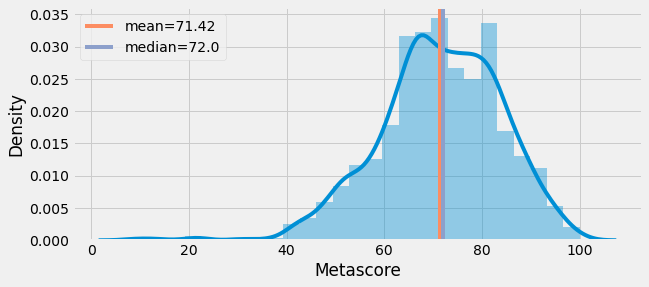

In [188]:
# Metascore distribution
plot_meta = df_rating[df_rating['Metascore'] != 0]['Metascore']

# Plot Metascore
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)

ax1 = sns.distplot(plot_meta, kde_kws=dict(bw=0.2))
ax1.axvline(x=plot_meta.mean(), c=sns.color_palette("Set2")[1], label=f"mean={round(plot_meta.mean(), 2)}")
ax1.axvline(x=plot_meta.median(), c=sns.color_palette("Set2")[2], label=f"median={round(plot_meta.median(), 2)}")
plt.legend();

In [189]:
## https://en.wikipedia.org/wiki/Kurtosis
# Like skewness, kurtosis describes the shape of a probability distribution and there are different ways of quantifying it for a theoretical distribution 
# and corresponding ways of estimating it from a sample from a population
plot_meta.kurtosis()

1.148297040706157

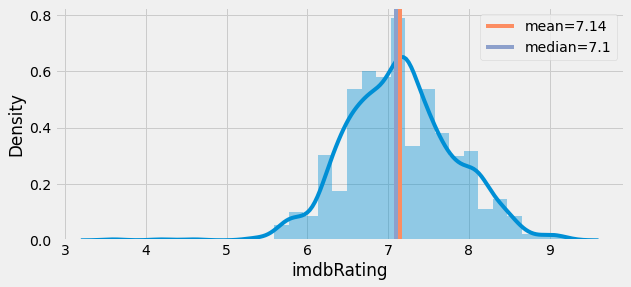

In [190]:
# imdbRating distribution
plot_rating = df_rating['imdbRating']

# Plot imdbRating
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)

ax1 = sns.distplot(plot_rating, kde_kws=dict(bw=0.2))
ax1.axvline(x=plot_rating.mean(), c=sns.color_palette("Set2")[1], label=f"mean={round(plot_rating.mean(), 2)}")
ax1.axvline(x=plot_rating.median(), c=sns.color_palette("Set2")[2], label=f"median={round(plot_rating.median(), 2)}")
plt.legend();

In [191]:
## https://en.wikipedia.org/wiki/Kurtosis
# Like skewness, kurtosis describes the shape of a probability distribution and there are different ways of quantifying it for a theoretical distribution 
# and corresponding ways of estimating it from a sample from a population
plot_rating.kurtosis()

0.9832203771305323

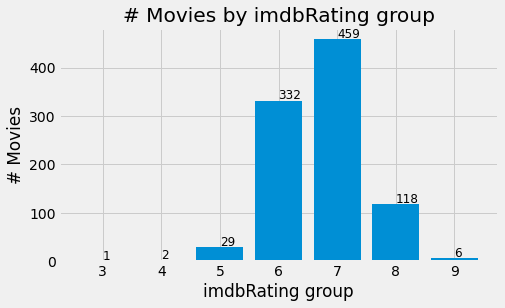

In [192]:
# Number of movies by imdbRating group
df_rating_group = df_rating[['Title', 'imdbRating']].groupby((df_rating['imdbRating']//1)).agg({'Title': 'count'})

x = df_rating_group.index
y = df_rating_group['Title']

# Plot
xsize = len(x)
ysize = len(y) - (len(y) // 2)

plt.figure(figsize=(xsize,ysize))
plt.bar(x,y)

for i, rate in enumerate(y):
    plt.text(i+3, rate+3, rate, fontdict={'fontsize':12})

plt.title('# Movies by imdbRating group')
plt.xlabel('imdbRating group')
plt.ylabel('# Movies')
plt.show()

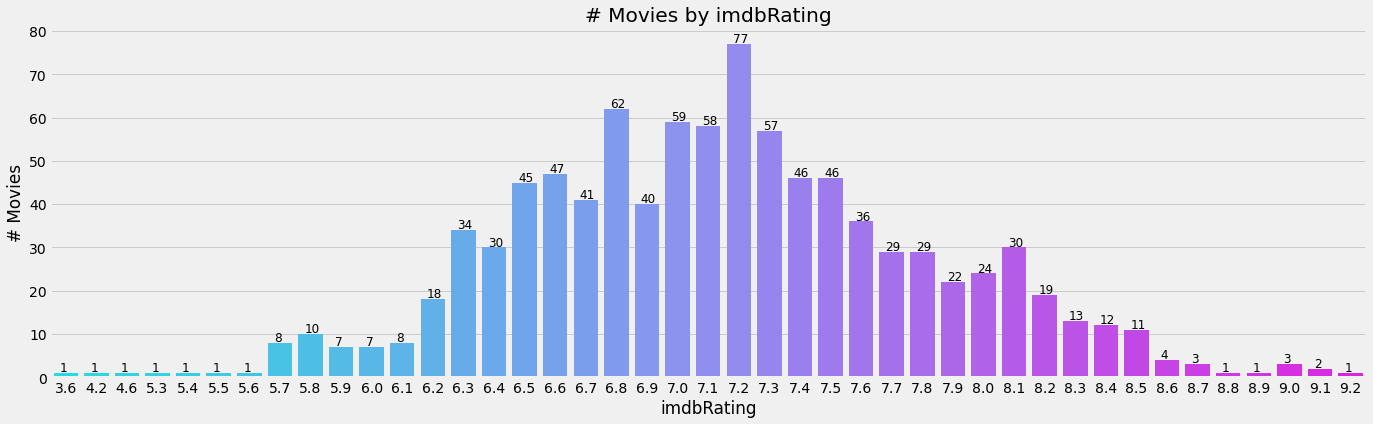

In [193]:
# Number of movies by imdbRating value
df_rating_float = df_rating[['Title', 'imdbRating']].groupby((df_rating['imdbRating'])).agg({'Title': 'count'})

x = np.round(df_rating_float.index, 1)
y = df_rating_float.Title

# Plot
xsize = len(df_rating_float.index) // 2

plt.figure(figsize=(xsize,6))
sns.barplot(x=x, y=y, palette="cool");

for i, rate in enumerate(y):
    plt.text(i-0.2, rate+0.4, rate, fontdict={'fontsize':12})

plt.title('# Movies by imdbRating')
plt.ylabel('# Movies')
plt.show()

In [194]:
# search by rating
rating = 6

gb_rating_below = df_rating[df_rating['imdbRating'] < rating][['Title','Runtime','imdbRating']].sort_values(by='imdbRating').groupby('imdbRating').agg({'Title':'; '.join})
show_all(gb_rating_below)

In [195]:
# Movies watched this year below rating (see above)
df_rating[df_rating['Date'].dt.year == current_year][df_rating['imdbRating'] < rating][['Title','Runtime','imdbRating']].sort_values(by='imdbRating')

Title  Runtime  imdbRating
841  Prisoners of the Ghostland      103         4.2
814                  Lost River       95         5.7
840        The Greasy Strangler       93         5.7
892            Save Yourselves!       93         5.7
902                  Studio 666      106         5.8
864            Uncle Peckerhead       97         5.9
870                         Cam       94         5.9
941                  Hellbender       86         5.9
948      All My Friends Hate Me       93         5.9

In [196]:
# Movies with highest rating watched this year
df_current_year = df_rating[df_rating['Date'].dt.year == current_year]

# no documentaries, no duplicated
df_current_year = df_current_year[~df_current_year['Genre'].str.contains('Documentary')][~df.duplicated(['Title','Year'], keep='last')]
df_current_year.nlargest(N, 'imdbRating', keep='all')

Title  Year  Runtime  \
933  Everything Everywhere All at Once  2022      139   
795                       Interstellar  2014      169   
907    One Flew Over the Cuckoo's Nest  1975      133   
889            Spider-Man: No Way Home  2021      148   
806                        City Lights  1931       87   
810                       Modern Times  1936       87   
853                            Amadeus  1984      160   
873                 The Great Dictator  1940      125   
801                            The Kid  1921       68   
891                 Lawrence of Arabia  1962      218   
927               Inglourious Basterds  2009      153   
929                                  M  1931      117   

                                          Genre  \
933  Action, Adventure, Comedy, Fantasy, Sci-Fi   
795                    Adventure, Drama, Sci-Fi   
907                                       Drama   
889          Action, Adventure, Fantasy, Sci-Fi   
806                      Comedy, Drama, Romance   
810                      Comedy, Drama, Romance   
853                     Biography, Drama, Music   
873                          Comedy, Drama, War   
801                       Comedy, Drama, Family   
891            Adventure, Biography, Drama, War   
927                       Adventure, Drama, War   
929                    Crime, Mystery, Thriller   

                             Language  Metascore  imdbRating  imdbVotes  \
933      English, Mandarin, Cantonese         82         8.9      20165   
795                           English         74         8.7    1707089   
907                           English         84         8.7     977848   
889                           English         71         8.6     539929   
806                     None, English         99         8.5     180503   
810                           English         96         8.5     235595   
853   English, Italian, Latin, German         88         8.4     391227   
873         English, Esperanto, Latin          0         8.4     218787   
801                           English          0         8.3     123711   
891          English, Arabic, Turkish        100         8.3     286185   
927  English, German, French, Italian         69         8.3    1386523   
929                            German          0         8.3     154872   

          Date  
933 2022-04-17  
795 2022-01-01  
907 2022-03-26  
889 2022-03-12  
806 2022-01-05  
810 2022-01-09  
853 2022-02-06  
873 2022-02-24  
801 2022-01-03  
891 2022-03-13  
927 2022-04-10  
929 2022-04-12

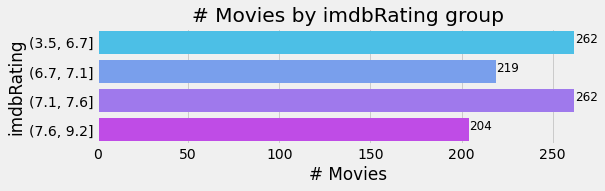

In [197]:
# Number of movies by imdbRating group

# https://medium.com/analytics-vidhya/exploratory-data-analysis-imdb-dataset-cff0c3991ad5
[groups, edges] = pd.qcut(df_rating['imdbRating'], q=4, precision=1, retbins=True) # 4 for quartiles
ratings_avg = df_rating.groupby(groups).agg({"Title": 'count'})

# Plot
ysize = len(ratings_avg) // 2

plt.figure(figsize=(8,ysize))
sns.barplot(y=ratings_avg.index, x=ratings_avg['Title'], palette='cool')
plt.title('# Movies by imdbRating group')
plt.xlabel('# Movies')

for i, rate in enumerate(ratings_avg["Title"]):
    plt.text(rate+0.1, i, rate, fontdict={'fontsize':12})

plt.show()

In [198]:
# Movies ranked in the 25th percentile minus 2 standard deviations
qtl_2std = df_rating['imdbRating'].quantile(0.25) - 2*df_rating['imdbRating'].std()
df_rating[df_rating['imdbRating'] < qtl_2std]

Title  Year  Runtime  \
169                        Geostorm  2017      109   
193                        The Room  2003       99   
204  The First Temptation of Christ  2019       46   
841      Prisoners of the Ghostland  2021      103   

                                 Genre  \
169           Action, Sci-Fi, Thriller   
193                              Drama   
204                             Comedy   
841  Action, Fantasy, Sci-Fi, Thriller   

                                        Language  Metascore  imdbRating  \
169  English, Cantonese, Russian, Hindi, Spanish         21         5.3   
193                                      English          9         3.6   
204                                   Portuguese          0         4.6   
841          English, Japanese, Mandarin, French         53         4.2   

     imdbVotes       Date  
169     104779 2020-03-21  
193      87707 2020-04-22  
204       3381 2020-05-04  
841       9683 2022-01-28

### Hidden Gems

In [199]:
# Select columns and data
df_hidden_gems = df_rating.copy()

# General filter
df_hidden_gems = df_hidden_gems[df_hidden_gems['Year'] < current_year-1]
df_hidden_gems = df_hidden_gems[~df_hidden_gems['Genre'].str.contains('Documentary')]

df_hidden_gems['Metascore'].replace('N/A', 0, regex=True, inplace=True)
df_hidden_gems['Metascore'] = df_hidden_gems['Metascore'].astype(int)

# Sum imdbRating with normalized metascore to create a global rating
df_hidden_gems['Rate20'] = df_hidden_gems['imdbRating'] + (df_hidden_gems['Metascore'] / 10)

# Stats
df_hidden_gems_stats = df_hidden_gems.describe().round(1)
# Select columns to show statistics
cols = df_hidden_gems_stats.columns.values
cols = np.delete(cols, [3,5])
# Show
df_hidden_gems_stats[cols] = df_hidden_gems_stats[cols].astype(int)
df_hidden_gems_stats

Year  Runtime  Metascore  imdbRating  imdbVotes  Rate20
count   787      787        787       787.0        787   787.0
mean   2009      110         64         7.1     162391    13.6
std      14       21         24         0.7     255797     2.7
min    1921       41          0         3.6        676     4.5
25%    2005       96         61         6.7      20082    12.9
50%    2016      107         70         7.1      72809    14.0
75%    2018      123         80         7.6     193324    15.3
max    2020      218        100         9.2    2524553    19.2

In [200]:
# Filter by number of votes and rating
print('A hidden gem is a movie with the following parameters:')
vote_qtl = df_hidden_gems['imdbVotes'].quantile(0.25) # less than 25% quantile of votes
print(f'- Less than 25% quantile of votes: {int(vote_qtl)} votes')
rate20_qtl = df_hidden_gems['Rate20'].quantile(0.35) # more than 35% quantile of rate20 (imdbRating + Metascore*)
print(f'- A combined rating of more than 35% quantile of rate20: {rate20_qtl}')
print()

df_hidden_gems = df_hidden_gems[df_hidden_gems['imdbVotes'] < vote_qtl][df_hidden_gems['Rate20'] > rate20_qtl]

# Hidden gems watched by Year
[
    [
        print(str(year)),
        show_all(df_hidden_gems[df_hidden_gems['Date'].dt.year == year].nlargest(20, 'Rate20', keep='all')),
        print('\n')
    ] for year in years
];

A hidden gem is a movie with the following parameters:
- Less than 25% quantile of votes: 20082 votes
- A combined rating of more than 35% quantile of rate20: 13.3

2018




2019




2020




2021




2022


### Runtime - imdbRating correlation

In [201]:
# Correlation?
df_rating[['Runtime','imdbRating']].corr(method='pearson').round(2)

Runtime  imdbRating
Runtime        1.00        0.29
imdbRating     0.29        1.00

In [202]:
# Stats
df_runtime_rating = df_rating[['Runtime','imdbRating']].copy()
df_runtime_rating.describe().round(1)

Runtime  imdbRating
count    947.0       947.0
mean     110.1         7.1
std       21.8         0.7
min       40.0         3.6
25%       95.0         6.7
50%      107.0         7.1
75%      122.5         7.6
max      218.0         9.2

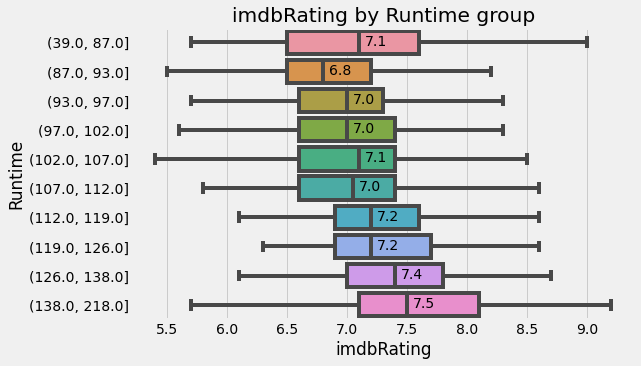

In [203]:
# https://medium.com/analytics-vidhya/exploratory-data-analysis-imdb-dataset-cff0c3991ad5
[groups, edges] = pd.qcut(df_runtime_rating['Runtime'], 10, precision=0, retbins=True)
ratings_avg = df_runtime_rating.groupby(groups).agg({"imdbRating": np.median})

# Plot
ysize = len(ratings_avg) // 2

plt.figure(figsize=(8,ysize))
sns.boxplot(y=groups, x="imdbRating", data=df_runtime_rating, orient="h", showfliers=False)

for i, rate in enumerate(ratings_avg["imdbRating"]):
    plt.text(rate+0.05, i+0.1, round(rate,1))

plt.title('imdbRating by Runtime group')
plt.show()

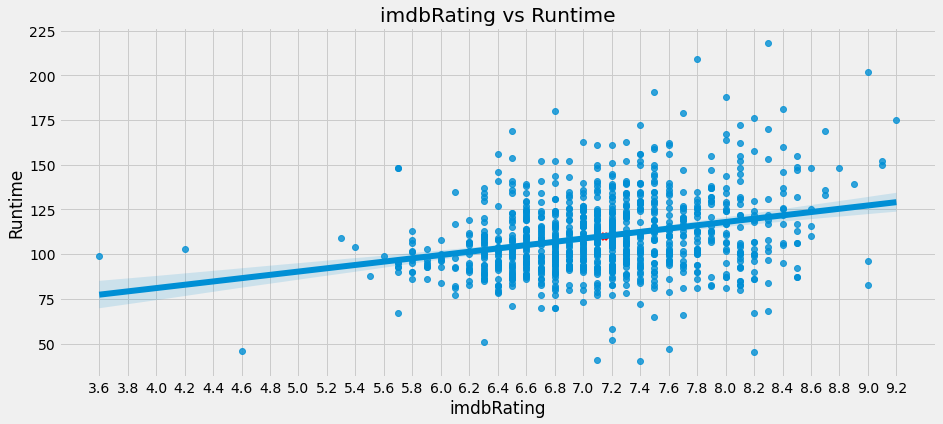

In [204]:
# Movie centroid based on runtime and imdbRating
x = df_runtime_rating['imdbRating']
y = df_runtime_rating['Runtime']
centroid = df_runtime_rating.mean(axis=0) # centroid

# Plot
xticks = np.arange(x.min(), x.max()+0.1, step=0.2)
xsize = len(xticks) // 2

plt.figure(figsize=(xsize, 6))  
sns.regplot(x=x, y=y); 
plt.scatter(centroid[1], centroid[0], color='r', marker='x');

plt.xticks(xticks)
plt.title('imdbRating vs Runtime')
plt.show()

In [205]:
# https://stackoverflow.com/questions/45418353/get-nearest-coordinates-from-pandas-df-from-centroid-of-coordinates

# The center will just be the average x and y 
# plotme.sub(plotme.mean()).pow(2).sum(1).idxmin()
#df.loc[plotme.loc[[plotme.sub(plotme.mean()).pow(2).sum(1).idxmin()]].index]

centroid

Runtime       110.098205
imdbRating      7.144562
dtype: float64

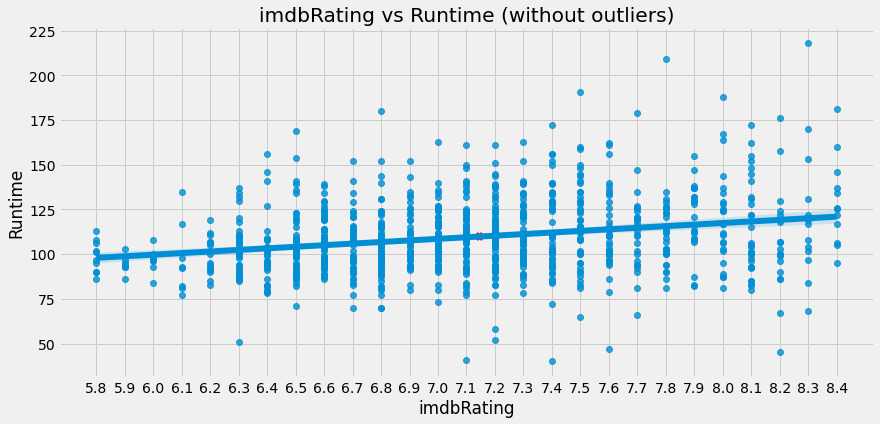

In [206]:
# https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
# Movie centroid based on runtime and imdbRating
# without outliers
df_runtime_rating_out = df_runtime_rating[np.abs(df_runtime_rating['imdbRating'] - df_runtime_rating['imdbRating'].mean()) <= (2*df_runtime_rating['imdbRating'].std())] # 2 std

x = df_runtime_rating_out['imdbRating']
y = df_runtime_rating_out['Runtime']
centroid_out = df_runtime_rating_out.mean(axis=0) # centroid

# Plot
xticks = np.arange(x.min(), x.max()+0.1, step=0.1)
xsize = len(xticks) // 2

plt.figure(figsize=(xsize, 6))
sns.regplot(x=x, y=y); 
plt.scatter(centroid[1], centroid[0], color='r', marker='x');

plt.xticks(xticks)
plt.title('imdbRating vs Runtime (without outliers)')
plt.show()

In [207]:
# There's no big difference without outliers
centroid_out

Runtime       109.727373
imdbRating      7.130243
dtype: float64

In [208]:
# Movie closer to centroid, based on runtime and imdbRating
# sub - subtract mean runtime and rating values
# pow - exponential power
# sum - sum both columns (runtime, imdbRating)
# idxmin - get id of min value
id_min_diff = df_runtime_rating_out.sub(df_runtime_rating_out.mean()).pow(2).sum(1).idxmin()
df.loc[df_runtime_rating_out.loc[[id_min_diff]].index].iloc[:,:-6]

Title  Year   imdbID Rated  Runtime  Genre        Director  \
462  Palmer  2021  6857376     R      110  Drama  Fisher Stevens   

               Writer        Cinematographer  \
462  Cheryl Guerriero  Tobias A. Schliessler   

                                                Actors  \
462  Justin Timberlake, Ryder Allen, Alisha Wainwri...   

                                                  Plot Language  \
462  An ex-convict strikes up a friendship with a b...  English   

           Country  Metascore  imdbRating  imdbVotes  \
462  United States         53         7.2      32806   

                                            Production           Timestamp  \
462  Sidney Kimmel Entertainment, Hercules Film Fun... 2021-02-28 23:31:37   

          Date      Time  
462 2021-02-28  23:31:37

In [209]:
# Three closest movies to centroid (runtime / rating)
id_min_3diff = df_runtime_rating_out.sub(df_runtime_rating_out.mean()).pow(2).sum(1).nsmallest(3).index
df.loc[df_runtime_rating_out.loc[id_min_3diff].index].iloc[:,:-6]

Title  Year   imdbID      Rated  Runtime  \
462  Palmer  2021  6857376          R      110   
77   Border  2018  5501104          R      110   
518  Pusher  1996  0117407  Not Rated      110   

                                                 Genre              Director  \
462                                              Drama        Fisher Stevens   
77   Crime, Drama, Fantasy, Mystery, Romance, Thriller            Ali Abbasi   
518                                    Crime, Thriller  Nicolas Winding Refn   

                                                Writer        Cinematographer  \
462                                   Cheryl Guerriero  Tobias A. Schliessler   
77   Isabella Eklöf, Ali Abbasi, John Ajvide Lindqvist          Nadim Carlsen   
518                    Jens Dahl, Nicolas Winding Refn          Morten Søborg   

                                                Actors  \
462  Justin Timberlake, Ryder Allen, Alisha Wainwri...   
77   Eva Melander, Eero Milonoff, Jörgen Thorsson, ...   
518  Kim Bodnia, Zlatko Buric, Laura Drasbæk, Slavk...   

                                                  Plot  \
462  An ex-convict strikes up a friendship with a b...   
77   A customs officer who can smell fear develops ...   
518  A drug pusher grows increasingly desperate aft...   

                              Language          Country  Metascore  \
462                            English    United States         53   
77                    Swedish, English  Sweden, Denmark         75   
518  Danish, Swedish, Serbian, English          Denmark         72   

     imdbRating  imdbVotes                                         Production  \
462         7.2      32806  Sidney Kimmel Entertainment, Hercules Film Fun...   
77          7.0      28559  Meta Film Stockholm, Black Spark Film & TV, Kä...   
518         7.3      38908                               Balboa Entertainment   

              Timestamp       Date      Time  
462 2021-02-28 23:31:37 2021-02-28  23:31:37  
77  2019-03-16 00:32:00 2019-03-16  00:32:00  
518 2021-04-19 23:40:57 2021-04-19  23:40:57

### Metascore - imdbRating correlation

In [210]:
df_metaimdb = df_rating[~df_rating['Metascore'].isnull()]
df_metaimdb = df_metaimdb[df_metaimdb['Metascore'] != 0]
df_metaimdb['Metascore'] = df_metaimdb['Metascore'].fillna(0).astype(int)

# Correlation?
df_metaimdb[['Metascore','imdbRating']].corr(method='pearson').round(2)

Metascore  imdbRating
Metascore        1.00        0.49
imdbRating       0.49        1.00

In [211]:
# Convert Metascore to range 0-10
df_metaimdb['Meta10'] = df_metaimdb['Metascore'] / 10
# Difference between imdbRating and normalized Metascore
df_metaimdb['imdbMeta'] = df_metaimdb['imdbRating'] - df_metaimdb['Meta10']

# Reorder and select
cols = ['Title','Year','Genre','imdbRating','Meta10','imdbMeta']
df_metaimdb = df_metaimdb[cols]
df_metaimdb['Year'] = df_metaimdb['Year'].astype(int)

# Stats
df_metaimdb[['imdbRating','Meta10','imdbMeta']].describe().round(2)

imdbRating  Meta10  imdbMeta
count      845.00  845.00     845.0
mean         7.15    7.14       0.0
std          0.67    1.26       1.1
min          3.60    0.90      -2.4
25%          6.70    6.40      -0.8
50%          7.10    7.20      -0.1
75%          7.60    8.00       0.7
max          9.20   10.00       5.1

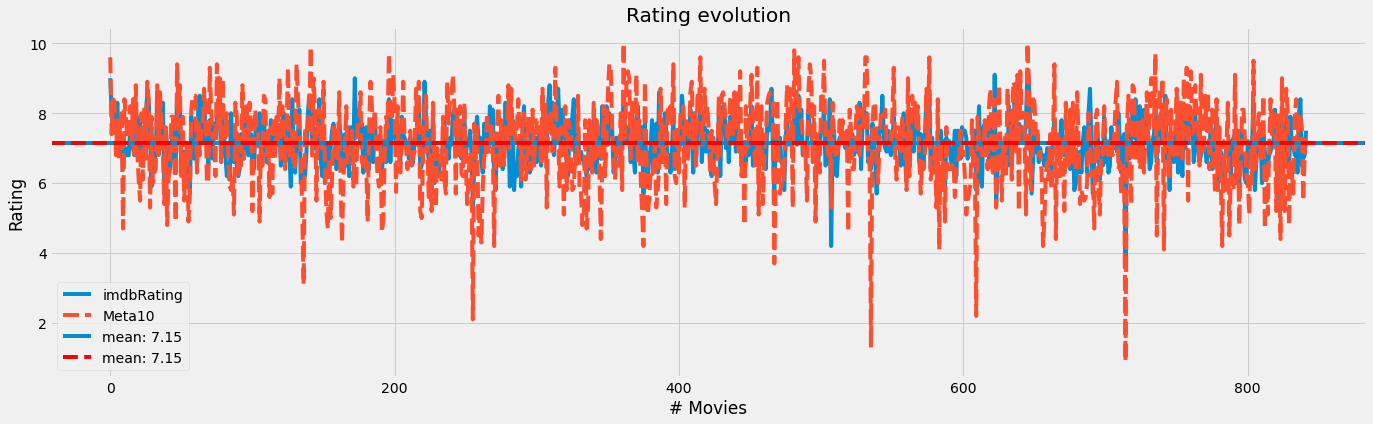

In [212]:
# imdbRating vs Meta10 variance
cols = ['Title','imdbRating','Meta10']
plot_imdbVSmeta = df_metaimdb[cols].groupby('Title').mean()
plot_imdbVSmeta = plot_imdbVSmeta.reset_index(drop=True)

x = plot_imdbVSmeta['imdbRating']
y = plot_imdbVSmeta['Meta10']

# Plot
xsize = len(x) // 40

plt.figure(figsize=(xsize,6))
sns.lineplot(data=plot_imdbVSmeta)

xlabel = 'mean: ' + str(round(x.mean(),2))
plt.axhline(y=x.mean(), label=xlabel)
ylabel = 'mean: ' + str(round(y.mean(),2))
plt.axhline(y=y.mean(), color='red', ls='--', label=ylabel)

plt.title('Rating evolution')
plt.xlabel('# Movies')
plt.ylabel('Rating')

plt.legend()
plt.show()

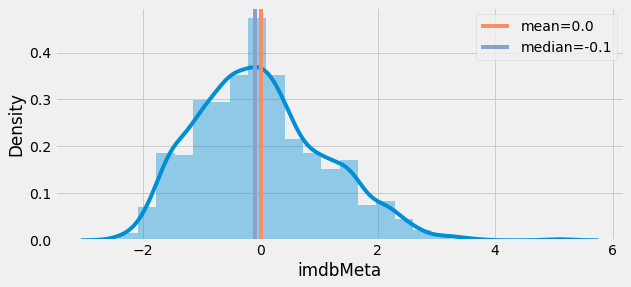

In [213]:
# imdbMeta distribution 
plot_metaimdb = df_metaimdb['imdbMeta']

# imdbMeta - difference between imdbRating and Metascore (converted to 0 to 10)
plt.figure(figsize=(20,4))

plt.subplot(1,2,1)
ax1 = sns.distplot(plot_metaimdb, kde_kws=dict(bw=0.2))
ax1.axvline(x=plot_metaimdb.mean(), c=sns.color_palette("Set2")[1], label=f"mean={round(plot_metaimdb.mean(), 2)}")
ax1.axvline(x=plot_metaimdb.median(), c=sns.color_palette("Set2")[2], label=f"median={round(plot_metaimdb.median(), 2)}")

plt.legend()
plt.show()

In [214]:
# Top differences between ratings
df_metaimdb.loc[abs(df_metaimdb['imdbMeta']).sort_values(ascending=False).index].nlargest(N, 'imdbMeta', keep='all')

Title  Year  \
612                 Run Hide Fight  2020   
530   The Babysitter: Killer Queen  2020   
312             Charlie Countryman  2013   
169                       Geostorm  2017   
788               The Unforgivable  2021   
490              Bohemian Rhapsody  2018   
193                       The Room  2003   
317                  The Gentlemen  2019   
829        Ghostbusters: Afterlife  2021   
250  Twin Peaks: Fire Walk with Me  1992   

                                        Genre  imdbRating  Meta10  imdbMeta  
612                    Crime, Drama, Thriller         6.4     1.3       5.1  
530                            Comedy, Horror         5.8     2.2       3.6  
312  Action, Comedy, Drama, Romance, Thriller         6.4     3.1       3.3  
169                  Action, Sci-Fi, Thriller         5.3     2.1       3.2  
788                              Crime, Drama         7.2     4.1       3.1  
490                   Biography, Drama, Music         8.0     4.9       3.1  
193                                     Drama         3.6     0.9       2.7  
317                     Action, Comedy, Crime         7.8     5.1       2.7  
829        Adventure, Comedy, Fantasy, Sci-Fi         7.2     4.5       2.7  
250          Drama, Horror, Mystery, Thriller         7.2     4.5       2.7

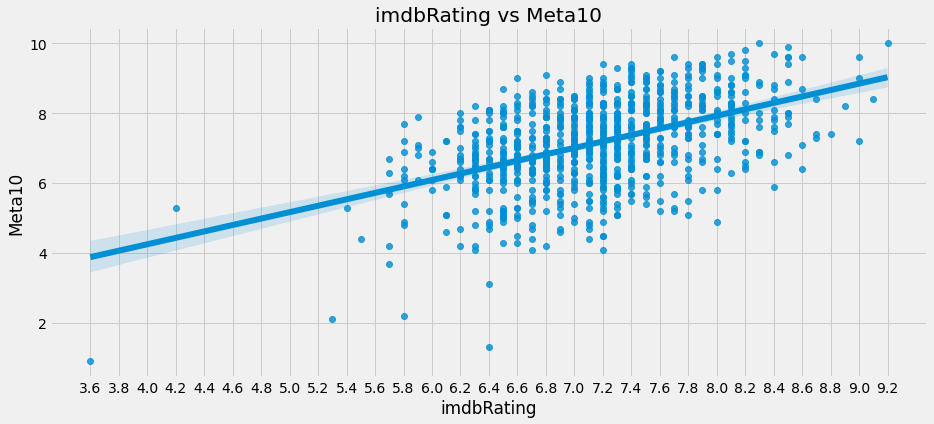

In [215]:
# Relationship between variables (all data)
xx = df_metaimdb['imdbRating']
yy = df_metaimdb['Meta10']

# Plot
# https://stackoverflow.com/questions/19068862/how-to-overplot-a-line-on-a-scatter-plot-in-python
xticks = np.arange(xx.min(), xx.max()+0.1, step=0.2)
xsize = len(xticks) // 2

plt.figure(figsize=(xsize, 6))
sns.regplot(x=xx, y=yy)
plt.xticks(xticks)

plt.title('imdbRating vs Meta10')
plt.show()

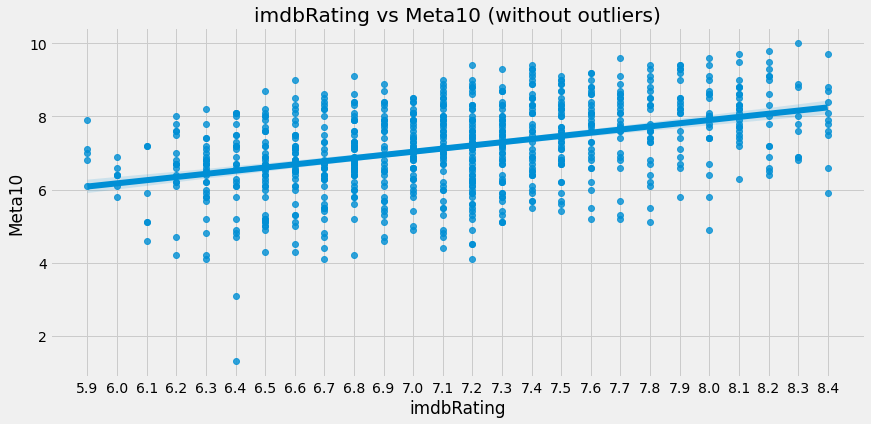

In [216]:
# Without outliers
df_metaimdb_out = df_metaimdb[np.abs(df_metaimdb['imdbRating'] - df_metaimdb['imdbRating'].mean()) 
                                <= (2*df_metaimdb['imdbRating'].std())] # 2 std

xx = df_metaimdb_out['imdbRating']
yy = df_metaimdb_out['Meta10']

# Plot
# https://stackoverflow.com/questions/19068862/how-to-overplot-a-line-on-a-scatter-plot-in-python
xticks = np.arange(xx.min(), xx.max()+0.1, step=0.1)
xsize = len(xticks) // 2

plt.figure(figsize=(xsize, 6))
sns.regplot(x=xx, y=yy)
plt.xticks(xticks)

plt.title('imdbRating vs Meta10 (without outliers)')
plt.show()

In [217]:
# better Metascore than imdbRating
print('Movies with better Metascore than imdbRating: ' + str(len(df_metaimdb[df_metaimdb['imdbMeta'] < 0])))

Movies with better Metascore than imdbRating: 437


In [218]:
# Movies with better Metascore than imdbRating
df_metaimdb[df_metaimdb['imdbMeta'] < 0].nsmallest(N, 'imdbMeta', keep='all')

Title  Year  \
573              The Swerve  2018   
457                    Time  2020   
358                   Carol  2015   
369    The Duke of Burgundy  2014   
421               Nomadland  2020   
790    The Power of the Dog  2021   
895            Petite Maman  2021   
948  All My Friends Hate Me  2021   
8                 Lady Bird  2017   
487               High Life  2018   
505     Inside Llewyn Davis  2013   
629        The Green Knight  2021   
689           Winter's Bone  2010   

                                                 Genre  imdbRating  Meta10  \
573                            Drama, Horror, Thriller         6.6     9.0   
457                             Documentary, Biography         6.8     9.1   
358                                     Drama, Romance         7.2     9.4   
369                                     Drama, Romance         6.5     8.7   
421                                              Drama         7.3     9.3   
790                            Drama, Romance, Western         6.9     8.9   
895                                     Drama, Fantasy         7.4     9.4   
948                                     Comedy, Horror         5.9     7.9   
8                                        Comedy, Drama         7.4     9.3   
487  Adventure, Drama, Horror, Mystery, Sci-Fi, Thr...         5.8     7.7   
505                               Comedy, Drama, Music         7.4     9.3   
629                          Adventure, Drama, Fantasy         6.6     8.5   
689                                     Drama, Mystery         7.1     9.0   

     imdbMeta  
573      -2.4  
457      -2.3  
358      -2.2  
369      -2.2  
421      -2.0  
790      -2.0  
895      -2.0  
948      -2.0  
8        -1.9  
487      -1.9  
505      -1.9  
629      -1.9  
689      -1.9

In [219]:
# negative imdbRating and positive Metascore 
print('Movies with negative imdbRating and positive Metascore: ' + str(len(df_metaimdb[df_metaimdb['imdbRating'] < 5][df_metaimdb['Meta10'] > 5])))

Movies with negative imdbRating and positive Metascore: 1


In [220]:
# Movies with negative imdbRating and positive Metascore 
df_metaimdb[df_metaimdb['imdbRating'] < 5][df_metaimdb['Meta10'] > 5]

Title  Year                              Genre  \
841  Prisoners of the Ghostland  2021  Action, Fantasy, Sci-Fi, Thriller   

     imdbRating  Meta10  imdbMeta  
841         4.2     5.3      -1.1

In [221]:
# better imdbRating than Metascore
print('Movies with better imdbRating than Metascore: ' + str(len(df_metaimdb[df_metaimdb['imdbMeta'] > 0])))

Movies with better imdbRating than Metascore: 380


In [222]:
# Movies with better imdbRating than Metascore
df_metaimdb[df_metaimdb['imdbMeta'] > 0].nlargest(N, 'imdbMeta', keep='all')

Title  Year  \
612                 Run Hide Fight  2020   
530   The Babysitter: Killer Queen  2020   
312             Charlie Countryman  2013   
169                       Geostorm  2017   
788               The Unforgivable  2021   
490              Bohemian Rhapsody  2018   
193                       The Room  2003   
250  Twin Peaks: Fire Walk with Me  1992   
317                  The Gentlemen  2019   
829        Ghostbusters: Afterlife  2021   

                                        Genre  imdbRating  Meta10  imdbMeta  
612                    Crime, Drama, Thriller         6.4     1.3       5.1  
530                            Comedy, Horror         5.8     2.2       3.6  
312  Action, Comedy, Drama, Romance, Thriller         6.4     3.1       3.3  
169                  Action, Sci-Fi, Thriller         5.3     2.1       3.2  
788                              Crime, Drama         7.2     4.1       3.1  
490                   Biography, Drama, Music         8.0     4.9       3.1  
193                                     Drama         3.6     0.9       2.7  
250          Drama, Horror, Mystery, Thriller         7.2     4.5       2.7  
317                     Action, Comedy, Crime         7.8     5.1       2.7  
829        Adventure, Comedy, Fantasy, Sci-Fi         7.2     4.5       2.7

In [223]:
# positive imdbRating and negative Metascore 
print('Movies with positive imdbRating and negative Metascore: ' + str(len(df_metaimdb[df_metaimdb['imdbRating'] > 5][df_metaimdb['Meta10'] < 5])))

Movies with positive imdbRating and negative Metascore: 39


In [224]:
# Movies with positive imdbRating and negative Metascore
df_metaimdb[df_metaimdb['imdbRating'] > 5][df_metaimdb['Meta10'] < 5].nlargest(N, 'imdbMeta', keep='all')

Title  Year  \
612                 Run Hide Fight  2020   
530   The Babysitter: Killer Queen  2020   
312             Charlie Countryman  2013   
169                       Geostorm  2017   
788               The Unforgivable  2021   
490              Bohemian Rhapsody  2018   
250  Twin Peaks: Fire Walk with Me  1992   
829        Ghostbusters: Afterlife  2021   
140                     The Jacket  2005   
445                           Stay  2005   

                                         Genre  imdbRating  Meta10  imdbMeta  
612                     Crime, Drama, Thriller         6.4     1.3       5.1  
530                             Comedy, Horror         5.8     2.2       3.6  
312   Action, Comedy, Drama, Romance, Thriller         6.4     3.1       3.3  
169                   Action, Sci-Fi, Thriller         5.3     2.1       3.2  
788                               Crime, Drama         7.2     4.1       3.1  
490                    Biography, Drama, Music         8.0     4.9       3.1  
250           Drama, Horror, Mystery, Thriller         7.2     4.5       2.7  
829         Adventure, Comedy, Fantasy, Sci-Fi         7.2     4.5       2.7  
140  Drama, Fantasy, Mystery, Sci-Fi, Thriller         7.1     4.4       2.7  
445                   Drama, Mystery, Thriller         6.7     4.1       2.6

In [225]:
# Matching rating
print('Movies with matching rating: ' + str(len(df_metaimdb[df_metaimdb['imdbMeta'] == 0])))

Movies with matching rating: 28


In [226]:
# Movies with matching rating (imdbRating = Meta10)
df_metaimdb[df_metaimdb['imdbMeta'] == 0]

Title  Year  \
56     Ant-Man and the Wasp  2018   
123            Run Lola Run  1998   
124              Layer Cake  2004   
133                  Primer  2004   
170                 Bronson  2008   
210                  Aliens  1986   
228          Ford v Ferrari  2019   
325                 Swallow  2019   
359                     Una  2016   
367    The Snowtown Murders  2011   
368     Journey to the West  2013   
398               Black Box  2020   
418          Corpus Christi  2019   
440                     Run  2020   
550        Army of the Dead  2021   
557  The Godfather: Part II  1974   
566          Public Enemies  2009   
579          Lady Vengeance  2005   
596              Inside Man  2006   
597             Black Widow  2021   
601    People Places Things  2015   
617       The Suicide Squad  2021   
635      Young Frankenstein  1974   
684    The Royal Tenenbaums  2001   
708                  Mirror  1975   
773                eXistenZ  1999   
777                   Drive  2011   
824             The Martian  2015   

                                           Genre  imdbRating  Meta10  imdbMeta  
56             Action, Adventure, Comedy, Sci-Fi         7.0     7.0       0.0  
123                       Crime, Drama, Thriller         7.7     7.7       0.0  
124               Action, Crime, Drama, Thriller         7.3     7.3       0.0  
133                      Drama, Sci-Fi, Thriller         6.8     6.8       0.0  
170              Action, Biography, Crime, Drama         7.1     7.1       0.0  
210          Action, Adventure, Sci-Fi, Thriller         8.4     8.4       0.0  
228              Action, Biography, Drama, Sport         8.1     8.1       0.0  
325                                        Drama         6.5     6.5       0.0  
359                                        Drama         6.2     6.2       0.0  
367                      Biography, Crime, Drama         6.6     6.6       0.0  
368  Action, Adventure, Comedy, Fantasy, Romance         6.8     6.8       0.0  
398            Horror, Mystery, Sci-Fi, Thriller         6.2     6.2       0.0  
418                                        Drama         7.7     7.7       0.0  
440                            Mystery, Thriller         6.7     6.7       0.0  
550      Action, Crime, Horror, Sci-Fi, Thriller         5.7     5.7       0.0  
557                                 Crime, Drama         9.0     9.0       0.0  
566     Action, Biography, Crime, Drama, History         7.0     7.0       0.0  
579                       Crime, Drama, Thriller         7.5     7.5       0.0  
596              Crime, Drama, Mystery, Thriller         7.6     7.6       0.0  
597                    Action, Adventure, Sci-Fi         6.7     6.7       0.0  
601                              Comedy, Romance         6.8     6.8       0.0  
617            Action, Adventure, Comedy, Sci-Fi         7.2     7.2       0.0  
635                                       Comedy         8.0     8.0       0.0  
684                                Comedy, Drama         7.6     7.6       0.0  
708                             Biography, Drama         8.0     8.0       0.0  
773            Horror, Mystery, Sci-Fi, Thriller         6.8     6.8       0.0  
777                                Action, Drama         7.8     7.8       0.0  
824                     Adventure, Drama, Sci-Fi         8.0     8.0       0.0

In [227]:
# Movies with most balanced reviews (minor difference between imdb and metascore rating), considering movies with a rating over the 75th quantile
df_best_movies = df_metaimdb[abs(df_metaimdb['imdbMeta']) < 1][df_metaimdb['imdbRating'] > df_metaimdb['imdbRating'].quantile(0.75)]
df_best_movies['imdbMeta'] = abs(df_best_movies['imdbMeta']).round(1)

show_all(df_best_movies.nsmallest(N, 'imdbMeta', keep='all').sort_values(['imdbRating','imdbMeta'], ascending=False))

In [228]:
# Top movies by total rating (imdbRating + Metascore*)
df_metaimdb['Rate20'] = df_metaimdb['imdbRating'] + df_metaimdb['Meta10']

df_metaimdb[df_metaimdb['Rate20'] > df_metaimdb['Rate20'].quantile(0.75)].nlargest(30, 'Rate20', keep='all')

Title  Year  \
249                                      The Godfather  1972   
743                                       12 Angry Men  1957   
806                                        City Lights  1931   
891                                 Lawrence of Arabia  1962   
62                                       Spirited Away  2001   
107                                           Parasite  2019   
673  Dr. Strangelove or: How I Learned to Stop Worr...  1964   
810                                       Modern Times  1936   
18                                     Pan's Labyrinth  2006   
557                             The Godfather: Part II  1974   
711                                     Apocalypse Now  1979   
811                                      The Third Man  1949   
480                                            Virunga  2014   
417                         Portrait of a Lady on Fire  2019   
622                                    Rosemary's Baby  1968   
34                                     The Dark Knight  2008   
722                                There Will Be Blood  2007   
192                                              Alien  1979   
714                                         La La Land  2016   
59                                                Roma  2018   
128                                     Marriage Story  2019   
760                                    Before Midnight  2013   
315                            They Shall Not Grow Old  2018   
377                             No Country for Old Men  2007   
787                                 Back to the Future  1985   
70                                         Shoplifters  2018   
182              Eternal Sunshine of the Spotless Mind  2004   
416                               Call Me by Your Name  2017   
853                                            Amadeus  1984   
58                                     The Truman Show  1998   
132                                       The Irishman  2019   

                                              Genre  imdbRating  Meta10  \
249                                    Crime, Drama         9.2    10.0   
743                                    Crime, Drama         9.0     9.6   
806                          Comedy, Drama, Romance         8.5     9.9   
891                Adventure, Biography, Drama, War         8.3    10.0   
62   Animation, Adventure, Family, Fantasy, Mystery         8.6     9.6   
107                         Comedy, Drama, Thriller         8.5     9.6   
673                                     Comedy, War         8.4     9.7   
810                          Comedy, Drama, Romance         8.5     9.6   
18                              Drama, Fantasy, War         8.2     9.8   
557                                    Crime, Drama         9.0     9.0   
711                             Drama, Mystery, War         8.5     9.4   
811                    Film-Noir, Mystery, Thriller         8.1     9.7   
480                                Documentary, War         8.2     9.5   
417                                  Drama, Romance         8.1     9.5   
622                                   Drama, Horror         8.0     9.6   
34                   Action, Crime, Drama, Thriller         9.1     8.4   
722                                           Drama         8.2     9.3   
192                                  Horror, Sci-Fi         8.5     8.9   
714          Comedy, Drama, Music, Musical, Romance         8.0     9.4   
59                                            Drama         7.7     9.6   
128                                  Drama, Romance         7.9     9.4   
760                                  Drama, Romance         7.9     9.4   
315                       Documentary, History, War         8.2     9.1   
377                          Crime, Drama, Thriller         8.2     9.1   
787                       Adventure, Comedy, Sci-Fi         8.6     8.7   
70                                     Crime, Dram

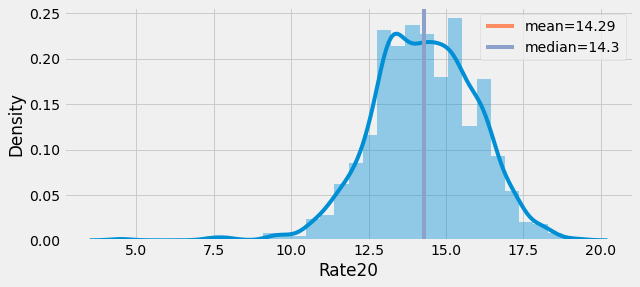

In [229]:
# Rate20 distribution 
plot_rate20 = df_metaimdb['Rate20']

# Plot Rate20
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
ax1 = sns.distplot(plot_rate20, kde_kws=dict(bw=0.2))

ax1.axvline(x=plot_rate20.mean(), c=sns.color_palette("Set2")[1], label=f"mean={round(plot_rate20.mean(), 2)}")
ax1.axvline(x=plot_rate20.median(), c=sns.color_palette("Set2")[2], label=f"median={round(plot_rate20.median(), 2)}")
plt.legend();

### Weighted average rating

In [230]:
# https://www.datacamp.com/community/tutorials/recommender-systems-python

# WeightedRating (WR) = (v/v+m * R) + (m/v+m * C)

# v is the number of votes for the movie;
# m is the minimum votes required to be listed in the chart;
# R is the average rating of the movie;
# C is the mean vote across the whole report.

In [231]:
df_rating['imdbVotes'].describe()

count    9.470000e+02
mean     1.453680e+05
std      2.396125e+05
min      8.700000e+01
25%      1.736300e+04
50%      6.041700e+04
75%      1.713055e+05
max      2.524553e+06
Name: imdbVotes, dtype: float64

In [232]:
# Calculate mean of imdbRating column
C = df_rating['imdbRating'].mean()
print('mean: ' + str(round(C, 2)))

# Calculate the minimum number of votes required to be in the chart, m
m = df_rating['imdbVotes'].quantile(0.25).astype(int) # 50th percentile
print('minimum votes: ' + str(m))

mean: 7.14
minimum votes: 17363


In [233]:
# Filter out all qualified movies into a new DataFrame
q_movies = df_rating.copy().loc[df_rating['imdbVotes'] > m]
q_movies.shape

(710, 9)

In [234]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
#q_movies['Score'] = q_movies.apply(weighted_rating(q_movies, m, C), axis=1)
v = q_movies['imdbVotes']
R = q_movies['imdbRating']
q_movies['Score'] = weighted_rating(v, R, m, C)

# Top N
N = 10
#Print the top n movies based on score
cols = ['Title', 'Year', 'imdbVotes', 'imdbRating', 'Score']
q_movies[cols].nlargest(N, 'Score', keep='all')

Title  Year  imdbVotes  imdbRating     Score
249                    The Godfather  1972    1763879         9.2  9.180321
34                   The Dark Knight  2008    2524553         9.1  9.086841
557           The Godfather: Part II  1974    1221218         9.0  8.973834
743                     12 Angry Men  1957     756999         9.0  8.958199
289                        Inception  2010    2249772         8.8  8.787605
750                       The Matrix  1999    1845835         8.7  8.685925
795                     Interstellar  2014    1707089         8.7  8.684402
907  One Flew Over the Cuckoo's Nest  1975     977848         8.7  8.673215
787               Back to the Future  1985    1150655         8.6  8.578158
733           Léon: The Professional  1994    1117761         8.6  8.577453

In [235]:
# Without weighted average
cols = ['Title', 'Year', 'imdbVotes', 'imdbRating']

df_rating[cols].nlargest(N, 'imdbRating', keep='all')

Title  Year  imdbVotes  imdbRating
249                             The Godfather  1972    1763879         9.2
27                 Hans Zimmer Live in Prague  2017       2622         9.1
34                            The Dark Knight  2008    2524553         9.1
316  David Attenborough: A Life on Our Planet  2020      30944         9.0
557                    The Godfather: Part II  1974    1221218         9.0
743                              12 Angry Men  1957     756999         9.0
933         Everything Everywhere All at Once  2022      20165         8.9
289                                 Inception  2010    2249772         8.8
750                                The Matrix  1999    1845835         8.7
795                              Interstellar  2014    1707089         8.7
907           One Flew Over the Cuckoo's Nest  1975     977848         8.7

## Votes

In [236]:
cols = ['Title', 'Year', 'Rated', 'Runtime', 'Genre', 'Director',
       'Writer', 'Language', 'Country', 'Metascore', 'imdbRating', 'imdbVotes', 'Production', 'Timestamp']

# Set votes dataframe
df_votes = df[cols].copy()

In [237]:
# imdbVotes statistics
df_votes['imdbVotes'].describe()

count    9.470000e+02
mean     1.453680e+05
std      2.396125e+05
min      8.700000e+01
25%      1.736300e+04
50%      6.041700e+04
75%      1.713055e+05
max      2.524553e+06
Name: imdbVotes, dtype: float64

In [238]:
# Movies with most imdbVotes
N = 5
df_votes.nlargest(N, 'imdbVotes', keep='all')

Title  Year  Rated  Runtime  \
34   The Dark Knight  2008  PG-13      152   
289        Inception  2010  PG-13      148   
750       The Matrix  1999      R      136   
249    The Godfather  1972      R      175   
795     Interstellar  2014  PG-13      169   

                                   Genre                         Director  \
34        Action, Crime, Drama, Thriller                Christopher Nolan   
289  Action, Adventure, Sci-Fi, Thriller                Christopher Nolan   
750                       Action, Sci-Fi  Lana Wachowski, Lilly Wachowski   
249                         Crime, Drama             Francis Ford Coppola   
795             Adventure, Drama, Sci-Fi                Christopher Nolan   

                                                Writer  \
34   Bob Kane, Jonathan Nolan, Christopher Nolan, D...   
289                                  Christopher Nolan   
750                    Lilly Wachowski, Lana Wachowski   
249                   Francis Ford Coppola, Mario Puzo   
795                  Jonathan Nolan, Christopher Nolan   

                      Language                                Country  \
34           English, Mandarin          United States, United Kingdom   
289  English, Japanese, French          United States, United Kingdom   
750                    English               United States, Australia   
249    English, Italian, Latin                          United States   
795                    English  United States, United Kingdom, Canada   

     Metascore  imdbRating  imdbVotes  \
34          84         9.1    2524553   
289         74         8.8    2249772   
750         73         8.7    1845835   
249        100         9.2    1763879   
795         74         8.7    1707089   

                                            Production           Timestamp  
34   Warner Bros., Legendary Entertainment, Syncopy... 2018-05-31 22:36:06  
289     Warner Bros., Legendary Entertainment, Syncopy 2020-08-27 23:51:02  
750  Warner Bros., Village Roadshow Pictures, Grouc... 2021-11-26 23:17:48  
249             Paramount Pictures, Alfran Productions 2020-06-07 19:42:43  
795  Paramount Pictures, Warner Bros., Legendary En... 2022-01-01 00:52:28

In [239]:
# Movies with fewer imdbVotes
# filter out documentaries
df_votes[~df_votes['Genre'].str.contains('Documentary')].nsmallest(N, 'imdbVotes', keep='all')

Title  Year    Rated  Runtime  \
491       Hero on the Front  2018      N/A       85   
547         Bad Investigate  2018      N/A      120   
948  All My Friends Hate Me  2021        R       93   
816                  Holler  2020        R       90   
761                PVT CHAT  2020  Unrated       86   

                                               Genre  \
491                          Biography, History, War   
547  Action, Comedy, Crime, Drama, Mystery, Thriller   
948                                   Comedy, Horror   
816                                            Drama   
761                                            Drama   

                                        Director  \
491  Gonçalo Galvão Teles, Jorge Paixão da Costa   
547                                  Luis Ismael   
948                               Andrew Gaynord   
816                                Nicole Riegel   
761                                    Ben Hozie   

                                      Writer  \
491  Mário Botequilha, Jorge Paixão da Costa   
547  Dinis Santos, Daniel Costa, Luis Ismael   
948                 Tom Palmer, Tom Stourton   
816                            Nicole Riegel   
761                                Ben Hozie   

                                   Language         Country  Metascore  \
491                              Portuguese        Portugal          0   
547  Galician, Portuguese, English, Spanish        Portugal          0   
948                                 English  United Kingdom         79   
816                                 English   United States         76   
761                                 English   United States         61   

     imdbRating  imdbVotes                                         Production  \
491         6.3        676                         Ukbar Filmes, Ukbar Filmes   
547         6.6        712                                    Lightbox Filmes   
948         5.9       1017  Totally Tom Films, Ravanburn, Endeavor Content...   
816         6.2       1173  Hunting Lane Films, Feigco Entertainment, Leve...   
761         5.8       1213                                                N/A   

              Timestamp  
491 2021-03-27 23:17:52  
547 2021-05-18 23:39:27  
948 2022-04-29 23:39:55  
816 2022-01-11 23:42:03  
761 2021-12-05 23:44:32

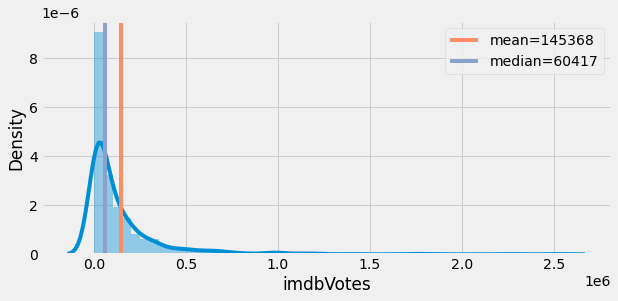

In [240]:
# imdbVotes distribution 
plot_votes = df_votes['imdbVotes']

# Plot imdbVotes
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
ax1 = sns.distplot(plot_votes, kde_kws=dict(bw=0.2))

ax1.axvline(x=plot_votes.mean(), c=sns.color_palette("Set2")[1], label=f"mean={int(plot_votes.mean())}")
ax1.axvline(x=plot_votes.median(), c=sns.color_palette("Set2")[2], label=f"median={int(plot_votes.median())}")
plt.legend();

In [241]:
# https://en.wikipedia.org/wiki/Kurtosis
# Kurtosis is a measure of the "tailedness" of the probability distribution of a real-valued random variable. 
df_rating.imdbVotes.kurtosis()

25.712568020651894

## Production Companies

In [242]:
cols = ['Title', 'Year', 'Rated', 'Genre', 'Director', 'Language', 'Country', 'imdbRating', 'Production', 'Timestamp']

# Set production dataframe
df_production = df[cols].copy()

In [243]:
# Number of production companies
len(counter_display(df_production, 'Production', 'Title', None).index)

2616

In [244]:
# Production / ratings
df_production_rating = get_mean_value(df_production, 'Production', 'imdbRating')

In [245]:
# Top producton companies 
N = 20
show_all(df_production_rating.nlargest(N, 'Total', keep='all').style.background_gradient(subset=['imdbRating']).set_precision(2))

In [246]:
# Production compnaies with highest imdbRating average
show_all(df_production_rating[df_production_rating['Total'] > 2].nlargest(N, 'imdbRating', keep='all'))

In [247]:
# Search by production company
prod_company = 'Wild Bunch'
show_all(pd.DataFrame(df_production_rating.loc[prod_company]).T)

In [248]:
# Common Production pairing
df_production_pairs = pairing(df_production, 'Production')

# Show top pairs
N = 10
show_all(df_production_pairs.nlargest(N, 'Count', keep='all'))

In [249]:
# Partnership between Production / Director
df_production_director = df_production.copy()

gb_production_director_pair = double_group_info(df_production_director, 'Production', 'Director')
show_all(gb_production_director_pair)

In [250]:
# Relation between Production / Country
df_production_country = df_production.copy()

gb_production_country_pair = double_group_info(df_production_country, 'Production', 'Country', 1)
show_all(gb_production_country_pair)